## Load Libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm

## Load Data

In [2]:
# Load the dataset
train_data = pd.read_csv('train.csv')
train_data.head(5)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## We noticed that label is in the first column!!

In [3]:
# Move labels to the last column in training data
train_data = train_data[[col for col in train_data.columns if col != 'label'] + ['label']]

# Separate features (pixels) and labels
X_train_values, y_train = train_data.iloc[:, :-1].values.reshape(-1, 28, 28), train_data.iloc[:, -1]
train_data.head(5)

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Define a custom dataset class that inherits from PyTorch's Dataset class. 

In [4]:
class CustomDataset(Dataset): # Define a new class named CustomDataset that inherits from the Dataset class provided by PyTorch
    def __init__(self, images, labels, transform):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image, label = self.images[idx], self.labels[idx]
        if self.transform:
            # Add a batch dimension to the image
            image = self.transform(image.unsqueeze(0))
        return image, label

## Apply transformations to the images

In [5]:
# Convert the training data from Pandas DataFrames to PyTorch tensors
X_train = torch.Tensor(X_train_values)
y_train = torch.LongTensor(y_train.values)

# Define a transformation using PyTorch's Compose class.
transform = transforms.Compose([transforms.Normalize((0.5,), (0.5,))])
# tuple 1 set mean to 0.5
# tuple 2 set std to 0.5
# (Original - mean) / std --> Range (0. 1)

#transform = transforms.Compose([
#    RandomRotation(degrees=15),          # Randomly rotate the image by up to 15 degrees
#    RandomHorizontalFlip(p=0.5),         # Randomly flip the image horizontally with a probability of 0.5
#    RandomVerticalFlip(p=0.5),           # Randomly flip the image vertically with a probability of 0.5
#    transforms.Normalize((0.5,), (0.5,))
#])

# Create instances of the CustomDataset class created for the training and test datasets, with the specified transformations.
train_dataset = CustomDataset(X_train, y_train, transform=transform)
# image, label

# Split the training data into training and validation sets using train_test_split() from sklearn
train_set, val_set = train_test_split(train_dataset, test_size=0.2, random_state=42, stratify=y_train)


## Create data loaders using PyTorch's DataLoader class

In [6]:
# These loaders allow for iterating over batches of data during training, validation, and testing
# As Batch size decrease to a certain limit accuracy increases
batch_size = 64
# The shuffle parameter is set to True for the training loader, which shuffles the data to improve training performance
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
# The validation and test loaders have shuffle set to False since ordering doesn't matter during validation and testing
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

## Visualize a few samples from the training set (dataset)

Training set shapes - Images: torch.Size([42000, 28, 28]), Labels: torch.Size([42000])
Validation set shapes - Images: torch.Size([8400, 1, 28, 28]), Labels: torch.Size([8400])

------------------------------------------------

Class Distribution in Training Set:
Digit 0: 4132 samples
Digit 1: 4684 samples
Digit 2: 4177 samples
Digit 3: 4351 samples
Digit 4: 4072 samples
Digit 5: 3795 samples
Digit 6: 4137 samples
Digit 7: 4401 samples
Digit 8: 4063 samples
Digit 9: 4188 samples

------------------------------------------------



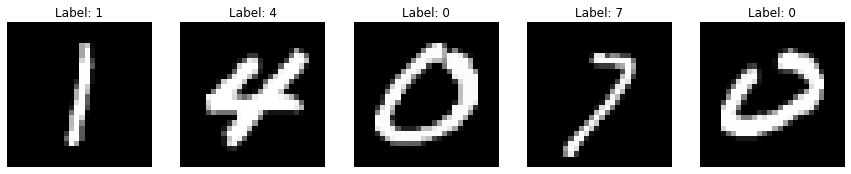

In [7]:
# Visualize a few samples from the dataset
def visualize_samples(data_loader, num_samples=5):
    for images, labels in data_loader:
        fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))

        for i in range(num_samples):
            img = images[i].numpy().squeeze()
            label = labels[i].item()

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(f"Label: {label}")
            axes[i].axis('off')

        plt.show()
        break  # Break to only visualize one batch

# Print shapes of the datasets:
# Print shape of training data
print(f"Training set shapes - Images: {X_train.shape}, Labels: {y_train.shape}")

# Access the images and labels from the tuple in val_set
val_images, val_labels = zip(*val_set)
val_images = torch.stack(val_images)
val_labels = torch.stack(val_labels)

# Print shape of validation_set data
print(f"Validation set shapes - Images: {val_images.shape}, Labels: {val_labels.shape}")

# Note: Removed code related to y_test

# Explore class distribution in the training set
class_distribution = {i: 0 for i in range(10)}
for label in y_train:
    class_distribution[label.item()] += 1

print()
print("------------------------------------------------")
print()

print("Class Distribution in Training Set:")
for digit, count in class_distribution.items():
    print(f"Digit {digit}: {count} samples")
    
print()
print("------------------------------------------------")
print()

# Visualize a few samples from the training set
visualize_samples(train_loader)


# Define the neural network architecture

In [68]:
# Create a Model Class that inherits nn.Module (Pytorch)
class Model(nn.Module):
    
    # Define (Constructor) Layers Of the Neural network (using pytorch's 'nn' module)
    def __init__(self, in_features, h1, h2, out_features, dropout_prob1=0.15, dropout_prob2=0.2): #dropout_prob1=0.3, dropout_prob2=0.5
        # construct the nn model
        super(Model, self).__init__() 
        
        # Use He initialization for the weights
        he_init = torch.nn.init.kaiming_normal_
        self.flatten = nn.Flatten() # unroll
        self.fc1 = nn.Linear(in_features, h1) # Defining a linear layer with input size in_features and output size h1 (apply linear transformation: z=wx+b)
        self.fc2 = nn.Linear(h1, h2)
        self.out = nn.Linear(h2, out_features)
        
        # Dropout layers for regularization (helps prevent overfitting)
        self.dropout1 = nn.Dropout(dropout_prob1)
        self.dropout2 = nn.Dropout(dropout_prob2)
        
        # Layer normalization (helps stabilize the training process)
        self.layer_norm1 = nn.LayerNorm(h1)
        self.layer_norm2 = nn.LayerNorm(h2)
        
        # Loss function and Optimizer:

        # Measure measure the error
        self.loss = nn.CrossEntropyLoss() 

        # Choose Stochastic Gradient Descent (SGD) as the optimizer (simple & Memory Efficient)
        # learning rate -> if error doesn't decrease after a bunch of iterations (epochs) donc lower it (req-> try 5 diff. lr)
        # weight_decay (the regularization term) adds L2 Regularization to the optimizer
        #self.optimizer = optim.Adam(model.parameters(), lr = 0.001, weight_decay = 1e-5)
        self.optimizer = optim.SGD(self.parameters(), lr = 0.01, weight_decay = 1e-5)
        
        
    # Implementation of the forward path using the reLU activation function
    def forward(self, x):
        x = self.flatten(x) # Unroll: flatten the input tensor (1D) before passing it through the fully connected layers
        #x = x.view(-1, in_features)
        x = F.relu(self.layer_norm1(self.fc1(x)))
        x = self.dropout1(x)
        x = F.relu(self.layer_norm2(self.fc2(x)))
        x = self.dropout2(x)
        x = F.softmax(self.out(x), dim = 1)
        
        # X_train_softmax = F.softmax(X_train, dim=1)
        # instead of:
        # softmax_layer = nn.Softmax(dim=1)
        # X_train_softmax = softmax_layer(X_train)
        return x
    
    
    def fit(self, X, y):
        self. optimizer.zero_grad()  # To avoid accumulating gradients from previous batches
        y_predict = self.forward(X)
        loss = self.loss(y_predict, y)
        loss.backward()  # To compute the gradients of the loss with respect to the model parameters
        self.optimizer.step() # Update Weights
        return loss.item()
    
    def predict(self, X):
        with torch.no_grad():
            return torch.argmax(self.forward(X), axis=1)
        
# Set the input size, hidden layer sizes, and output size
in_features = 28 * 28
h1 = 128
h2 = 64
out_features = 10

# Create an object of the model -> Instantiate the model
model = Model(in_features, h1, h2, out_features)

# Pick a manual seed for randomization
torch.manual_seed(42)

In [69]:
# Test to see how layers are going to be
model.parameters

<bound method Module.parameters of Model(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=10, bias=True)
  (dropout1): Dropout(p=0.15, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
  (layer_norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (layer_norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
  (loss): CrossEntropyLoss()
)>

## Function For Training 

In [70]:
# Function for training
def train(model, train_loader):
    model.train()  # Set the model to training mode
    total_loss = 0.0
    correct_train = 0

    for batch_images, batch_labels in tqdm(train_loader, desc='Training'):
        # Forward pass and update weights
        loss = model.fit(batch_images, batch_labels)
        total_loss += loss
        correct_train += (model.predict(batch_images) == batch_labels).sum().item()

    # Calculate average training loss and accuracy
    average_loss = total_loss / len(train_loader)
    train_accuracy = 100 * correct_train / len(train_set)

    return average_loss, train_accuracy

##  Function For Validation 

In [71]:
# Function for validation
def validate(model, val_loader):
    model.eval()  # Set the model to evaluation mode
    total_val_loss = 0.0
    correct_val = 0

    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_loss = model.loss(model.forward(val_images), val_labels)
            total_val_loss += val_loss.item()
            correct_val += (model.predict(val_images) == val_labels).sum().item()

    # Calculate average validation loss and accuracy
    average_val_loss = total_val_loss / len(val_loader)
    val_accuracy = 100 * correct_val / len(val_set)

    return average_val_loss, val_accuracy

## Training Loop

In [72]:
# Set the number of epochs
num_epochs = 20

# Lists to store metrics for plotting
train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

# Training loop
for epoch in range(num_epochs):
    # Training
    average_loss, train_accuracy = train(model, train_loader)
    train_loss_history.append(average_loss)
    train_acc_history.append(train_accuracy)

    # Validation
    average_val_loss, val_accuracy = validate(model, val_loader)
    val_loss_history.append(average_val_loss)
    val_acc_history.append(val_accuracy)

    # Print and visualize metrics
    print(f'Epoch [{epoch + 1}/{num_epochs}], '
          f'Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, '
          f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%')

Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 246.92it/s]


Epoch [1/20], Training Loss: 2.2323, Training Accuracy: 33.6161%, Validation Loss: 2.1186, Validation Accuracy: 51.7143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 273.49it/s]


Epoch [2/20], Training Loss: 2.0613, Training Accuracy: 54.5685%, Validation Loss: 1.9500, Validation Accuracy: 61.3095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 252.35it/s]


Epoch [3/20], Training Loss: 1.9321, Training Accuracy: 65.7649%, Validation Loss: 1.8338, Validation Accuracy: 74.3452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 262.44it/s]


Epoch [4/20], Training Loss: 1.8275, Training Accuracy: 76.9077%, Validation Loss: 1.7366, Validation Accuracy: 81.4048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 269.43it/s]


Epoch [5/20], Training Loss: 1.7539, Training Accuracy: 80.8155%, Validation Loss: 1.6864, Validation Accuracy: 82.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 264.26it/s]


Epoch [6/20], Training Loss: 1.7124, Training Accuracy: 82.1756%, Validation Loss: 1.6603, Validation Accuracy: 83.4286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 258.33it/s]


Epoch [7/20], Training Loss: 1.6869, Training Accuracy: 83.0744%, Validation Loss: 1.6429, Validation Accuracy: 84.4881%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 273.60it/s]


Epoch [8/20], Training Loss: 1.6669, Training Accuracy: 84.4107%, Validation Loss: 1.6218, Validation Accuracy: 87.0833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.76it/s]


Epoch [9/20], Training Loss: 1.6393, Training Accuracy: 88.2500%, Validation Loss: 1.5933, Validation Accuracy: 90.2024%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 259.76it/s]


Epoch [10/20], Training Loss: 1.6166, Training Accuracy: 90.1250%, Validation Loss: 1.5768, Validation Accuracy: 91.2143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.67it/s]


Epoch [11/20], Training Loss: 1.6021, Training Accuracy: 90.9018%, Validation Loss: 1.5670, Validation Accuracy: 91.7619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 275.83it/s]


Epoch [12/20], Training Loss: 1.5916, Training Accuracy: 91.5119%, Validation Loss: 1.5600, Validation Accuracy: 92.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 268.52it/s]


Epoch [13/20], Training Loss: 1.5810, Training Accuracy: 91.7976%, Validation Loss: 1.5538, Validation Accuracy: 92.3929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 272.70it/s]


Epoch [14/20], Training Loss: 1.5757, Training Accuracy: 92.0804%, Validation Loss: 1.5492, Validation Accuracy: 92.5952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 263.55it/s]


Epoch [15/20], Training Loss: 1.5705, Training Accuracy: 92.2976%, Validation Loss: 1.5465, Validation Accuracy: 92.8571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 262.97it/s]


Epoch [16/20], Training Loss: 1.5648, Training Accuracy: 92.7708%, Validation Loss: 1.5432, Validation Accuracy: 92.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 273.99it/s]


Epoch [17/20], Training Loss: 1.5618, Training Accuracy: 92.9464%, Validation Loss: 1.5399, Validation Accuracy: 93.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 257.96it/s]


Epoch [18/20], Training Loss: 1.5577, Training Accuracy: 93.1756%, Validation Loss: 1.5376, Validation Accuracy: 93.3929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.66it/s]


Epoch [19/20], Training Loss: 1.5536, Training Accuracy: 93.3065%, Validation Loss: 1.5359, Validation Accuracy: 93.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 268.61it/s]


Epoch [20/20], Training Loss: 1.5511, Training Accuracy: 93.5744%, Validation Loss: 1.5343, Validation Accuracy: 93.6429%


## Visualize Loss and Accuracy through Epochs

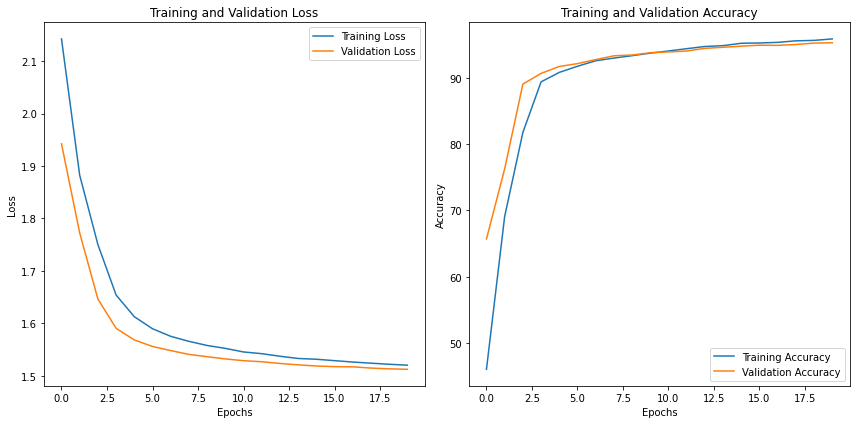

In [13]:
# Plot training and validation loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Customized Training Loop to try some different Learning rates

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 415.63it/s]


Epoch [1/20], Training Loss: 2.3044, Training Accuracy: 8.7202%, Validation Loss: 2.3022, Validation Accuracy: 8.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 420.28it/s]


Epoch [2/20], Training Loss: 2.3002, Training Accuracy: 10.2500%, Validation Loss: 2.2970, Validation Accuracy: 10.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 417.19it/s]


Epoch [3/20], Training Loss: 2.2956, Training Accuracy: 12.4048%, Validation Loss: 2.2913, Validation Accuracy: 13.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 382.14it/s]


Epoch [4/20], Training Loss: 2.2902, Training Accuracy: 15.0060%, Validation Loss: 2.2850, Validation Accuracy: 18.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 413.68it/s]


Epoch [5/20], Training Loss: 2.2847, Training Accuracy: 18.0089%, Validation Loss: 2.2781, Validation Accuracy: 22.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 402.16it/s]


Epoch [6/20], Training Loss: 2.2789, Training Accuracy: 21.1012%, Validation Loss: 2.2705, Validation Accuracy: 25.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 400.38it/s]


Epoch [7/20], Training Loss: 2.2720, Training Accuracy: 23.5417%, Validation Loss: 2.2623, Validation Accuracy: 27.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 388.78it/s]


Epoch [8/20], Training Loss: 2.2650, Training Accuracy: 25.7649%, Validation Loss: 2.2537, Validation Accuracy: 28.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.54it/s]


Epoch [9/20], Training Loss: 2.2575, Training Accuracy: 27.3363%, Validation Loss: 2.2447, Validation Accuracy: 30.1310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 426.47it/s]


Epoch [10/20], Training Loss: 2.2502, Training Accuracy: 28.7976%, Validation Loss: 2.2357, Validation Accuracy: 31.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.43it/s]


Epoch [11/20], Training Loss: 2.2424, Training Accuracy: 29.9494%, Validation Loss: 2.2267, Validation Accuracy: 33.1786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.16it/s]


Epoch [12/20], Training Loss: 2.2346, Training Accuracy: 31.6131%, Validation Loss: 2.2178, Validation Accuracy: 34.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.54it/s]


Epoch [13/20], Training Loss: 2.2266, Training Accuracy: 32.8988%, Validation Loss: 2.2089, Validation Accuracy: 36.1786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.53it/s]


Epoch [14/20], Training Loss: 2.2193, Training Accuracy: 33.9911%, Validation Loss: 2.2001, Validation Accuracy: 37.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.73it/s]


Epoch [15/20], Training Loss: 2.2112, Training Accuracy: 35.3988%, Validation Loss: 2.1914, Validation Accuracy: 38.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.78it/s]


Epoch [16/20], Training Loss: 2.2034, Training Accuracy: 36.5655%, Validation Loss: 2.1828, Validation Accuracy: 39.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.94it/s]


Epoch [17/20], Training Loss: 2.1962, Training Accuracy: 37.7530%, Validation Loss: 2.1743, Validation Accuracy: 40.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.10it/s]


Epoch [18/20], Training Loss: 2.1884, Training Accuracy: 38.9762%, Validation Loss: 2.1659, Validation Accuracy: 41.8690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.38it/s]


Epoch [19/20], Training Loss: 2.1811, Training Accuracy: 39.7054%, Validation Loss: 2.1576, Validation Accuracy: 42.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.62it/s]


Epoch [20/20], Training Loss: 2.1738, Training Accuracy: 40.9048%, Validation Loss: 2.1495, Validation Accuracy: 43.6429%


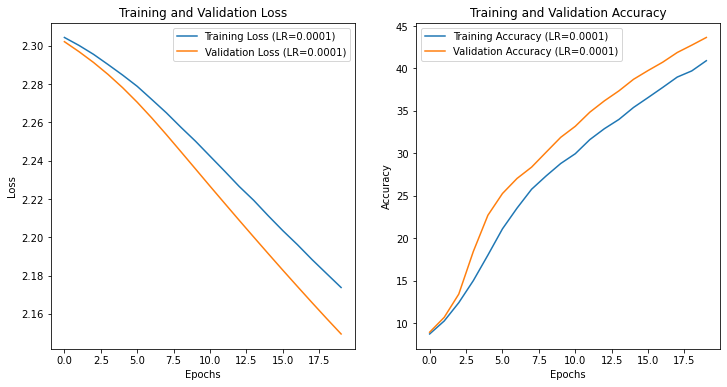

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.10it/s]


Epoch [1/20], Training Loss: 2.2876, Training Accuracy: 18.8899%, Validation Loss: 2.2529, Validation Accuracy: 40.4643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.07it/s]


Epoch [2/20], Training Loss: 2.2230, Training Accuracy: 44.5744%, Validation Loss: 2.1591, Validation Accuracy: 56.5595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.08it/s]


Epoch [3/20], Training Loss: 2.1419, Training Accuracy: 55.2827%, Validation Loss: 2.0705, Validation Accuracy: 59.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 431.86it/s]


Epoch [4/20], Training Loss: 2.0658, Training Accuracy: 58.9345%, Validation Loss: 1.9933, Validation Accuracy: 62.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 435.76it/s]


Epoch [5/20], Training Loss: 1.9995, Training Accuracy: 61.6815%, Validation Loss: 1.9317, Validation Accuracy: 64.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.48it/s]


Epoch [6/20], Training Loss: 1.9467, Training Accuracy: 64.1250%, Validation Loss: 1.8834, Validation Accuracy: 66.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.27it/s]


Epoch [7/20], Training Loss: 1.9050, Training Accuracy: 66.0446%, Validation Loss: 1.8457, Validation Accuracy: 68.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 434.69it/s]


Epoch [8/20], Training Loss: 1.8703, Training Accuracy: 68.5685%, Validation Loss: 1.8148, Validation Accuracy: 70.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.09it/s]


Epoch [9/20], Training Loss: 1.8412, Training Accuracy: 71.6250%, Validation Loss: 1.7849, Validation Accuracy: 75.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 433.23it/s]


Epoch [10/20], Training Loss: 1.8134, Training Accuracy: 76.0149%, Validation Loss: 1.7539, Validation Accuracy: 80.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.00it/s]


Epoch [11/20], Training Loss: 1.7835, Training Accuracy: 80.1607%, Validation Loss: 1.7228, Validation Accuracy: 84.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 433.49it/s]


Epoch [12/20], Training Loss: 1.7542, Training Accuracy: 83.1696%, Validation Loss: 1.6948, Validation Accuracy: 86.4524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 450.50it/s]


Epoch [13/20], Training Loss: 1.7282, Training Accuracy: 85.2976%, Validation Loss: 1.6703, Validation Accuracy: 87.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 440.35it/s]


Epoch [14/20], Training Loss: 1.7056, Training Accuracy: 86.2946%, Validation Loss: 1.6504, Validation Accuracy: 88.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.19it/s]


Epoch [15/20], Training Loss: 1.6865, Training Accuracy: 87.4375%, Validation Loss: 1.6344, Validation Accuracy: 89.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.95it/s]


Epoch [16/20], Training Loss: 1.6693, Training Accuracy: 88.1548%, Validation Loss: 1.6213, Validation Accuracy: 89.5833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.81it/s]


Epoch [17/20], Training Loss: 1.6567, Training Accuracy: 88.5238%, Validation Loss: 1.6107, Validation Accuracy: 89.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.95it/s]


Epoch [18/20], Training Loss: 1.6452, Training Accuracy: 89.1250%, Validation Loss: 1.6022, Validation Accuracy: 90.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.03it/s]


Epoch [19/20], Training Loss: 1.6364, Training Accuracy: 89.4375%, Validation Loss: 1.5952, Validation Accuracy: 90.4762%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.51it/s]


Epoch [20/20], Training Loss: 1.6283, Training Accuracy: 89.7589%, Validation Loss: 1.5885, Validation Accuracy: 90.7381%


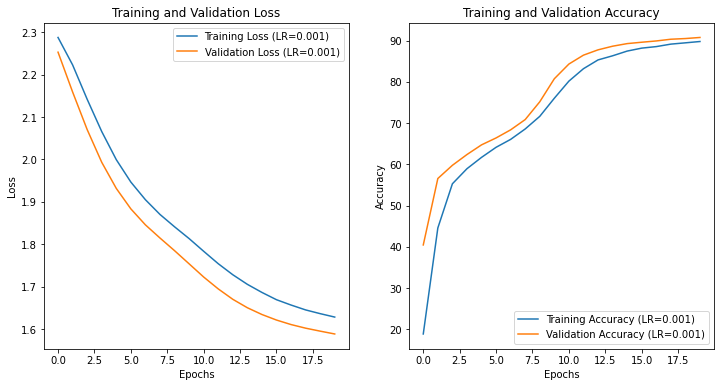

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [1/20], Training Loss: 2.2288, Training Accuracy: 36.9702%, Validation Loss: 2.1001, Validation Accuracy: 66.3214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 452.29it/s]


Epoch [2/20], Training Loss: 2.0186, Training Accuracy: 67.5268%, Validation Loss: 1.8749, Validation Accuracy: 75.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.66it/s]


Epoch [3/20], Training Loss: 1.8558, Training Accuracy: 75.9911%, Validation Loss: 1.7526, Validation Accuracy: 80.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.60it/s]


Epoch [4/20], Training Loss: 1.7630, Training Accuracy: 80.5565%, Validation Loss: 1.6911, Validation Accuracy: 82.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.53it/s]


Epoch [5/20], Training Loss: 1.7148, Training Accuracy: 82.2887%, Validation Loss: 1.6624, Validation Accuracy: 83.5238%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.38it/s]


Epoch [6/20], Training Loss: 1.6874, Training Accuracy: 82.9256%, Validation Loss: 1.6468, Validation Accuracy: 83.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.92it/s]


Epoch [7/20], Training Loss: 1.6705, Training Accuracy: 83.6815%, Validation Loss: 1.6361, Validation Accuracy: 84.2738%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.96it/s]


Epoch [8/20], Training Loss: 1.6581, Training Accuracy: 84.2500%, Validation Loss: 1.6289, Validation Accuracy: 84.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.18it/s]


Epoch [9/20], Training Loss: 1.6481, Training Accuracy: 84.6131%, Validation Loss: 1.6240, Validation Accuracy: 84.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [10/20], Training Loss: 1.6417, Training Accuracy: 84.8780%, Validation Loss: 1.6184, Validation Accuracy: 85.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [11/20], Training Loss: 1.6345, Training Accuracy: 85.1161%, Validation Loss: 1.6121, Validation Accuracy: 85.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.85it/s]


Epoch [12/20], Training Loss: 1.6237, Training Accuracy: 86.8839%, Validation Loss: 1.5933, Validation Accuracy: 89.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.89it/s]


Epoch [13/20], Training Loss: 1.6014, Training Accuracy: 90.3304%, Validation Loss: 1.5697, Validation Accuracy: 91.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.35it/s]


Epoch [14/20], Training Loss: 1.5850, Training Accuracy: 91.5357%, Validation Loss: 1.5572, Validation Accuracy: 92.4286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.73it/s]


Epoch [15/20], Training Loss: 1.5753, Training Accuracy: 92.1994%, Validation Loss: 1.5499, Validation Accuracy: 92.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.85it/s]


Epoch [16/20], Training Loss: 1.5676, Training Accuracy: 92.6845%, Validation Loss: 1.5453, Validation Accuracy: 92.8690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.97it/s]


Epoch [17/20], Training Loss: 1.5616, Training Accuracy: 93.0357%, Validation Loss: 1.5416, Validation Accuracy: 93.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 427.10it/s]


Epoch [18/20], Training Loss: 1.5565, Training Accuracy: 93.3810%, Validation Loss: 1.5386, Validation Accuracy: 93.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.41it/s]


Epoch [19/20], Training Loss: 1.5526, Training Accuracy: 93.5179%, Validation Loss: 1.5362, Validation Accuracy: 93.4762%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.11it/s]


Epoch [20/20], Training Loss: 1.5488, Training Accuracy: 93.7411%, Validation Loss: 1.5326, Validation Accuracy: 93.7619%


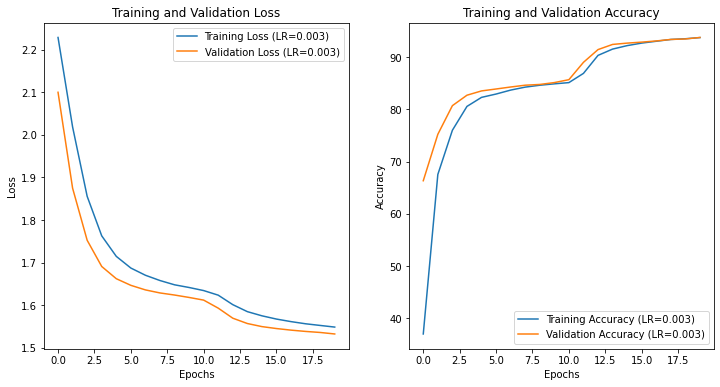

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.06it/s]


Epoch [1/20], Training Loss: 2.0089, Training Accuracy: 60.2113%, Validation Loss: 1.7378, Validation Accuracy: 81.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.30it/s]


Epoch [2/20], Training Loss: 1.6944, Training Accuracy: 86.0982%, Validation Loss: 1.5968, Validation Accuracy: 90.2857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.04it/s]


Epoch [3/20], Training Loss: 1.6082, Training Accuracy: 91.3244%, Validation Loss: 1.5621, Validation Accuracy: 91.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.99it/s]


Epoch [4/20], Training Loss: 1.5769, Training Accuracy: 92.8214%, Validation Loss: 1.5469, Validation Accuracy: 92.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 387.71it/s]


Epoch [5/20], Training Loss: 1.5610, Training Accuracy: 93.5268%, Validation Loss: 1.5366, Validation Accuracy: 93.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 402.98it/s]


Epoch [6/20], Training Loss: 1.5502, Training Accuracy: 93.9970%, Validation Loss: 1.5312, Validation Accuracy: 93.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 381.66it/s]


Epoch [7/20], Training Loss: 1.5416, Training Accuracy: 94.7887%, Validation Loss: 1.5255, Validation Accuracy: 94.2738%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 423.67it/s]


Epoch [8/20], Training Loss: 1.5348, Training Accuracy: 95.1280%, Validation Loss: 1.5203, Validation Accuracy: 94.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 429.79it/s]


Epoch [9/20], Training Loss: 1.5298, Training Accuracy: 95.3065%, Validation Loss: 1.5169, Validation Accuracy: 94.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 435.52it/s]


Epoch [10/20], Training Loss: 1.5251, Training Accuracy: 95.7202%, Validation Loss: 1.5145, Validation Accuracy: 95.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.99it/s]


Epoch [11/20], Training Loss: 1.5217, Training Accuracy: 95.9851%, Validation Loss: 1.5117, Validation Accuracy: 95.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 430.50it/s]


Epoch [12/20], Training Loss: 1.5189, Training Accuracy: 96.1131%, Validation Loss: 1.5097, Validation Accuracy: 95.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 426.07it/s]


Epoch [13/20], Training Loss: 1.5152, Training Accuracy: 96.3333%, Validation Loss: 1.5086, Validation Accuracy: 95.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 414.65it/s]


Epoch [14/20], Training Loss: 1.5141, Training Accuracy: 96.4524%, Validation Loss: 1.5052, Validation Accuracy: 95.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 418.61it/s]


Epoch [15/20], Training Loss: 1.5108, Training Accuracy: 96.8065%, Validation Loss: 1.5043, Validation Accuracy: 96.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.78it/s]


Epoch [16/20], Training Loss: 1.5094, Training Accuracy: 96.7173%, Validation Loss: 1.5045, Validation Accuracy: 96.0595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.16it/s]


Epoch [17/20], Training Loss: 1.5067, Training Accuracy: 96.8214%, Validation Loss: 1.5023, Validation Accuracy: 96.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.04it/s]


Epoch [18/20], Training Loss: 1.5061, Training Accuracy: 96.9137%, Validation Loss: 1.5005, Validation Accuracy: 96.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.97it/s]


Epoch [19/20], Training Loss: 1.5031, Training Accuracy: 97.2143%, Validation Loss: 1.4998, Validation Accuracy: 96.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 453.22it/s]


Epoch [20/20], Training Loss: 1.5022, Training Accuracy: 97.1310%, Validation Loss: 1.5018, Validation Accuracy: 96.0833%


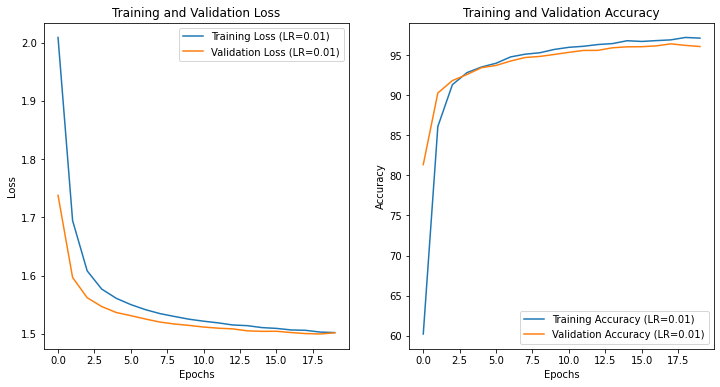

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.04it/s]


Epoch [1/20], Training Loss: 1.8334, Training Accuracy: 71.8988%, Validation Loss: 1.6295, Validation Accuracy: 87.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.81it/s]


Epoch [2/20], Training Loss: 1.5880, Training Accuracy: 92.8869%, Validation Loss: 1.5400, Validation Accuracy: 93.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.67it/s]


Epoch [3/20], Training Loss: 1.5508, Training Accuracy: 94.5238%, Validation Loss: 1.5254, Validation Accuracy: 94.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.97it/s]


Epoch [4/20], Training Loss: 1.5372, Training Accuracy: 95.1905%, Validation Loss: 1.5204, Validation Accuracy: 94.5238%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.98it/s]


Epoch [5/20], Training Loss: 1.5283, Training Accuracy: 95.9196%, Validation Loss: 1.5151, Validation Accuracy: 95.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.84it/s]


Epoch [6/20], Training Loss: 1.5199, Training Accuracy: 95.9970%, Validation Loss: 1.5079, Validation Accuracy: 95.5833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.02it/s]


Epoch [7/20], Training Loss: 1.5166, Training Accuracy: 96.5298%, Validation Loss: 1.5060, Validation Accuracy: 95.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.91it/s]


Epoch [8/20], Training Loss: 1.5112, Training Accuracy: 96.6845%, Validation Loss: 1.5041, Validation Accuracy: 95.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.36it/s]


Epoch [9/20], Training Loss: 1.5079, Training Accuracy: 96.8452%, Validation Loss: 1.5034, Validation Accuracy: 95.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.91it/s]


Epoch [10/20], Training Loss: 1.5055, Training Accuracy: 97.0327%, Validation Loss: 1.5014, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.87it/s]


Epoch [11/20], Training Loss: 1.5035, Training Accuracy: 97.1220%, Validation Loss: 1.4978, Validation Accuracy: 96.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.29it/s]


Epoch [12/20], Training Loss: 1.5018, Training Accuracy: 97.3006%, Validation Loss: 1.4972, Validation Accuracy: 96.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.47it/s]


Epoch [13/20], Training Loss: 1.4996, Training Accuracy: 97.5298%, Validation Loss: 1.4969, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.79it/s]


Epoch [14/20], Training Loss: 1.4980, Training Accuracy: 97.5298%, Validation Loss: 1.4975, Validation Accuracy: 96.4524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.83it/s]


Epoch [15/20], Training Loss: 1.4963, Training Accuracy: 97.6190%, Validation Loss: 1.4965, Validation Accuracy: 96.5595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 429.51it/s]


Epoch [16/20], Training Loss: 1.4952, Training Accuracy: 97.7083%, Validation Loss: 1.4981, Validation Accuracy: 96.4286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 373.46it/s]


Epoch [17/20], Training Loss: 1.4941, Training Accuracy: 97.7738%, Validation Loss: 1.4941, Validation Accuracy: 96.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.29it/s]


Epoch [18/20], Training Loss: 1.4930, Training Accuracy: 97.8512%, Validation Loss: 1.4958, Validation Accuracy: 96.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.08it/s]


Epoch [19/20], Training Loss: 1.4919, Training Accuracy: 97.8274%, Validation Loss: 1.4937, Validation Accuracy: 96.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.91it/s]


Epoch [20/20], Training Loss: 1.4911, Training Accuracy: 97.9673%, Validation Loss: 1.4930, Validation Accuracy: 96.9643%


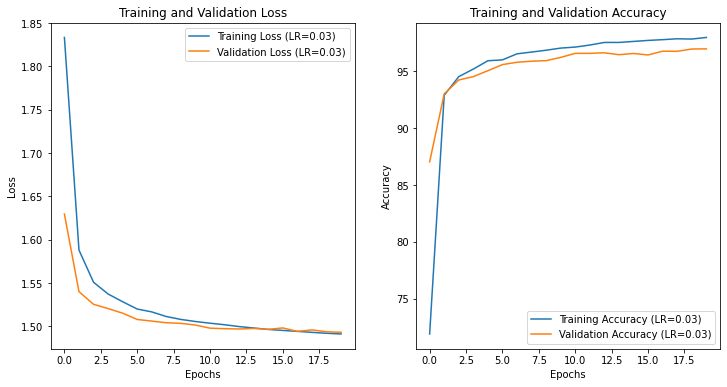

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 440.80it/s]


Epoch [1/20], Training Loss: 1.7625, Training Accuracy: 78.2619%, Validation Loss: 1.5795, Validation Accuracy: 89.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.36it/s]


Epoch [2/20], Training Loss: 1.5655, Training Accuracy: 93.8304%, Validation Loss: 1.5386, Validation Accuracy: 92.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.00it/s]


Epoch [3/20], Training Loss: 1.5402, Training Accuracy: 95.1161%, Validation Loss: 1.5194, Validation Accuracy: 94.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 436.85it/s]


Epoch [4/20], Training Loss: 1.5272, Training Accuracy: 95.8542%, Validation Loss: 1.5163, Validation Accuracy: 94.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [5/20], Training Loss: 1.5203, Training Accuracy: 96.1935%, Validation Loss: 1.5078, Validation Accuracy: 95.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 450.69it/s]


Epoch [6/20], Training Loss: 1.5148, Training Accuracy: 96.5089%, Validation Loss: 1.5078, Validation Accuracy: 95.5000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 452.54it/s]


Epoch [7/20], Training Loss: 1.5090, Training Accuracy: 96.9048%, Validation Loss: 1.5060, Validation Accuracy: 95.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.43it/s]


Epoch [8/20], Training Loss: 1.5057, Training Accuracy: 96.9226%, Validation Loss: 1.5014, Validation Accuracy: 96.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.16it/s]


Epoch [9/20], Training Loss: 1.5037, Training Accuracy: 97.0863%, Validation Loss: 1.4989, Validation Accuracy: 96.4643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.34it/s]


Epoch [10/20], Training Loss: 1.5009, Training Accuracy: 97.4286%, Validation Loss: 1.4970, Validation Accuracy: 96.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.41it/s]


Epoch [11/20], Training Loss: 1.4996, Training Accuracy: 97.3780%, Validation Loss: 1.4993, Validation Accuracy: 96.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.85it/s]


Epoch [12/20], Training Loss: 1.4977, Training Accuracy: 97.4345%, Validation Loss: 1.4971, Validation Accuracy: 96.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.22it/s]


Epoch [13/20], Training Loss: 1.4951, Training Accuracy: 97.6458%, Validation Loss: 1.4929, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.53it/s]


Epoch [14/20], Training Loss: 1.4942, Training Accuracy: 97.7083%, Validation Loss: 1.4936, Validation Accuracy: 96.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.41it/s]


Epoch [15/20], Training Loss: 1.4921, Training Accuracy: 97.7857%, Validation Loss: 1.4920, Validation Accuracy: 96.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 411.26it/s]


Epoch [16/20], Training Loss: 1.4918, Training Accuracy: 97.9167%, Validation Loss: 1.4946, Validation Accuracy: 96.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 422.38it/s]


Epoch [17/20], Training Loss: 1.4906, Training Accuracy: 97.8780%, Validation Loss: 1.4917, Validation Accuracy: 97.0714%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 450.69it/s]


Epoch [18/20], Training Loss: 1.4889, Training Accuracy: 97.9375%, Validation Loss: 1.4907, Validation Accuracy: 97.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.69it/s]


Epoch [19/20], Training Loss: 1.4893, Training Accuracy: 98.0714%, Validation Loss: 1.4925, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.60it/s]


Epoch [20/20], Training Loss: 1.4881, Training Accuracy: 98.0982%, Validation Loss: 1.4891, Validation Accuracy: 97.3333%


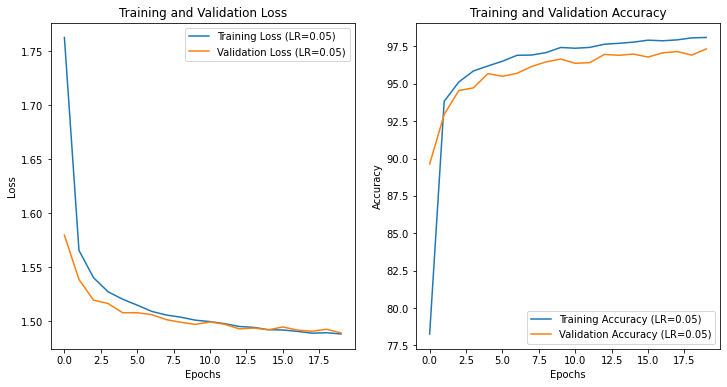

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.34it/s]


Epoch [1/20], Training Loss: 1.6839, Training Accuracy: 85.1280%, Validation Loss: 1.5514, Validation Accuracy: 91.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 386.74it/s]


Epoch [2/20], Training Loss: 1.5468, Training Accuracy: 94.7560%, Validation Loss: 1.5256, Validation Accuracy: 94.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 392.55it/s]


Epoch [3/20], Training Loss: 1.5308, Training Accuracy: 95.6369%, Validation Loss: 1.5162, Validation Accuracy: 94.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.10it/s]


Epoch [4/20], Training Loss: 1.5208, Training Accuracy: 96.0238%, Validation Loss: 1.5091, Validation Accuracy: 95.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.73it/s]


Epoch [5/20], Training Loss: 1.5137, Training Accuracy: 96.4732%, Validation Loss: 1.5091, Validation Accuracy: 95.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 402.96it/s]


Epoch [6/20], Training Loss: 1.5111, Training Accuracy: 96.8125%, Validation Loss: 1.5041, Validation Accuracy: 95.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.22it/s]


Epoch [7/20], Training Loss: 1.5063, Training Accuracy: 96.9881%, Validation Loss: 1.5003, Validation Accuracy: 96.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 388.10it/s]


Epoch [8/20], Training Loss: 1.5030, Training Accuracy: 97.0714%, Validation Loss: 1.5021, Validation Accuracy: 96.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.80it/s]


Epoch [9/20], Training Loss: 1.4997, Training Accuracy: 97.2649%, Validation Loss: 1.5011, Validation Accuracy: 96.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [10/20], Training Loss: 1.4993, Training Accuracy: 97.3661%, Validation Loss: 1.4958, Validation Accuracy: 96.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 440.59it/s]


Epoch [11/20], Training Loss: 1.4960, Training Accuracy: 97.5804%, Validation Loss: 1.4980, Validation Accuracy: 96.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.42it/s]


Epoch [12/20], Training Loss: 1.4957, Training Accuracy: 97.7083%, Validation Loss: 1.4993, Validation Accuracy: 96.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.67it/s]


Epoch [13/20], Training Loss: 1.4938, Training Accuracy: 97.8482%, Validation Loss: 1.4956, Validation Accuracy: 96.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.73it/s]


Epoch [14/20], Training Loss: 1.4908, Training Accuracy: 97.7113%, Validation Loss: 1.4930, Validation Accuracy: 96.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.80it/s]


Epoch [15/20], Training Loss: 1.4902, Training Accuracy: 97.7827%, Validation Loss: 1.4925, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.81it/s]


Epoch [16/20], Training Loss: 1.4885, Training Accuracy: 97.9494%, Validation Loss: 1.4939, Validation Accuracy: 96.8095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.05it/s]


Epoch [17/20], Training Loss: 1.4893, Training Accuracy: 97.9940%, Validation Loss: 1.4927, Validation Accuracy: 96.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.05it/s]


Epoch [18/20], Training Loss: 1.4871, Training Accuracy: 98.0268%, Validation Loss: 1.4925, Validation Accuracy: 96.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.52it/s]


Epoch [19/20], Training Loss: 1.4869, Training Accuracy: 98.0833%, Validation Loss: 1.4939, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 452.72it/s]


Epoch [20/20], Training Loss: 1.4866, Training Accuracy: 98.0387%, Validation Loss: 1.4916, Validation Accuracy: 97.0000%


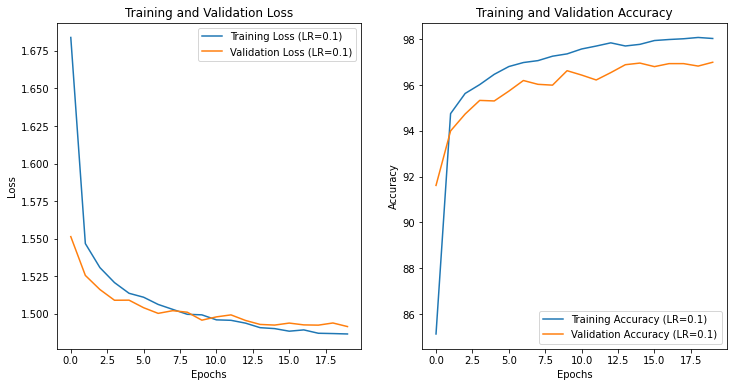

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.96it/s]


Epoch [1/20], Training Loss: 1.6753, Training Accuracy: 83.3810%, Validation Loss: 1.6116, Validation Accuracy: 85.0595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 408.20it/s]


Epoch [2/20], Training Loss: 1.5677, Training Accuracy: 92.1339%, Validation Loss: 1.5253, Validation Accuracy: 93.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.99it/s]


Epoch [3/20], Training Loss: 1.5336, Training Accuracy: 94.8304%, Validation Loss: 1.5256, Validation Accuracy: 93.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 423.92it/s]


Epoch [4/20], Training Loss: 1.5216, Training Accuracy: 95.5536%, Validation Loss: 1.5113, Validation Accuracy: 95.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 386.21it/s]


Epoch [5/20], Training Loss: 1.5153, Training Accuracy: 96.0357%, Validation Loss: 1.5073, Validation Accuracy: 95.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 364.04it/s]


Epoch [6/20], Training Loss: 1.5104, Training Accuracy: 96.3185%, Validation Loss: 1.5060, Validation Accuracy: 95.4881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 389.35it/s]


Epoch [7/20], Training Loss: 1.5080, Training Accuracy: 96.6518%, Validation Loss: 1.5077, Validation Accuracy: 95.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 374.27it/s]


Epoch [8/20], Training Loss: 1.5042, Training Accuracy: 96.7917%, Validation Loss: 1.5011, Validation Accuracy: 96.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 372.54it/s]


Epoch [9/20], Training Loss: 1.5015, Training Accuracy: 97.0387%, Validation Loss: 1.5022, Validation Accuracy: 95.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 398.64it/s]


Epoch [10/20], Training Loss: 1.5000, Training Accuracy: 97.1280%, Validation Loss: 1.4991, Validation Accuracy: 96.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 398.49it/s]


Epoch [11/20], Training Loss: 1.4978, Training Accuracy: 97.2589%, Validation Loss: 1.4953, Validation Accuracy: 96.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 369.02it/s]


Epoch [12/20], Training Loss: 1.4942, Training Accuracy: 97.4643%, Validation Loss: 1.4968, Validation Accuracy: 96.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 368.12it/s]


Epoch [13/20], Training Loss: 1.4959, Training Accuracy: 97.4256%, Validation Loss: 1.4983, Validation Accuracy: 96.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 406.80it/s]


Epoch [14/20], Training Loss: 1.4931, Training Accuracy: 97.6458%, Validation Loss: 1.4956, Validation Accuracy: 96.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 401.53it/s]


Epoch [15/20], Training Loss: 1.4921, Training Accuracy: 97.7113%, Validation Loss: 1.4924, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 400.60it/s]


Epoch [16/20], Training Loss: 1.4906, Training Accuracy: 97.7024%, Validation Loss: 1.4904, Validation Accuracy: 97.1786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 378.30it/s]


Epoch [17/20], Training Loss: 1.4905, Training Accuracy: 97.7083%, Validation Loss: 1.4947, Validation Accuracy: 96.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.58it/s]


Epoch [18/20], Training Loss: 1.4888, Training Accuracy: 97.8780%, Validation Loss: 1.4958, Validation Accuracy: 96.5357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 436.49it/s]


Epoch [19/20], Training Loss: 1.4871, Training Accuracy: 97.9435%, Validation Loss: 1.4923, Validation Accuracy: 96.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.76it/s]


Epoch [20/20], Training Loss: 1.4869, Training Accuracy: 97.9494%, Validation Loss: 1.4892, Validation Accuracy: 97.1905%


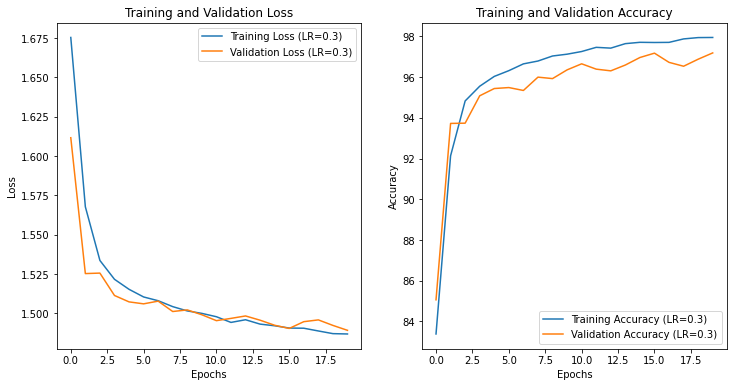

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 370.45it/s]


Epoch [1/20], Training Loss: 1.6488, Training Accuracy: 85.8542%, Validation Loss: 1.5514, Validation Accuracy: 91.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 374.53it/s]


Epoch [2/20], Training Loss: 1.5447, Training Accuracy: 94.0268%, Validation Loss: 1.5355, Validation Accuracy: 92.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:03<00:00, 347.51it/s]


Epoch [3/20], Training Loss: 1.5292, Training Accuracy: 94.9643%, Validation Loss: 1.5163, Validation Accuracy: 94.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 362.41it/s]


Epoch [4/20], Training Loss: 1.5208, Training Accuracy: 95.5060%, Validation Loss: 1.5121, Validation Accuracy: 94.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 408.22it/s]


Epoch [5/20], Training Loss: 1.5161, Training Accuracy: 95.8750%, Validation Loss: 1.5050, Validation Accuracy: 95.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:03<00:00, 324.69it/s]


Epoch [6/20], Training Loss: 1.5123, Training Accuracy: 96.1310%, Validation Loss: 1.5034, Validation Accuracy: 95.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:03<00:00, 344.90it/s]


Epoch [7/20], Training Loss: 1.5072, Training Accuracy: 96.4702%, Validation Loss: 1.5025, Validation Accuracy: 95.8571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:03<00:00, 342.04it/s]


Epoch [8/20], Training Loss: 1.5034, Training Accuracy: 96.7530%, Validation Loss: 1.5007, Validation Accuracy: 96.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 365.69it/s]


Epoch [9/20], Training Loss: 1.5018, Training Accuracy: 96.8244%, Validation Loss: 1.4994, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 365.94it/s]


Epoch [10/20], Training Loss: 1.5011, Training Accuracy: 96.9643%, Validation Loss: 1.4995, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 362.79it/s]


Epoch [11/20], Training Loss: 1.4985, Training Accuracy: 97.2440%, Validation Loss: 1.4990, Validation Accuracy: 96.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 404.10it/s]


Epoch [12/20], Training Loss: 1.4951, Training Accuracy: 97.3304%, Validation Loss: 1.4979, Validation Accuracy: 96.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 397.93it/s]


Epoch [13/20], Training Loss: 1.4957, Training Accuracy: 97.4911%, Validation Loss: 1.4960, Validation Accuracy: 96.5833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 416.13it/s]


Epoch [14/20], Training Loss: 1.4938, Training Accuracy: 97.5208%, Validation Loss: 1.4951, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 378.16it/s]


Epoch [15/20], Training Loss: 1.4912, Training Accuracy: 97.6220%, Validation Loss: 1.4953, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 388.00it/s]


Epoch [16/20], Training Loss: 1.4906, Training Accuracy: 97.6756%, Validation Loss: 1.4931, Validation Accuracy: 96.8690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 404.62it/s]


Epoch [17/20], Training Loss: 1.4906, Training Accuracy: 97.8155%, Validation Loss: 1.4931, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 395.50it/s]


Epoch [18/20], Training Loss: 1.4896, Training Accuracy: 97.7917%, Validation Loss: 1.4931, Validation Accuracy: 96.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 411.41it/s]


Epoch [19/20], Training Loss: 1.4899, Training Accuracy: 97.9256%, Validation Loss: 1.4910, Validation Accuracy: 96.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 410.61it/s]


Epoch [20/20], Training Loss: 1.4866, Training Accuracy: 98.0417%, Validation Loss: 1.4921, Validation Accuracy: 96.9762%


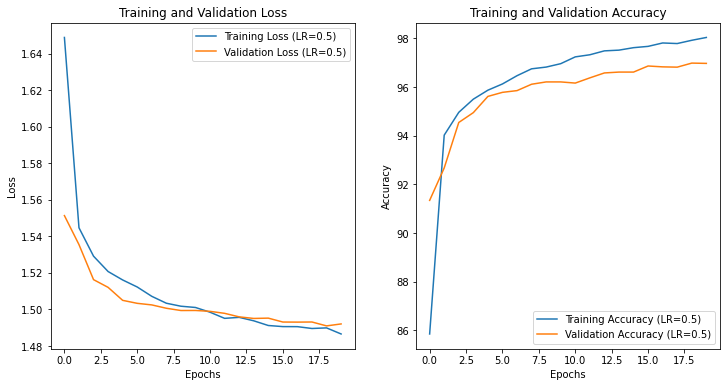

In [30]:
learning_rates = [0.0001, 0.001, 0.003, 0.01, 0.03, 0.05, 0.1, 0.3, 0.5]

# Initialize variables to keep track of the best model
best_model = None
best_val_accuracy = 0.0
best_hyperparameters = None

# Lists to store final metrics for each learning rate
final_train_losses = []
final_val_losses = []
final_train_accuracies = []
final_val_accuracies = []

for lr in learning_rates:
    # Instantiate the model
    model = Model(in_features, h1, h2, out_features)

    # Set a new learning rate
    model.optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-5)

    # Lists to store metrics for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        average_loss, train_accuracy = train(model, train_loader)
        train_loss_history.append(average_loss)
        train_acc_history.append(train_accuracy)

        # Validation
        average_val_loss, val_accuracy = validate(model, val_loader)
        val_loss_history.append(average_val_loss)
        val_acc_history.append(val_accuracy)

        # Print and visualize metrics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%')

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label=f'Training Loss (LR={lr})')
    plt.plot(val_loss_history, label=f'Validation Loss (LR={lr})')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label=f'Training Accuracy (LR={lr})')
    plt.plot(val_acc_history, label=f'Validation Accuracy (LR={lr})')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

    # Store final metrics for each learning rate
    final_train_losses.append(train_loss_history[-1])
    final_val_losses.append(val_loss_history[-1])
    final_train_accuracies.append(train_acc_history[-1])
    final_val_accuracies.append(val_acc_history[-1])

    # Check if current model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict().copy()
        best_hyperparameters = {'lr': lr}


## Show best model according to Learning rate

In [31]:
# Print the best hyperparameters
print("Best Hyperparameter:")
print(best_hyperparameters)

print("-----------------------")

# Print the best model
print("Best Model:")
print(best_model)

Best Hyperparameter:
{'lr': 0.05}
-----------------------
Best Model:
OrderedDict([('fc1.weight', tensor([[-0.0183,  0.0130, -0.0306,  ..., -0.0177, -0.0006,  0.0177],
        [ 0.0260,  0.0151, -0.0085,  ...,  0.0034,  0.0052, -0.0088],
        [-0.0296,  0.0152,  0.0012,  ...,  0.0128, -0.0221,  0.0280],
        ...,
        [-0.0132,  0.0269,  0.0037,  ...,  0.0250,  0.0064,  0.0296],
        [-0.0047, -0.0240,  0.0139,  ..., -0.0164,  0.0055,  0.0268],
        [-0.0238,  0.0274, -0.0251,  ..., -0.0168,  0.0109, -0.0216]])), ('fc1.bias', tensor([-0.0033,  0.0108, -0.0166,  0.0014,  0.0177, -0.0183, -0.0006,  0.0279,
         0.0169,  0.0174, -0.0016, -0.0148,  0.0198,  0.0310, -0.0136, -0.0140,
        -0.0228, -0.0154, -0.0253, -0.0300, -0.0277, -0.0180, -0.0252,  0.0127,
        -0.0176,  0.0176,  0.0004,  0.0162, -0.0239, -0.0159, -0.0212,  0.0305,
        -0.0008, -0.0011,  0.0070,  0.0245,  0.0036,  0.0336,  0.0351,  0.0312,
         0.0265, -0.0150,  0.0325, -0.0320,  0.0009, 

## Plot Effect of changing learning rates on the accuracy and loss

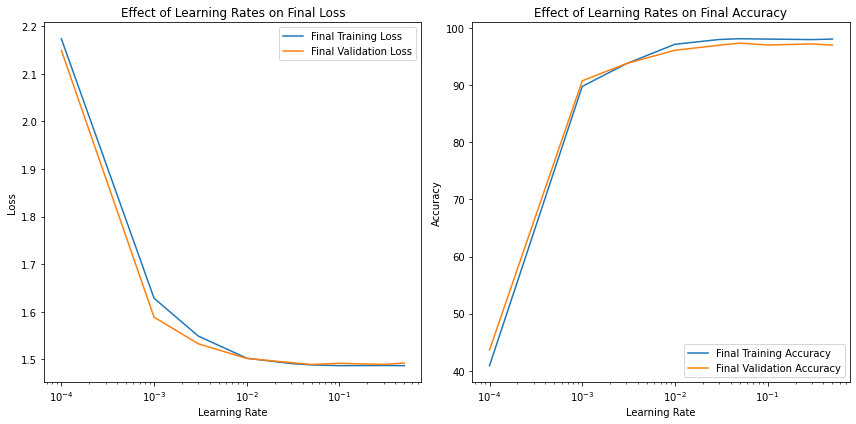

In [32]:
# Plot the effect of changing learning rates on final accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(learning_rates, final_train_losses, label='Final Training Loss')
plt.plot(learning_rates, final_val_losses, label='Final Validation Loss')
plt.title('Effect of Learning Rates on Final Loss')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')  # Use log scale for better visualization
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(learning_rates, final_train_accuracies, label='Final Training Accuracy')
plt.plot(learning_rates, final_val_accuracies, label='Final Validation Accuracy')
plt.title('Effect of Learning Rates on Final Accuracy')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale('log')  # Use log scale for better visualization
plt.legend()

plt.tight_layout()
plt.show()

## Customized Training Loop to try some different Batch sizes

Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 432.64it/s]


Epoch [1/20], Training Loss: 1.7421, Training Accuracy: 82.3810%, Validation Loss: 1.5572, Validation Accuracy: 91.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 423.21it/s]


Epoch [2/20], Training Loss: 1.5624, Training Accuracy: 94.2798%, Validation Loss: 1.5324, Validation Accuracy: 93.5238%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 456.33it/s]


Epoch [3/20], Training Loss: 1.5391, Training Accuracy: 95.1815%, Validation Loss: 1.5244, Validation Accuracy: 94.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 440.70it/s]


Epoch [4/20], Training Loss: 1.5279, Training Accuracy: 95.7530%, Validation Loss: 1.5169, Validation Accuracy: 94.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 439.22it/s]


Epoch [5/20], Training Loss: 1.5212, Training Accuracy: 96.2321%, Validation Loss: 1.5074, Validation Accuracy: 95.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 474.37it/s]


Epoch [6/20], Training Loss: 1.5155, Training Accuracy: 96.5387%, Validation Loss: 1.5113, Validation Accuracy: 95.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 464.72it/s]


Epoch [7/20], Training Loss: 1.5099, Training Accuracy: 96.7113%, Validation Loss: 1.5026, Validation Accuracy: 96.1310%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 432.46it/s]


Epoch [8/20], Training Loss: 1.5077, Training Accuracy: 97.0357%, Validation Loss: 1.5039, Validation Accuracy: 95.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 445.28it/s]


Epoch [9/20], Training Loss: 1.5050, Training Accuracy: 97.1726%, Validation Loss: 1.5029, Validation Accuracy: 95.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 447.40it/s]


Epoch [10/20], Training Loss: 1.5022, Training Accuracy: 97.2262%, Validation Loss: 1.5014, Validation Accuracy: 96.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 481.59it/s]


Epoch [11/20], Training Loss: 1.4999, Training Accuracy: 97.3482%, Validation Loss: 1.5005, Validation Accuracy: 96.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.03it/s]


Epoch [12/20], Training Loss: 1.4981, Training Accuracy: 97.4345%, Validation Loss: 1.4985, Validation Accuracy: 96.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 472.27it/s]


Epoch [13/20], Training Loss: 1.4968, Training Accuracy: 97.6161%, Validation Loss: 1.4955, Validation Accuracy: 96.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 469.68it/s]


Epoch [14/20], Training Loss: 1.4961, Training Accuracy: 97.7232%, Validation Loss: 1.4990, Validation Accuracy: 96.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 464.10it/s]


Epoch [15/20], Training Loss: 1.4937, Training Accuracy: 97.8095%, Validation Loss: 1.4956, Validation Accuracy: 96.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.52it/s]


Epoch [16/20], Training Loss: 1.4916, Training Accuracy: 97.9048%, Validation Loss: 1.4959, Validation Accuracy: 96.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.25it/s]


Epoch [17/20], Training Loss: 1.4921, Training Accuracy: 97.9167%, Validation Loss: 1.4925, Validation Accuracy: 96.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.28it/s]


Epoch [18/20], Training Loss: 1.4903, Training Accuracy: 97.9226%, Validation Loss: 1.4922, Validation Accuracy: 96.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 479.30it/s]


Epoch [19/20], Training Loss: 1.4905, Training Accuracy: 98.0268%, Validation Loss: 1.4923, Validation Accuracy: 96.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 483.71it/s]


Epoch [20/20], Training Loss: 1.4883, Training Accuracy: 98.1637%, Validation Loss: 1.4919, Validation Accuracy: 96.9286%


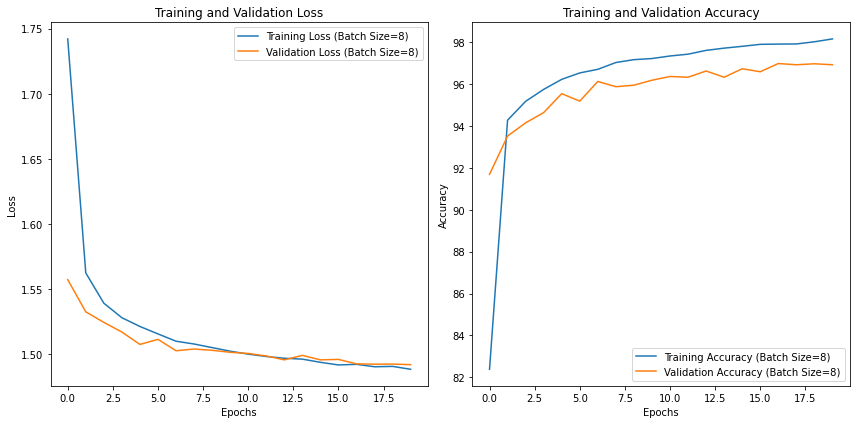

Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.81it/s]


Epoch [1/20], Training Loss: 1.8884, Training Accuracy: 68.5298%, Validation Loss: 1.6723, Validation Accuracy: 81.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 464.20it/s]


Epoch [2/20], Training Loss: 1.6245, Training Accuracy: 89.7976%, Validation Loss: 1.5527, Validation Accuracy: 92.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 471.86it/s]


Epoch [3/20], Training Loss: 1.5640, Training Accuracy: 93.7292%, Validation Loss: 1.5367, Validation Accuracy: 93.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.91it/s]


Epoch [4/20], Training Loss: 1.5474, Training Accuracy: 94.6607%, Validation Loss: 1.5290, Validation Accuracy: 93.8095%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.48it/s]


Epoch [5/20], Training Loss: 1.5360, Training Accuracy: 95.0298%, Validation Loss: 1.5196, Validation Accuracy: 94.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.19it/s]


Epoch [6/20], Training Loss: 1.5287, Training Accuracy: 95.7411%, Validation Loss: 1.5169, Validation Accuracy: 94.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.79it/s]


Epoch [7/20], Training Loss: 1.5223, Training Accuracy: 95.9107%, Validation Loss: 1.5128, Validation Accuracy: 95.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.41it/s]


Epoch [8/20], Training Loss: 1.5186, Training Accuracy: 96.2381%, Validation Loss: 1.5109, Validation Accuracy: 95.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 470.21it/s]


Epoch [9/20], Training Loss: 1.5143, Training Accuracy: 96.5030%, Validation Loss: 1.5059, Validation Accuracy: 95.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.35it/s]


Epoch [10/20], Training Loss: 1.5112, Training Accuracy: 96.7083%, Validation Loss: 1.5071, Validation Accuracy: 95.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.63it/s]


Epoch [11/20], Training Loss: 1.5087, Training Accuracy: 96.8065%, Validation Loss: 1.5037, Validation Accuracy: 96.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.91it/s]


Epoch [12/20], Training Loss: 1.5064, Training Accuracy: 96.9673%, Validation Loss: 1.5022, Validation Accuracy: 96.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 466.02it/s]


Epoch [13/20], Training Loss: 1.5043, Training Accuracy: 97.2679%, Validation Loss: 1.5006, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 461.45it/s]


Epoch [14/20], Training Loss: 1.5015, Training Accuracy: 97.2202%, Validation Loss: 1.5013, Validation Accuracy: 96.1310%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 466.33it/s]


Epoch [15/20], Training Loss: 1.4998, Training Accuracy: 97.4435%, Validation Loss: 1.4977, Validation Accuracy: 96.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.65it/s]


Epoch [16/20], Training Loss: 1.4984, Training Accuracy: 97.5000%, Validation Loss: 1.4987, Validation Accuracy: 96.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 462.77it/s]


Epoch [17/20], Training Loss: 1.4980, Training Accuracy: 97.5952%, Validation Loss: 1.4982, Validation Accuracy: 96.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.26it/s]


Epoch [18/20], Training Loss: 1.4963, Training Accuracy: 97.5833%, Validation Loss: 1.4958, Validation Accuracy: 96.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.03it/s]


Epoch [19/20], Training Loss: 1.4946, Training Accuracy: 97.6429%, Validation Loss: 1.4951, Validation Accuracy: 96.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.77it/s]


Epoch [20/20], Training Loss: 1.4948, Training Accuracy: 97.7202%, Validation Loss: 1.4945, Validation Accuracy: 96.8571%


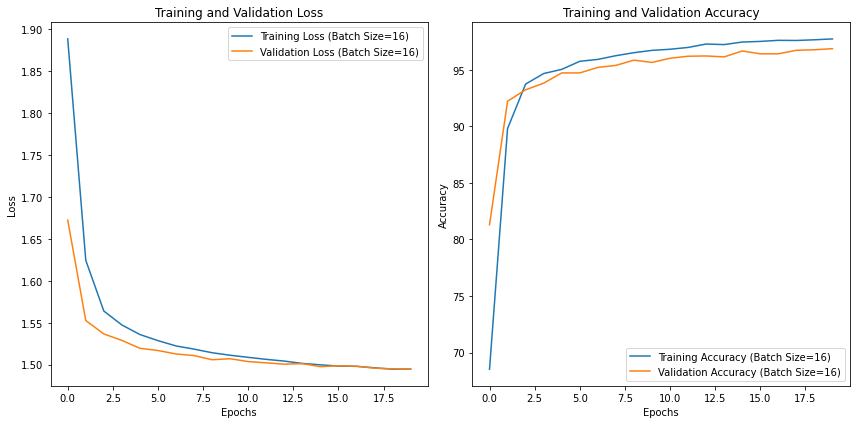

Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.00it/s]


Epoch [1/20], Training Loss: 2.0204, Training Accuracy: 55.8304%, Validation Loss: 1.8077, Validation Accuracy: 68.4881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.55it/s]


Epoch [2/20], Training Loss: 1.7382, Training Accuracy: 81.3095%, Validation Loss: 1.6132, Validation Accuracy: 89.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.86it/s]


Epoch [3/20], Training Loss: 1.6177, Training Accuracy: 90.6042%, Validation Loss: 1.5629, Validation Accuracy: 91.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.01it/s]


Epoch [4/20], Training Loss: 1.5807, Training Accuracy: 92.6101%, Validation Loss: 1.5453, Validation Accuracy: 92.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.52it/s]


Epoch [5/20], Training Loss: 1.5623, Training Accuracy: 93.3393%, Validation Loss: 1.5366, Validation Accuracy: 93.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 450.03it/s]


Epoch [6/20], Training Loss: 1.5509, Training Accuracy: 94.0238%, Validation Loss: 1.5276, Validation Accuracy: 94.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.39it/s]


Epoch [7/20], Training Loss: 1.5431, Training Accuracy: 94.5923%, Validation Loss: 1.5245, Validation Accuracy: 94.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.47it/s]


Epoch [8/20], Training Loss: 1.5362, Training Accuracy: 95.0893%, Validation Loss: 1.5204, Validation Accuracy: 94.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.04it/s]


Epoch [9/20], Training Loss: 1.5314, Training Accuracy: 95.2798%, Validation Loss: 1.5176, Validation Accuracy: 94.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.35it/s]


Epoch [10/20], Training Loss: 1.5275, Training Accuracy: 95.4435%, Validation Loss: 1.5153, Validation Accuracy: 95.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.51it/s]


Epoch [11/20], Training Loss: 1.5223, Training Accuracy: 95.8363%, Validation Loss: 1.5115, Validation Accuracy: 95.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.20it/s]


Epoch [12/20], Training Loss: 1.5199, Training Accuracy: 96.0952%, Validation Loss: 1.5101, Validation Accuracy: 95.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.76it/s]


Epoch [13/20], Training Loss: 1.5167, Training Accuracy: 96.1637%, Validation Loss: 1.5085, Validation Accuracy: 95.5357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.77it/s]


Epoch [14/20], Training Loss: 1.5148, Training Accuracy: 96.4315%, Validation Loss: 1.5064, Validation Accuracy: 95.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.66it/s]


Epoch [15/20], Training Loss: 1.5120, Training Accuracy: 96.5446%, Validation Loss: 1.5048, Validation Accuracy: 95.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.61it/s]


Epoch [16/20], Training Loss: 1.5099, Training Accuracy: 96.4881%, Validation Loss: 1.5049, Validation Accuracy: 95.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.16it/s]


Epoch [17/20], Training Loss: 1.5065, Training Accuracy: 96.6964%, Validation Loss: 1.5024, Validation Accuracy: 96.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.92it/s]


Epoch [18/20], Training Loss: 1.5066, Training Accuracy: 96.8214%, Validation Loss: 1.5012, Validation Accuracy: 96.2857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.44it/s]


Epoch [19/20], Training Loss: 1.5052, Training Accuracy: 96.9881%, Validation Loss: 1.5028, Validation Accuracy: 96.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.97it/s]


Epoch [20/20], Training Loss: 1.5026, Training Accuracy: 97.0179%, Validation Loss: 1.5012, Validation Accuracy: 96.1786%


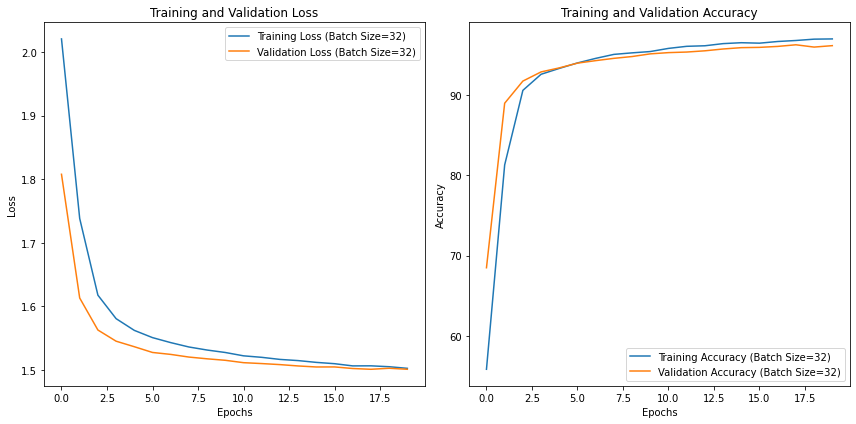

Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 367.86it/s]


Epoch [1/20], Training Loss: 2.1476, Training Accuracy: 49.8512%, Validation Loss: 1.9361, Validation Accuracy: 65.6190%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.81it/s]


Epoch [2/20], Training Loss: 1.8698, Training Accuracy: 72.1399%, Validation Loss: 1.7399, Validation Accuracy: 81.0119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.93it/s]


Epoch [3/20], Training Loss: 1.7337, Training Accuracy: 81.7202%, Validation Loss: 1.6632, Validation Accuracy: 83.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.66it/s]


Epoch [4/20], Training Loss: 1.6804, Training Accuracy: 83.4345%, Validation Loss: 1.6396, Validation Accuracy: 84.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.32it/s]


Epoch [5/20], Training Loss: 1.6574, Training Accuracy: 84.2202%, Validation Loss: 1.6269, Validation Accuracy: 84.6548%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.39it/s]


Epoch [6/20], Training Loss: 1.6430, Training Accuracy: 84.9077%, Validation Loss: 1.6146, Validation Accuracy: 85.8452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 370.71it/s]


Epoch [7/20], Training Loss: 1.6203, Training Accuracy: 87.9345%, Validation Loss: 1.5770, Validation Accuracy: 90.6310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.59it/s]


Epoch [8/20], Training Loss: 1.5880, Training Accuracy: 91.6458%, Validation Loss: 1.5570, Validation Accuracy: 92.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 354.72it/s]


Epoch [9/20], Training Loss: 1.5728, Training Accuracy: 92.5655%, Validation Loss: 1.5468, Validation Accuracy: 92.8690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 356.40it/s]


Epoch [10/20], Training Loss: 1.5630, Training Accuracy: 92.9613%, Validation Loss: 1.5411, Validation Accuracy: 92.9524%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 360.06it/s]


Epoch [11/20], Training Loss: 1.5552, Training Accuracy: 93.5387%, Validation Loss: 1.5363, Validation Accuracy: 93.5000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 359.05it/s]


Epoch [12/20], Training Loss: 1.5481, Training Accuracy: 93.8958%, Validation Loss: 1.5322, Validation Accuracy: 93.6310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.07it/s]


Epoch [13/20], Training Loss: 1.5445, Training Accuracy: 94.2500%, Validation Loss: 1.5299, Validation Accuracy: 93.8333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 353.68it/s]


Epoch [14/20], Training Loss: 1.5409, Training Accuracy: 94.4286%, Validation Loss: 1.5271, Validation Accuracy: 94.1071%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.41it/s]


Epoch [15/20], Training Loss: 1.5370, Training Accuracy: 94.7411%, Validation Loss: 1.5248, Validation Accuracy: 94.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.04it/s]


Epoch [16/20], Training Loss: 1.5341, Training Accuracy: 94.7679%, Validation Loss: 1.5221, Validation Accuracy: 94.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.29it/s]


Epoch [17/20], Training Loss: 1.5301, Training Accuracy: 95.0536%, Validation Loss: 1.5208, Validation Accuracy: 94.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.67it/s]


Epoch [18/20], Training Loss: 1.5284, Training Accuracy: 95.1845%, Validation Loss: 1.5209, Validation Accuracy: 94.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 365.30it/s]


Epoch [19/20], Training Loss: 1.5260, Training Accuracy: 95.2857%, Validation Loss: 1.5174, Validation Accuracy: 94.8214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 368.11it/s]


Epoch [20/20], Training Loss: 1.5241, Training Accuracy: 95.5774%, Validation Loss: 1.5159, Validation Accuracy: 94.9524%


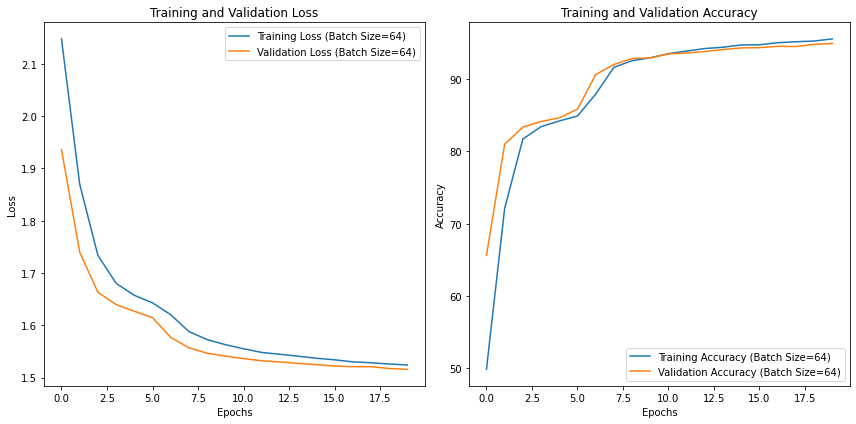

Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.94it/s]


Epoch [1/20], Training Loss: 2.2389, Training Accuracy: 35.2262%, Validation Loss: 2.1297, Validation Accuracy: 60.0238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 275.55it/s]


Epoch [2/20], Training Loss: 2.0591, Training Accuracy: 61.7381%, Validation Loss: 1.9308, Validation Accuracy: 68.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 275.55it/s]


Epoch [3/20], Training Loss: 1.9080, Training Accuracy: 72.0030%, Validation Loss: 1.7992, Validation Accuracy: 80.9881%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 279.35it/s]


Epoch [4/20], Training Loss: 1.7985, Training Accuracy: 81.8155%, Validation Loss: 1.7043, Validation Accuracy: 86.4048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.83it/s]


Epoch [5/20], Training Loss: 1.7240, Training Accuracy: 85.7738%, Validation Loss: 1.6480, Validation Accuracy: 88.5000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.58it/s]


Epoch [6/20], Training Loss: 1.6754, Training Accuracy: 87.9851%, Validation Loss: 1.6144, Validation Accuracy: 89.8810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.42it/s]


Epoch [7/20], Training Loss: 1.6443, Training Accuracy: 89.3036%, Validation Loss: 1.5932, Validation Accuracy: 90.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.54it/s]


Epoch [8/20], Training Loss: 1.6242, Training Accuracy: 90.0655%, Validation Loss: 1.5792, Validation Accuracy: 91.2143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.83it/s]


Epoch [9/20], Training Loss: 1.6081, Training Accuracy: 90.7440%, Validation Loss: 1.5698, Validation Accuracy: 91.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.66it/s]


Epoch [10/20], Training Loss: 1.5965, Training Accuracy: 91.2649%, Validation Loss: 1.5624, Validation Accuracy: 92.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.13it/s]


Epoch [11/20], Training Loss: 1.5881, Training Accuracy: 91.5804%, Validation Loss: 1.5559, Validation Accuracy: 92.2381%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.13it/s]


Epoch [12/20], Training Loss: 1.5804, Training Accuracy: 91.9345%, Validation Loss: 1.5507, Validation Accuracy: 92.5952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.17it/s]


Epoch [13/20], Training Loss: 1.5735, Training Accuracy: 92.3869%, Validation Loss: 1.5471, Validation Accuracy: 92.9048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.49it/s]


Epoch [14/20], Training Loss: 1.5690, Training Accuracy: 92.6607%, Validation Loss: 1.5432, Validation Accuracy: 93.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.53it/s]


Epoch [15/20], Training Loss: 1.5639, Training Accuracy: 92.8482%, Validation Loss: 1.5411, Validation Accuracy: 93.1071%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 279.35it/s]


Epoch [16/20], Training Loss: 1.5605, Training Accuracy: 93.1905%, Validation Loss: 1.5386, Validation Accuracy: 93.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.58it/s]


Epoch [17/20], Training Loss: 1.5559, Training Accuracy: 93.3304%, Validation Loss: 1.5355, Validation Accuracy: 93.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 282.94it/s]


Epoch [18/20], Training Loss: 1.5527, Training Accuracy: 93.6101%, Validation Loss: 1.5330, Validation Accuracy: 93.7024%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.76it/s]


Epoch [19/20], Training Loss: 1.5505, Training Accuracy: 93.6488%, Validation Loss: 1.5315, Validation Accuracy: 93.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.24it/s]


Epoch [20/20], Training Loss: 1.5468, Training Accuracy: 93.8274%, Validation Loss: 1.5296, Validation Accuracy: 93.9643%


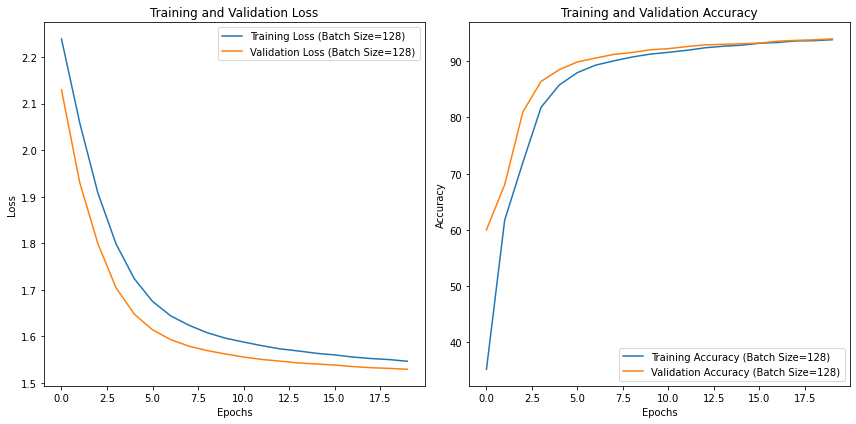

Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.10it/s]


Epoch [1/20], Training Loss: 2.2682, Training Accuracy: 26.5119%, Validation Loss: 2.2103, Validation Accuracy: 43.7619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.08it/s]


Epoch [2/20], Training Loss: 2.1786, Training Accuracy: 47.4583%, Validation Loss: 2.1058, Validation Accuracy: 57.5952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 211.09it/s]


Epoch [3/20], Training Loss: 2.0903, Training Accuracy: 58.6369%, Validation Loss: 2.0135, Validation Accuracy: 67.2738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 206.48it/s]


Epoch [4/20], Training Loss: 2.0099, Training Accuracy: 66.5685%, Validation Loss: 1.9290, Validation Accuracy: 73.3929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 206.16it/s]


Epoch [5/20], Training Loss: 1.9364, Training Accuracy: 72.3155%, Validation Loss: 1.8560, Validation Accuracy: 76.6429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.47it/s]


Epoch [6/20], Training Loss: 1.8731, Training Accuracy: 75.4673%, Validation Loss: 1.7979, Validation Accuracy: 79.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.75it/s]


Epoch [7/20], Training Loss: 1.8214, Training Accuracy: 78.1756%, Validation Loss: 1.7533, Validation Accuracy: 80.8810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.75it/s]


Epoch [8/20], Training Loss: 1.7814, Training Accuracy: 79.8869%, Validation Loss: 1.7204, Validation Accuracy: 81.8690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.42it/s]


Epoch [9/20], Training Loss: 1.7517, Training Accuracy: 80.7738%, Validation Loss: 1.6967, Validation Accuracy: 82.3929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 207.45it/s]


Epoch [10/20], Training Loss: 1.7293, Training Accuracy: 81.5417%, Validation Loss: 1.6803, Validation Accuracy: 83.0119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.09it/s]


Epoch [11/20], Training Loss: 1.7121, Training Accuracy: 82.0149%, Validation Loss: 1.6684, Validation Accuracy: 83.3571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.75it/s]


Epoch [12/20], Training Loss: 1.6992, Training Accuracy: 82.5000%, Validation Loss: 1.6596, Validation Accuracy: 83.3810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 209.95it/s]


Epoch [13/20], Training Loss: 1.6881, Training Accuracy: 82.8155%, Validation Loss: 1.6520, Validation Accuracy: 83.7381%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.79it/s]


Epoch [14/20], Training Loss: 1.6801, Training Accuracy: 83.1607%, Validation Loss: 1.6465, Validation Accuracy: 83.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 210.08it/s]


Epoch [15/20], Training Loss: 1.6719, Training Accuracy: 83.3690%, Validation Loss: 1.6417, Validation Accuracy: 84.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 211.09it/s]


Epoch [16/20], Training Loss: 1.6650, Training Accuracy: 83.5625%, Validation Loss: 1.6379, Validation Accuracy: 84.1310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 208.76it/s]


Epoch [17/20], Training Loss: 1.6601, Training Accuracy: 84.0744%, Validation Loss: 1.6341, Validation Accuracy: 84.3095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 207.13it/s]


Epoch [18/20], Training Loss: 1.6578, Training Accuracy: 83.9851%, Validation Loss: 1.6307, Validation Accuracy: 84.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 205.84it/s]


Epoch [19/20], Training Loss: 1.6521, Training Accuracy: 84.1012%, Validation Loss: 1.6284, Validation Accuracy: 84.4643%


Training: 100%|█████████████████████████████████████████████████████████████████████| 132/132 [00:00<00:00, 212.33it/s]


Epoch [20/20], Training Loss: 1.6482, Training Accuracy: 84.2411%, Validation Loss: 1.6255, Validation Accuracy: 84.7500%


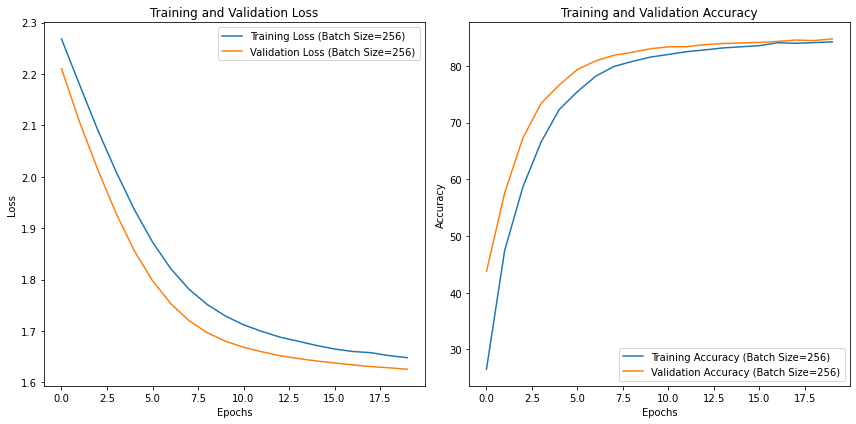

Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 92.43it/s]


Epoch [1/20], Training Loss: 2.2960, Training Accuracy: 12.2321%, Validation Loss: 2.2859, Validation Accuracy: 19.3571%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 99.66it/s]


Epoch [2/20], Training Loss: 2.2784, Training Accuracy: 21.9018%, Validation Loss: 2.2620, Validation Accuracy: 29.6429%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 98.18it/s]


Epoch [3/20], Training Loss: 2.2578, Training Accuracy: 30.1845%, Validation Loss: 2.2378, Validation Accuracy: 38.8214%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 93.21it/s]


Epoch [4/20], Training Loss: 2.2366, Training Accuracy: 35.8661%, Validation Loss: 2.2136, Validation Accuracy: 42.4286%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 91.15it/s]


Epoch [5/20], Training Loss: 2.2151, Training Accuracy: 39.0595%, Validation Loss: 2.1890, Validation Accuracy: 44.4881%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 95.63it/s]


Epoch [6/20], Training Loss: 2.1940, Training Accuracy: 41.5417%, Validation Loss: 2.1647, Validation Accuracy: 46.3690%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 93.47it/s]


Epoch [7/20], Training Loss: 2.1728, Training Accuracy: 43.6518%, Validation Loss: 2.1415, Validation Accuracy: 48.0476%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 99.36it/s]


Epoch [8/20], Training Loss: 2.1517, Training Accuracy: 45.2589%, Validation Loss: 2.1194, Validation Accuracy: 49.5833%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 99.96it/s]


Epoch [9/20], Training Loss: 2.1337, Training Accuracy: 47.1280%, Validation Loss: 2.0987, Validation Accuracy: 51.6786%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 98.48it/s]


Epoch [10/20], Training Loss: 2.1146, Training Accuracy: 48.9286%, Validation Loss: 2.0789, Validation Accuracy: 53.7738%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 93.47it/s]


Epoch [11/20], Training Loss: 2.0970, Training Accuracy: 51.3512%, Validation Loss: 2.0598, Validation Accuracy: 56.0595%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 97.03it/s]


Epoch [12/20], Training Loss: 2.0798, Training Accuracy: 53.6637%, Validation Loss: 2.0410, Validation Accuracy: 59.0238%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 98.48it/s]


Epoch [13/20], Training Loss: 2.0630, Training Accuracy: 56.1935%, Validation Loss: 2.0222, Validation Accuracy: 61.9643%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 92.17it/s]


Epoch [14/20], Training Loss: 2.0451, Training Accuracy: 58.9702%, Validation Loss: 2.0031, Validation Accuracy: 64.5952%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 91.66it/s]


Epoch [15/20], Training Loss: 2.0275, Training Accuracy: 61.4821%, Validation Loss: 1.9836, Validation Accuracy: 66.5714%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 97.32it/s]


Epoch [16/20], Training Loss: 2.0093, Training Accuracy: 63.3958%, Validation Loss: 1.9636, Validation Accuracy: 68.3929%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 96.19it/s]


Epoch [17/20], Training Loss: 1.9914, Training Accuracy: 65.5655%, Validation Loss: 1.9435, Validation Accuracy: 69.6429%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 61.16it/s]


Epoch [18/20], Training Loss: 1.9728, Training Accuracy: 67.0476%, Validation Loss: 1.9235, Validation Accuracy: 70.6071%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 97.61it/s]


Epoch [19/20], Training Loss: 1.9536, Training Accuracy: 68.1131%, Validation Loss: 1.9040, Validation Accuracy: 71.8214%


Training: 100%|████████████████████████████████████████████████████████████████████████| 33/33 [00:00<00:00, 94.00it/s]


Epoch [20/20], Training Loss: 1.9363, Training Accuracy: 69.2589%, Validation Loss: 1.8856, Validation Accuracy: 72.6429%


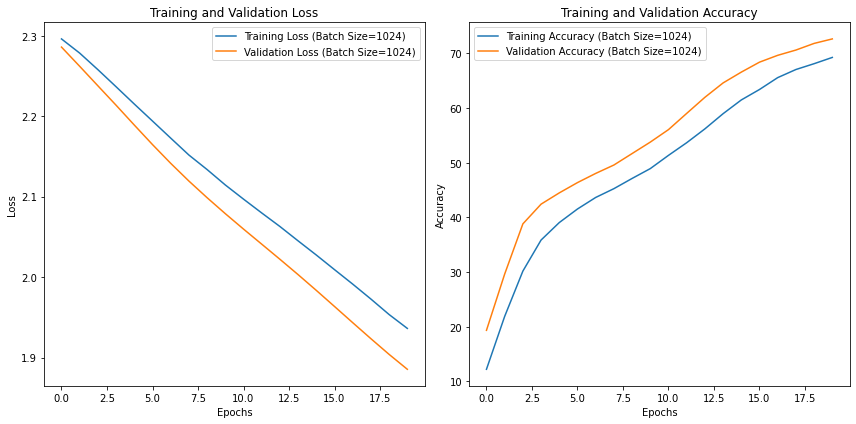

In [33]:
batch_sizes = [8, 16, 32, 64, 128, 256, 1024]

# Lists to store final metrics for each batch size
final_train_losses = []
final_val_losses = []
final_train_accuracies = []
final_val_accuracies = []

# Initialize variables to keep track of the best model
best_model = None
best_val_accuracy = 0.0
best_hyperparameters = None

for batch_size in batch_sizes:
    # Create data loaders with the new batch size
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    # Instantiate the model
    model = Model(in_features, h1, h2, out_features)

    # Set a new learning rate
    optimizer = optim.SGD(model.parameters(), lr=0.01, weight_decay=1e-5)

    # Lists to store metrics for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        average_loss, train_accuracy = train(model, train_loader)
        train_loss_history.append(average_loss)
        train_acc_history.append(train_accuracy)

        # Validation
        average_val_loss, val_accuracy = validate(model, val_loader)
        val_loss_history.append(average_val_loss)
        val_acc_history.append(val_accuracy)

        # Print and visualize metrics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%')

    # Plot training and validation loss    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, label=f'Training Loss (Batch Size={batch_size})')
    plt.plot(val_loss_history, label=f'Validation Loss (Batch Size={batch_size})')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot training and validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_acc_history, label=f'Training Accuracy (Batch Size={batch_size})')
    plt.plot(val_acc_history, label=f'Validation Accuracy (Batch Size={batch_size})')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

    # Store final metrics for each batch size
    final_train_losses.append(train_loss_history[-1])
    final_val_losses.append(val_loss_history[-1])
    final_train_accuracies.append(train_acc_history[-1])
    final_val_accuracies.append(val_acc_history[-1])

    # Check if current model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict().copy()
        best_hyperparameters = {'batch_size': batch_size}


## Show best model according to Batch size

In [34]:
# Print the best hyperparameters
print("Best Hyperparameters:")
print(best_hyperparameters)

# Print the best model
print("Best Model:")
print(best_model)

Best Hyperparameters:
{'batch_size': 8}
Best Model:
OrderedDict([('fc1.weight', tensor([[ 0.0235,  0.0055,  0.0338,  ...,  0.0154,  0.0117,  0.0190],
        [ 0.0020,  0.0048,  0.0262,  ..., -0.0151,  0.0286, -0.0057],
        [-0.0312,  0.0095, -0.0091,  ...,  0.0035,  0.0339,  0.0215],
        ...,
        [ 0.0156, -0.0300,  0.0063,  ...,  0.0328,  0.0350, -0.0097],
        [ 0.0182,  0.0123,  0.0135,  ...,  0.0283, -0.0331, -0.0211],
        [-0.0223, -0.0011,  0.0023,  ..., -0.0332,  0.0161, -0.0238]])), ('fc1.bias', tensor([-2.0023e-02,  1.5080e-03, -8.4792e-03,  3.4937e-02, -2.6961e-02,
         5.3109e-03,  8.3756e-03,  9.9554e-03,  4.1020e-03, -8.6610e-03,
         4.3383e-03, -3.3636e-02,  2.5909e-02, -2.1693e-02, -6.4318e-03,
        -1.8942e-02,  1.0250e-02, -1.8895e-02, -2.4110e-02, -2.2429e-02,
        -1.1774e-02, -2.1996e-02,  6.4330e-03, -1.4313e-03,  2.2289e-02,
        -3.4671e-03, -1.7575e-02, -1.7216e-02,  7.7502e-03,  8.6911e-04,
         7.7260e-03,  1.5217e-02,

## Plot Effect of changing batch size on the accuracy and loss

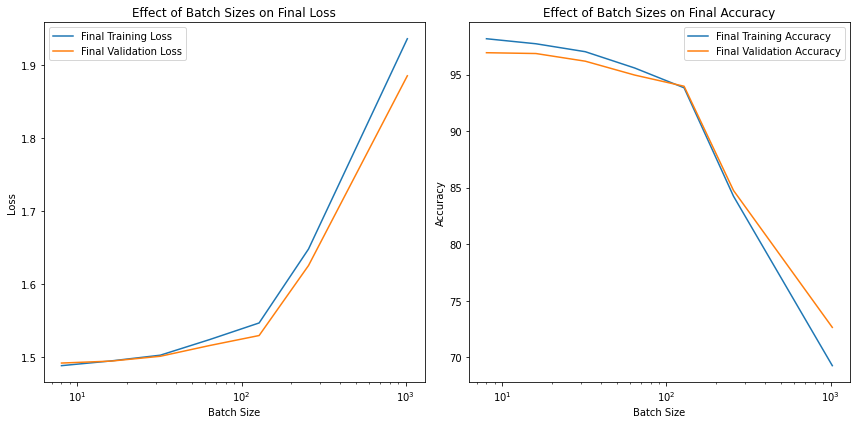

In [35]:
# Plot the effect of changing batch sizes on final accuracy and loss
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, final_train_losses, label='Final Training Loss')
plt.plot(batch_sizes, final_val_losses, label='Final Validation Loss')
plt.title('Effect of Batch Sizes on Final Loss')
plt.xlabel('Batch Size')
plt.ylabel('Loss')
plt.xscale('log')  # Use log scale for better visualization
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, final_train_accuracies, label='Final Training Accuracy')
plt.plot(batch_sizes, final_val_accuracies, label='Final Validation Accuracy')
plt.title('Effect of Batch Sizes on Final Accuracy')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.xscale('log')  # Use log scale for better visualization
plt.legend()

plt.tight_layout()
plt.show()


## get best  model (choose best model according to learning rate and batch size together)

In [37]:
from itertools import product

# Define the hyperparameter grid
param_grid = {
    'lr': [0.001, 0.01, 0.03, 0.05, 0.1, 0.5],
    'batch_size': [8, 16, 32, 64, 128],
}

# Initialize variables to keep track of the best model
best_model = None
best_val_accuracy = 0.0
best_hyperparameters = None

# Iterate over all combinations of hyperparameters
for params in product(*param_grid.values()):
    hyperparameters = dict(zip(param_grid.keys(), params))

    # Create data loaders with the specified batch size
    train_loader = DataLoader(train_set, batch_size=hyperparameters['batch_size'], shuffle=True)
    val_loader = DataLoader(val_set, batch_size=hyperparameters['batch_size'], shuffle=False)

    # Instantiate the model
    model = model = Model(in_features, h1, h2, out_features)

    # Set a new learning rate
    model.optimizer = optim.SGD(model.parameters(), lr=hyperparameters['lr'], weight_decay=1e-5)

    # Lists to store metrics for plotting
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    # Training loop
    for epoch in range(num_epochs):
        # Training
        average_loss, train_accuracy = train(model, train_loader)
        train_loss_history.append(average_loss)
        train_acc_history.append(train_accuracy)

        # Validation
        average_val_loss, val_accuracy = validate(model, val_loader)
        val_loss_history.append(average_val_loss)
        val_acc_history.append(val_accuracy)

        # Print and visualize metrics
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {average_loss:.4f}, Training Accuracy: {train_accuracy:.4f}%, '
              f'Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}%')

    # Check if current model has the best validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = model.state_dict().copy()
        best_hyperparameters = hyperparameters

Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 460.69it/s]


Epoch [1/20], Training Loss: 2.1794, Training Accuracy: 45.6726%, Validation Loss: 1.9927, Validation Accuracy: 68.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 446.62it/s]


Epoch [2/20], Training Loss: 1.9209, Training Accuracy: 69.9464%, Validation Loss: 1.7976, Validation Accuracy: 74.4286%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.46it/s]


Epoch [3/20], Training Loss: 1.7962, Training Accuracy: 74.4613%, Validation Loss: 1.7188, Validation Accuracy: 79.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.66it/s]


Epoch [4/20], Training Loss: 1.7172, Training Accuracy: 83.2321%, Validation Loss: 1.6385, Validation Accuracy: 88.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.21it/s]


Epoch [5/20], Training Loss: 1.6545, Training Accuracy: 88.3423%, Validation Loss: 1.5950, Validation Accuracy: 90.5357%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.13it/s]


Epoch [6/20], Training Loss: 1.6191, Training Accuracy: 90.1042%, Validation Loss: 1.5751, Validation Accuracy: 91.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.77it/s]


Epoch [7/20], Training Loss: 1.6005, Training Accuracy: 91.2024%, Validation Loss: 1.5630, Validation Accuracy: 91.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.85it/s]


Epoch [8/20], Training Loss: 1.5845, Training Accuracy: 91.8810%, Validation Loss: 1.5541, Validation Accuracy: 92.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.92it/s]


Epoch [9/20], Training Loss: 1.5752, Training Accuracy: 92.2976%, Validation Loss: 1.5473, Validation Accuracy: 92.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 481.24it/s]


Epoch [10/20], Training Loss: 1.5654, Training Accuracy: 92.8423%, Validation Loss: 1.5420, Validation Accuracy: 93.1310%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 473.76it/s]


Epoch [11/20], Training Loss: 1.5596, Training Accuracy: 93.1518%, Validation Loss: 1.5384, Validation Accuracy: 93.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.11it/s]


Epoch [12/20], Training Loss: 1.5546, Training Accuracy: 93.6071%, Validation Loss: 1.5343, Validation Accuracy: 93.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 493.22it/s]


Epoch [13/20], Training Loss: 1.5496, Training Accuracy: 93.8274%, Validation Loss: 1.5319, Validation Accuracy: 93.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.33it/s]


Epoch [14/20], Training Loss: 1.5455, Training Accuracy: 94.1726%, Validation Loss: 1.5292, Validation Accuracy: 94.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 491.66it/s]


Epoch [15/20], Training Loss: 1.5411, Training Accuracy: 94.3839%, Validation Loss: 1.5270, Validation Accuracy: 94.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 494.04it/s]


Epoch [16/20], Training Loss: 1.5387, Training Accuracy: 94.6815%, Validation Loss: 1.5251, Validation Accuracy: 94.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.50it/s]


Epoch [17/20], Training Loss: 1.5351, Training Accuracy: 94.7024%, Validation Loss: 1.5222, Validation Accuracy: 94.4881%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.48it/s]


Epoch [18/20], Training Loss: 1.5329, Training Accuracy: 94.9256%, Validation Loss: 1.5212, Validation Accuracy: 94.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 491.05it/s]


Epoch [19/20], Training Loss: 1.5290, Training Accuracy: 95.1042%, Validation Loss: 1.5198, Validation Accuracy: 94.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.92it/s]


Epoch [20/20], Training Loss: 1.5275, Training Accuracy: 95.1994%, Validation Loss: 1.5179, Validation Accuracy: 94.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.34it/s]


Epoch [1/20], Training Loss: 2.2556, Training Accuracy: 29.5804%, Validation Loss: 2.1726, Validation Accuracy: 56.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 455.20it/s]


Epoch [2/20], Training Loss: 2.1172, Training Accuracy: 59.0804%, Validation Loss: 1.9977, Validation Accuracy: 67.2738%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 406.78it/s]


Epoch [3/20], Training Loss: 1.9709, Training Accuracy: 68.2530%, Validation Loss: 1.8660, Validation Accuracy: 73.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.08it/s]


Epoch [4/20], Training Loss: 1.8675, Training Accuracy: 74.5714%, Validation Loss: 1.7798, Validation Accuracy: 79.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 463.83it/s]


Epoch [5/20], Training Loss: 1.7956, Training Accuracy: 79.0863%, Validation Loss: 1.7204, Validation Accuracy: 82.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.70it/s]


Epoch [6/20], Training Loss: 1.7451, Training Accuracy: 81.5119%, Validation Loss: 1.6832, Validation Accuracy: 83.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 464.93it/s]


Epoch [7/20], Training Loss: 1.7135, Training Accuracy: 83.1548%, Validation Loss: 1.6568, Validation Accuracy: 85.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 470.57it/s]


Epoch [8/20], Training Loss: 1.6847, Training Accuracy: 85.3244%, Validation Loss: 1.6303, Validation Accuracy: 88.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.98it/s]


Epoch [9/20], Training Loss: 1.6581, Training Accuracy: 87.8482%, Validation Loss: 1.6075, Validation Accuracy: 90.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 466.23it/s]


Epoch [10/20], Training Loss: 1.6381, Training Accuracy: 89.2411%, Validation Loss: 1.5918, Validation Accuracy: 90.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.92it/s]


Epoch [11/20], Training Loss: 1.6220, Training Accuracy: 89.9494%, Validation Loss: 1.5813, Validation Accuracy: 91.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.43it/s]


Epoch [12/20], Training Loss: 1.6089, Training Accuracy: 90.6071%, Validation Loss: 1.5729, Validation Accuracy: 91.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 471.54it/s]


Epoch [13/20], Training Loss: 1.6014, Training Accuracy: 90.8304%, Validation Loss: 1.5666, Validation Accuracy: 91.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.11it/s]


Epoch [14/20], Training Loss: 1.5929, Training Accuracy: 91.3244%, Validation Loss: 1.5609, Validation Accuracy: 91.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.76it/s]


Epoch [15/20], Training Loss: 1.5859, Training Accuracy: 91.6548%, Validation Loss: 1.5565, Validation Accuracy: 92.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.83it/s]


Epoch [16/20], Training Loss: 1.5797, Training Accuracy: 92.0208%, Validation Loss: 1.5527, Validation Accuracy: 92.4643%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 469.56it/s]


Epoch [17/20], Training Loss: 1.5747, Training Accuracy: 92.2173%, Validation Loss: 1.5495, Validation Accuracy: 92.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 466.46it/s]


Epoch [18/20], Training Loss: 1.5702, Training Accuracy: 92.5298%, Validation Loss: 1.5467, Validation Accuracy: 92.7738%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 471.07it/s]


Epoch [19/20], Training Loss: 1.5669, Training Accuracy: 92.6399%, Validation Loss: 1.5440, Validation Accuracy: 93.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 467.78it/s]


Epoch [20/20], Training Loss: 1.5621, Training Accuracy: 92.9048%, Validation Loss: 1.5415, Validation Accuracy: 93.1429%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.59it/s]


Epoch [1/20], Training Loss: 2.2811, Training Accuracy: 19.7113%, Validation Loss: 2.2440, Validation Accuracy: 32.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.16it/s]


Epoch [2/20], Training Loss: 2.2174, Training Accuracy: 36.7113%, Validation Loss: 2.1613, Validation Accuracy: 49.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.15it/s]


Epoch [3/20], Training Loss: 2.1471, Training Accuracy: 50.8244%, Validation Loss: 2.0836, Validation Accuracy: 61.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.60it/s]


Epoch [4/20], Training Loss: 2.0805, Training Accuracy: 58.9435%, Validation Loss: 2.0132, Validation Accuracy: 63.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 417.97it/s]


Epoch [5/20], Training Loss: 2.0203, Training Accuracy: 62.2143%, Validation Loss: 1.9540, Validation Accuracy: 65.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 408.19it/s]


Epoch [6/20], Training Loss: 1.9672, Training Accuracy: 65.4702%, Validation Loss: 1.9036, Validation Accuracy: 68.5595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 404.29it/s]


Epoch [7/20], Training Loss: 1.9222, Training Accuracy: 69.0536%, Validation Loss: 1.8587, Validation Accuracy: 73.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.06it/s]


Epoch [8/20], Training Loss: 1.8807, Training Accuracy: 73.4196%, Validation Loss: 1.8146, Validation Accuracy: 78.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.06it/s]


Epoch [9/20], Training Loss: 1.8388, Training Accuracy: 78.6935%, Validation Loss: 1.7694, Validation Accuracy: 83.7738%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.56it/s]


Epoch [10/20], Training Loss: 1.7963, Training Accuracy: 82.9792%, Validation Loss: 1.7270, Validation Accuracy: 86.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.06it/s]


Epoch [11/20], Training Loss: 1.7575, Training Accuracy: 84.9286%, Validation Loss: 1.6923, Validation Accuracy: 87.5119%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.45it/s]


Epoch [12/20], Training Loss: 1.7280, Training Accuracy: 86.3065%, Validation Loss: 1.6664, Validation Accuracy: 88.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.47it/s]


Epoch [13/20], Training Loss: 1.7041, Training Accuracy: 87.2738%, Validation Loss: 1.6461, Validation Accuracy: 89.0595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 440.99it/s]


Epoch [14/20], Training Loss: 1.6841, Training Accuracy: 87.7262%, Validation Loss: 1.6302, Validation Accuracy: 89.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.31it/s]


Epoch [15/20], Training Loss: 1.6680, Training Accuracy: 88.3423%, Validation Loss: 1.6176, Validation Accuracy: 90.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.68it/s]


Epoch [16/20], Training Loss: 1.6541, Training Accuracy: 88.9702%, Validation Loss: 1.6076, Validation Accuracy: 90.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.50it/s]


Epoch [17/20], Training Loss: 1.6444, Training Accuracy: 89.4107%, Validation Loss: 1.5988, Validation Accuracy: 90.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.06it/s]


Epoch [18/20], Training Loss: 1.6352, Training Accuracy: 89.6339%, Validation Loss: 1.5920, Validation Accuracy: 90.8690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.33it/s]


Epoch [19/20], Training Loss: 1.6255, Training Accuracy: 89.7887%, Validation Loss: 1.5861, Validation Accuracy: 91.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.46it/s]


Epoch [20/20], Training Loss: 1.6191, Training Accuracy: 90.0952%, Validation Loss: 1.5810, Validation Accuracy: 91.2738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 370.38it/s]


Epoch [1/20], Training Loss: 2.2991, Training Accuracy: 12.5060%, Validation Loss: 2.2859, Validation Accuracy: 23.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.69it/s]


Epoch [2/20], Training Loss: 2.2751, Training Accuracy: 24.3810%, Validation Loss: 2.2529, Validation Accuracy: 29.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 360.05it/s]


Epoch [3/20], Training Loss: 2.2453, Training Accuracy: 30.1071%, Validation Loss: 2.2169, Validation Accuracy: 34.3810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 368.84it/s]


Epoch [4/20], Training Loss: 2.2123, Training Accuracy: 35.2679%, Validation Loss: 2.1798, Validation Accuracy: 40.5833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.67it/s]


Epoch [5/20], Training Loss: 2.1806, Training Accuracy: 40.4196%, Validation Loss: 2.1439, Validation Accuracy: 46.2619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.19it/s]


Epoch [6/20], Training Loss: 2.1491, Training Accuracy: 45.0268%, Validation Loss: 2.1099, Validation Accuracy: 50.5952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.21it/s]


Epoch [7/20], Training Loss: 2.1192, Training Accuracy: 48.6845%, Validation Loss: 2.0778, Validation Accuracy: 54.6429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 370.51it/s]


Epoch [8/20], Training Loss: 2.0906, Training Accuracy: 52.4792%, Validation Loss: 2.0474, Validation Accuracy: 57.6548%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 360.24it/s]


Epoch [9/20], Training Loss: 2.0627, Training Accuracy: 55.4702%, Validation Loss: 2.0180, Validation Accuracy: 60.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 367.28it/s]


Epoch [10/20], Training Loss: 2.0360, Training Accuracy: 58.4375%, Validation Loss: 1.9891, Validation Accuracy: 63.6190%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.34it/s]


Epoch [11/20], Training Loss: 2.0091, Training Accuracy: 61.3542%, Validation Loss: 1.9605, Validation Accuracy: 66.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.11it/s]


Epoch [12/20], Training Loss: 1.9822, Training Accuracy: 63.6310%, Validation Loss: 1.9325, Validation Accuracy: 68.3452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.15it/s]


Epoch [13/20], Training Loss: 1.9564, Training Accuracy: 65.9405%, Validation Loss: 1.9056, Validation Accuracy: 70.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.60it/s]


Epoch [14/20], Training Loss: 1.9312, Training Accuracy: 68.7232%, Validation Loss: 1.8798, Validation Accuracy: 73.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 363.98it/s]


Epoch [15/20], Training Loss: 1.9088, Training Accuracy: 71.0923%, Validation Loss: 1.8549, Validation Accuracy: 75.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 277.38it/s]


Epoch [16/20], Training Loss: 1.8860, Training Accuracy: 73.3810%, Validation Loss: 1.8309, Validation Accuracy: 77.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 318.78it/s]


Epoch [17/20], Training Loss: 1.8633, Training Accuracy: 75.4107%, Validation Loss: 1.8080, Validation Accuracy: 79.2143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 340.32it/s]


Epoch [18/20], Training Loss: 1.8432, Training Accuracy: 77.0000%, Validation Loss: 1.7868, Validation Accuracy: 80.4286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 336.37it/s]


Epoch [19/20], Training Loss: 1.8244, Training Accuracy: 78.2173%, Validation Loss: 1.7678, Validation Accuracy: 81.0119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.10it/s]


Epoch [20/20], Training Loss: 1.8063, Training Accuracy: 78.8661%, Validation Loss: 1.7508, Validation Accuracy: 81.4405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.66it/s]


Epoch [1/20], Training Loss: 2.2981, Training Accuracy: 13.1935%, Validation Loss: 2.2916, Validation Accuracy: 19.4881%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 256.05it/s]


Epoch [2/20], Training Loss: 2.2875, Training Accuracy: 18.9524%, Validation Loss: 2.2780, Validation Accuracy: 25.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 251.21it/s]


Epoch [3/20], Training Loss: 2.2750, Training Accuracy: 25.4256%, Validation Loss: 2.2620, Validation Accuracy: 32.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.25it/s]


Epoch [4/20], Training Loss: 2.2605, Training Accuracy: 30.3423%, Validation Loss: 2.2438, Validation Accuracy: 37.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 282.46it/s]


Epoch [5/20], Training Loss: 2.2440, Training Accuracy: 34.1726%, Validation Loss: 2.2240, Validation Accuracy: 41.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 253.13it/s]


Epoch [6/20], Training Loss: 2.2270, Training Accuracy: 37.1607%, Validation Loss: 2.2036, Validation Accuracy: 43.0714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.56it/s]


Epoch [7/20], Training Loss: 2.2093, Training Accuracy: 40.1250%, Validation Loss: 2.1833, Validation Accuracy: 44.8452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 234.11it/s]


Epoch [8/20], Training Loss: 2.1918, Training Accuracy: 42.4583%, Validation Loss: 2.1632, Validation Accuracy: 46.6786%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 230.77it/s]


Epoch [9/20], Training Loss: 2.1741, Training Accuracy: 44.6012%, Validation Loss: 2.1435, Validation Accuracy: 48.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 272.09it/s]


Epoch [10/20], Training Loss: 2.1558, Training Accuracy: 46.8482%, Validation Loss: 2.1242, Validation Accuracy: 51.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.78it/s]


Epoch [11/20], Training Loss: 2.1394, Training Accuracy: 48.9345%, Validation Loss: 2.1057, Validation Accuracy: 53.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.26it/s]


Epoch [12/20], Training Loss: 2.1230, Training Accuracy: 51.4077%, Validation Loss: 2.0874, Validation Accuracy: 56.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 279.80it/s]


Epoch [13/20], Training Loss: 2.1077, Training Accuracy: 53.6815%, Validation Loss: 2.0695, Validation Accuracy: 58.9524%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.03it/s]


Epoch [14/20], Training Loss: 2.0912, Training Accuracy: 56.1071%, Validation Loss: 2.0516, Validation Accuracy: 61.5833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.37it/s]


Epoch [15/20], Training Loss: 2.0742, Training Accuracy: 58.5625%, Validation Loss: 2.0337, Validation Accuracy: 63.8690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.84it/s]


Epoch [16/20], Training Loss: 2.0578, Training Accuracy: 61.1310%, Validation Loss: 2.0155, Validation Accuracy: 66.6905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.26it/s]


Epoch [17/20], Training Loss: 2.0411, Training Accuracy: 63.5893%, Validation Loss: 1.9970, Validation Accuracy: 68.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.06it/s]


Epoch [18/20], Training Loss: 2.0236, Training Accuracy: 65.9464%, Validation Loss: 1.9782, Validation Accuracy: 71.2024%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.06it/s]


Epoch [19/20], Training Loss: 2.0074, Training Accuracy: 68.1101%, Validation Loss: 1.9592, Validation Accuracy: 73.1786%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.62it/s]


Epoch [20/20], Training Loss: 1.9904, Training Accuracy: 69.9881%, Validation Loss: 1.9403, Validation Accuracy: 74.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.45it/s]


Epoch [1/20], Training Loss: 1.7552, Training Accuracy: 80.9137%, Validation Loss: 1.5652, Validation Accuracy: 91.2738%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 474.52it/s]


Epoch [2/20], Training Loss: 1.5684, Training Accuracy: 93.9286%, Validation Loss: 1.5358, Validation Accuracy: 93.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.42it/s]


Epoch [3/20], Training Loss: 1.5423, Training Accuracy: 95.1161%, Validation Loss: 1.5221, Validation Accuracy: 94.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.64it/s]


Epoch [4/20], Training Loss: 1.5304, Training Accuracy: 95.7232%, Validation Loss: 1.5165, Validation Accuracy: 94.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.56it/s]


Epoch [5/20], Training Loss: 1.5207, Training Accuracy: 96.1935%, Validation Loss: 1.5128, Validation Accuracy: 95.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.60it/s]


Epoch [6/20], Training Loss: 1.5163, Training Accuracy: 96.4524%, Validation Loss: 1.5097, Validation Accuracy: 95.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.35it/s]


Epoch [7/20], Training Loss: 1.5125, Training Accuracy: 96.6250%, Validation Loss: 1.5103, Validation Accuracy: 95.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 478.53it/s]


Epoch [8/20], Training Loss: 1.5086, Training Accuracy: 96.7917%, Validation Loss: 1.5025, Validation Accuracy: 95.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 482.67it/s]


Epoch [9/20], Training Loss: 1.5060, Training Accuracy: 97.0417%, Validation Loss: 1.5022, Validation Accuracy: 96.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.42it/s]


Epoch [10/20], Training Loss: 1.5025, Training Accuracy: 97.1548%, Validation Loss: 1.5015, Validation Accuracy: 96.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 485.12it/s]


Epoch [11/20], Training Loss: 1.5009, Training Accuracy: 97.2768%, Validation Loss: 1.4994, Validation Accuracy: 96.2857%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 471.21it/s]


Epoch [12/20], Training Loss: 1.5005, Training Accuracy: 97.3631%, Validation Loss: 1.4974, Validation Accuracy: 96.5000%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 468.21it/s]


Epoch [13/20], Training Loss: 1.4973, Training Accuracy: 97.4613%, Validation Loss: 1.4957, Validation Accuracy: 96.6667%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 463.88it/s]


Epoch [14/20], Training Loss: 1.4972, Training Accuracy: 97.6637%, Validation Loss: 1.4943, Validation Accuracy: 96.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 478.77it/s]


Epoch [15/20], Training Loss: 1.4936, Training Accuracy: 97.7202%, Validation Loss: 1.4931, Validation Accuracy: 97.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 464.21it/s]


Epoch [16/20], Training Loss: 1.4934, Training Accuracy: 97.8452%, Validation Loss: 1.4952, Validation Accuracy: 96.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 441.51it/s]


Epoch [17/20], Training Loss: 1.4927, Training Accuracy: 97.9524%, Validation Loss: 1.4927, Validation Accuracy: 96.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 445.00it/s]


Epoch [18/20], Training Loss: 1.4911, Training Accuracy: 97.9107%, Validation Loss: 1.4931, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 449.39it/s]


Epoch [19/20], Training Loss: 1.4896, Training Accuracy: 97.9315%, Validation Loss: 1.4930, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 469.37it/s]


Epoch [20/20], Training Loss: 1.4902, Training Accuracy: 98.0565%, Validation Loss: 1.4918, Validation Accuracy: 97.0595%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 447.73it/s]


Epoch [1/20], Training Loss: 1.8945, Training Accuracy: 67.7708%, Validation Loss: 1.6982, Validation Accuracy: 78.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 452.01it/s]


Epoch [2/20], Training Loss: 1.6736, Training Accuracy: 83.5565%, Validation Loss: 1.6276, Validation Accuracy: 84.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.72it/s]


Epoch [3/20], Training Loss: 1.6368, Training Accuracy: 85.4435%, Validation Loss: 1.6141, Validation Accuracy: 85.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 446.99it/s]


Epoch [4/20], Training Loss: 1.6229, Training Accuracy: 86.0506%, Validation Loss: 1.6071, Validation Accuracy: 85.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 465.90it/s]


Epoch [5/20], Training Loss: 1.6159, Training Accuracy: 86.4821%, Validation Loss: 1.6054, Validation Accuracy: 85.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 443.13it/s]


Epoch [6/20], Training Loss: 1.6090, Training Accuracy: 86.9464%, Validation Loss: 1.5981, Validation Accuracy: 86.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 371.86it/s]


Epoch [7/20], Training Loss: 1.6056, Training Accuracy: 87.1101%, Validation Loss: 1.5961, Validation Accuracy: 86.5238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 398.60it/s]


Epoch [8/20], Training Loss: 1.6008, Training Accuracy: 87.4018%, Validation Loss: 1.5949, Validation Accuracy: 86.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 409.96it/s]


Epoch [9/20], Training Loss: 1.5979, Training Accuracy: 87.4881%, Validation Loss: 1.5908, Validation Accuracy: 86.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 414.09it/s]


Epoch [10/20], Training Loss: 1.5473, Training Accuracy: 94.1310%, Validation Loss: 1.5154, Validation Accuracy: 95.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 412.46it/s]


Epoch [11/20], Training Loss: 1.5217, Training Accuracy: 96.2946%, Validation Loss: 1.5086, Validation Accuracy: 95.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 406.63it/s]


Epoch [12/20], Training Loss: 1.5147, Training Accuracy: 96.5357%, Validation Loss: 1.5065, Validation Accuracy: 95.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 405.47it/s]


Epoch [13/20], Training Loss: 1.5118, Training Accuracy: 96.7024%, Validation Loss: 1.5049, Validation Accuracy: 95.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 405.54it/s]


Epoch [14/20], Training Loss: 1.5084, Training Accuracy: 96.9107%, Validation Loss: 1.5017, Validation Accuracy: 96.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 414.14it/s]


Epoch [15/20], Training Loss: 1.5042, Training Accuracy: 96.9583%, Validation Loss: 1.5030, Validation Accuracy: 95.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 431.02it/s]


Epoch [16/20], Training Loss: 1.5031, Training Accuracy: 97.1399%, Validation Loss: 1.5005, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 434.30it/s]


Epoch [17/20], Training Loss: 1.5014, Training Accuracy: 97.4077%, Validation Loss: 1.4989, Validation Accuracy: 96.4524%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 448.01it/s]


Epoch [18/20], Training Loss: 1.4999, Training Accuracy: 97.3571%, Validation Loss: 1.4970, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 451.23it/s]


Epoch [19/20], Training Loss: 1.4994, Training Accuracy: 97.4940%, Validation Loss: 1.4969, Validation Accuracy: 96.5357%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 440.77it/s]


Epoch [20/20], Training Loss: 1.4961, Training Accuracy: 97.6726%, Validation Loss: 1.4960, Validation Accuracy: 96.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 400.73it/s]


Epoch [1/20], Training Loss: 1.9883, Training Accuracy: 63.8185%, Validation Loss: 1.7268, Validation Accuracy: 81.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 416.63it/s]


Epoch [2/20], Training Loss: 1.7039, Training Accuracy: 82.9643%, Validation Loss: 1.6393, Validation Accuracy: 84.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 433.71it/s]


Epoch [3/20], Training Loss: 1.6524, Training Accuracy: 84.8571%, Validation Loss: 1.6209, Validation Accuracy: 84.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.19it/s]


Epoch [4/20], Training Loss: 1.6288, Training Accuracy: 86.4226%, Validation Loss: 1.5842, Validation Accuracy: 89.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.42it/s]


Epoch [5/20], Training Loss: 1.5812, Training Accuracy: 92.2827%, Validation Loss: 1.5472, Validation Accuracy: 92.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 388.34it/s]


Epoch [6/20], Training Loss: 1.5584, Training Accuracy: 93.6815%, Validation Loss: 1.5361, Validation Accuracy: 93.2857%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 400.84it/s]


Epoch [7/20], Training Loss: 1.5475, Training Accuracy: 94.2589%, Validation Loss: 1.5288, Validation Accuracy: 93.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 407.23it/s]


Epoch [8/20], Training Loss: 1.5392, Training Accuracy: 94.7440%, Validation Loss: 1.5244, Validation Accuracy: 94.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 384.37it/s]


Epoch [9/20], Training Loss: 1.5337, Training Accuracy: 95.1875%, Validation Loss: 1.5203, Validation Accuracy: 94.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 399.73it/s]


Epoch [10/20], Training Loss: 1.5285, Training Accuracy: 95.4464%, Validation Loss: 1.5186, Validation Accuracy: 94.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 403.29it/s]


Epoch [11/20], Training Loss: 1.5243, Training Accuracy: 95.7887%, Validation Loss: 1.5140, Validation Accuracy: 95.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 390.34it/s]


Epoch [12/20], Training Loss: 1.5205, Training Accuracy: 95.9821%, Validation Loss: 1.5122, Validation Accuracy: 95.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.26it/s]


Epoch [13/20], Training Loss: 1.5174, Training Accuracy: 96.1250%, Validation Loss: 1.5106, Validation Accuracy: 95.3214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.33it/s]


Epoch [14/20], Training Loss: 1.5151, Training Accuracy: 96.4940%, Validation Loss: 1.5075, Validation Accuracy: 95.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.39it/s]


Epoch [15/20], Training Loss: 1.5124, Training Accuracy: 96.4762%, Validation Loss: 1.5068, Validation Accuracy: 95.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 432.31it/s]


Epoch [16/20], Training Loss: 1.5107, Training Accuracy: 96.6607%, Validation Loss: 1.5065, Validation Accuracy: 95.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.52it/s]


Epoch [17/20], Training Loss: 1.5090, Training Accuracy: 96.6875%, Validation Loss: 1.5039, Validation Accuracy: 96.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 432.11it/s]


Epoch [18/20], Training Loss: 1.5073, Training Accuracy: 96.8899%, Validation Loss: 1.5045, Validation Accuracy: 95.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 421.98it/s]


Epoch [19/20], Training Loss: 1.5061, Training Accuracy: 96.9226%, Validation Loss: 1.5016, Validation Accuracy: 96.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 428.59it/s]


Epoch [20/20], Training Loss: 1.5047, Training Accuracy: 97.0565%, Validation Loss: 1.5018, Validation Accuracy: 96.1905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 339.55it/s]


Epoch [1/20], Training Loss: 2.1533, Training Accuracy: 49.2440%, Validation Loss: 1.9350, Validation Accuracy: 70.2857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 365.04it/s]


Epoch [2/20], Training Loss: 1.8686, Training Accuracy: 72.9970%, Validation Loss: 1.7486, Validation Accuracy: 79.5000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 367.06it/s]


Epoch [3/20], Training Loss: 1.7412, Training Accuracy: 80.8601%, Validation Loss: 1.6673, Validation Accuracy: 83.2619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 350.82it/s]


Epoch [4/20], Training Loss: 1.6844, Training Accuracy: 83.1964%, Validation Loss: 1.6415, Validation Accuracy: 84.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 356.27it/s]


Epoch [5/20], Training Loss: 1.6595, Training Accuracy: 84.1964%, Validation Loss: 1.6269, Validation Accuracy: 84.7738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 363.35it/s]


Epoch [6/20], Training Loss: 1.6430, Training Accuracy: 85.1786%, Validation Loss: 1.6098, Validation Accuracy: 87.1071%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.15it/s]


Epoch [7/20], Training Loss: 1.6175, Training Accuracy: 88.6607%, Validation Loss: 1.5767, Validation Accuracy: 90.5119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 334.66it/s]


Epoch [8/20], Training Loss: 1.5892, Training Accuracy: 91.5119%, Validation Loss: 1.5552, Validation Accuracy: 92.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 339.76it/s]


Epoch [9/20], Training Loss: 1.5709, Training Accuracy: 92.5804%, Validation Loss: 1.5453, Validation Accuracy: 92.8214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 327.51it/s]


Epoch [10/20], Training Loss: 1.5611, Training Accuracy: 93.3690%, Validation Loss: 1.5382, Validation Accuracy: 93.3810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 349.12it/s]


Epoch [11/20], Training Loss: 1.5535, Training Accuracy: 93.6429%, Validation Loss: 1.5334, Validation Accuracy: 93.7143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 351.58it/s]


Epoch [12/20], Training Loss: 1.5467, Training Accuracy: 94.0238%, Validation Loss: 1.5289, Validation Accuracy: 94.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 361.35it/s]


Epoch [13/20], Training Loss: 1.5414, Training Accuracy: 94.5357%, Validation Loss: 1.5265, Validation Accuracy: 94.2857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 354.76it/s]


Epoch [14/20], Training Loss: 1.5368, Training Accuracy: 94.8185%, Validation Loss: 1.5236, Validation Accuracy: 94.4405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 363.60it/s]


Epoch [15/20], Training Loss: 1.5338, Training Accuracy: 94.9762%, Validation Loss: 1.5221, Validation Accuracy: 94.4643%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 333.13it/s]


Epoch [16/20], Training Loss: 1.5315, Training Accuracy: 95.2143%, Validation Loss: 1.5194, Validation Accuracy: 94.7619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 361.22it/s]


Epoch [17/20], Training Loss: 1.5281, Training Accuracy: 95.2589%, Validation Loss: 1.5181, Validation Accuracy: 94.8333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.52it/s]


Epoch [18/20], Training Loss: 1.5253, Training Accuracy: 95.4256%, Validation Loss: 1.5152, Validation Accuracy: 95.0833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 370.62it/s]


Epoch [19/20], Training Loss: 1.5238, Training Accuracy: 95.5387%, Validation Loss: 1.5139, Validation Accuracy: 95.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 367.54it/s]


Epoch [20/20], Training Loss: 1.5217, Training Accuracy: 95.7738%, Validation Loss: 1.5126, Validation Accuracy: 95.2500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 283.34it/s]


Epoch [1/20], Training Loss: 2.2284, Training Accuracy: 36.1518%, Validation Loss: 2.1070, Validation Accuracy: 54.7738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 283.04it/s]


Epoch [2/20], Training Loss: 2.0485, Training Accuracy: 58.6875%, Validation Loss: 1.9335, Validation Accuracy: 65.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.80it/s]


Epoch [3/20], Training Loss: 1.9205, Training Accuracy: 65.5863%, Validation Loss: 1.8380, Validation Accuracy: 68.8333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.82it/s]


Epoch [4/20], Training Loss: 1.8454, Training Accuracy: 70.4524%, Validation Loss: 1.7780, Validation Accuracy: 74.4048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.10it/s]


Epoch [5/20], Training Loss: 1.7924, Training Accuracy: 74.7411%, Validation Loss: 1.7336, Validation Accuracy: 77.2857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 279.59it/s]


Epoch [6/20], Training Loss: 1.7519, Training Accuracy: 78.0446%, Validation Loss: 1.7005, Validation Accuracy: 80.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 283.54it/s]


Epoch [7/20], Training Loss: 1.7207, Training Accuracy: 80.6458%, Validation Loss: 1.6748, Validation Accuracy: 81.9881%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 282.13it/s]


Epoch [8/20], Training Loss: 1.6984, Training Accuracy: 81.7440%, Validation Loss: 1.6593, Validation Accuracy: 82.6905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.63it/s]


Epoch [9/20], Training Loss: 1.6822, Training Accuracy: 82.3780%, Validation Loss: 1.6480, Validation Accuracy: 83.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 226.78it/s]


Epoch [10/20], Training Loss: 1.6708, Training Accuracy: 82.9673%, Validation Loss: 1.6368, Validation Accuracy: 83.6905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 252.41it/s]


Epoch [11/20], Training Loss: 1.6526, Training Accuracy: 85.3214%, Validation Loss: 1.6036, Validation Accuracy: 89.6429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.22it/s]


Epoch [12/20], Training Loss: 1.6201, Training Accuracy: 90.0387%, Validation Loss: 1.5770, Validation Accuracy: 91.6310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 245.60it/s]


Epoch [13/20], Training Loss: 1.5997, Training Accuracy: 91.2500%, Validation Loss: 1.5651, Validation Accuracy: 92.0119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 241.09it/s]


Epoch [14/20], Training Loss: 1.5879, Training Accuracy: 91.7143%, Validation Loss: 1.5575, Validation Accuracy: 92.3810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.33it/s]


Epoch [15/20], Training Loss: 1.5791, Training Accuracy: 92.0149%, Validation Loss: 1.5520, Validation Accuracy: 92.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 236.97it/s]


Epoch [16/20], Training Loss: 1.5715, Training Accuracy: 92.3125%, Validation Loss: 1.5476, Validation Accuracy: 92.7976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 258.14it/s]


Epoch [17/20], Training Loss: 1.5669, Training Accuracy: 92.6458%, Validation Loss: 1.5443, Validation Accuracy: 92.9762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 251.30it/s]


Epoch [18/20], Training Loss: 1.5619, Training Accuracy: 92.8720%, Validation Loss: 1.5412, Validation Accuracy: 93.2143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 245.48it/s]


Epoch [19/20], Training Loss: 1.5588, Training Accuracy: 93.2440%, Validation Loss: 1.5389, Validation Accuracy: 93.3810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 242.99it/s]


Epoch [20/20], Training Loss: 1.5548, Training Accuracy: 93.2262%, Validation Loss: 1.5361, Validation Accuracy: 93.5119%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:10<00:00, 416.69it/s]


Epoch [1/20], Training Loss: 1.6546, Training Accuracy: 88.5298%, Validation Loss: 1.5441, Validation Accuracy: 92.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 433.60it/s]


Epoch [2/20], Training Loss: 1.5464, Training Accuracy: 94.7262%, Validation Loss: 1.5204, Validation Accuracy: 94.3214%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:10<00:00, 417.50it/s]


Epoch [3/20], Training Loss: 1.5294, Training Accuracy: 95.6399%, Validation Loss: 1.5153, Validation Accuracy: 94.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 433.48it/s]


Epoch [4/20], Training Loss: 1.5201, Training Accuracy: 96.1726%, Validation Loss: 1.5293, Validation Accuracy: 93.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 448.01it/s]


Epoch [5/20], Training Loss: 1.5137, Training Accuracy: 96.3780%, Validation Loss: 1.5076, Validation Accuracy: 95.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.59it/s]


Epoch [6/20], Training Loss: 1.5092, Training Accuracy: 96.6518%, Validation Loss: 1.5074, Validation Accuracy: 95.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.87it/s]


Epoch [7/20], Training Loss: 1.5054, Training Accuracy: 96.8988%, Validation Loss: 1.5012, Validation Accuracy: 96.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 484.29it/s]


Epoch [8/20], Training Loss: 1.5030, Training Accuracy: 97.0446%, Validation Loss: 1.4964, Validation Accuracy: 96.4881%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 482.66it/s]


Epoch [9/20], Training Loss: 1.4997, Training Accuracy: 97.2500%, Validation Loss: 1.4960, Validation Accuracy: 96.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.50it/s]


Epoch [10/20], Training Loss: 1.4980, Training Accuracy: 97.4583%, Validation Loss: 1.4954, Validation Accuracy: 96.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 484.39it/s]


Epoch [11/20], Training Loss: 1.4958, Training Accuracy: 97.5417%, Validation Loss: 1.4944, Validation Accuracy: 96.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.29it/s]


Epoch [12/20], Training Loss: 1.4933, Training Accuracy: 97.6607%, Validation Loss: 1.4951, Validation Accuracy: 96.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 436.77it/s]


Epoch [13/20], Training Loss: 1.4924, Training Accuracy: 97.7857%, Validation Loss: 1.4942, Validation Accuracy: 96.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 476.39it/s]


Epoch [14/20], Training Loss: 1.4909, Training Accuracy: 97.8304%, Validation Loss: 1.4951, Validation Accuracy: 96.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 487.05it/s]


Epoch [15/20], Training Loss: 1.4898, Training Accuracy: 97.8780%, Validation Loss: 1.4929, Validation Accuracy: 96.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 487.74it/s]


Epoch [16/20], Training Loss: 1.4889, Training Accuracy: 98.0357%, Validation Loss: 1.4929, Validation Accuracy: 96.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 486.21it/s]


Epoch [17/20], Training Loss: 1.4883, Training Accuracy: 98.0238%, Validation Loss: 1.4888, Validation Accuracy: 97.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 477.18it/s]


Epoch [18/20], Training Loss: 1.4876, Training Accuracy: 98.0685%, Validation Loss: 1.4903, Validation Accuracy: 97.1429%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 450.09it/s]


Epoch [19/20], Training Loss: 1.4868, Training Accuracy: 98.1250%, Validation Loss: 1.4923, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 461.03it/s]


Epoch [20/20], Training Loss: 1.4850, Training Accuracy: 98.2381%, Validation Loss: 1.4911, Validation Accuracy: 97.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 437.32it/s]


Epoch [1/20], Training Loss: 1.7342, Training Accuracy: 80.8423%, Validation Loss: 1.6141, Validation Accuracy: 85.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 464.30it/s]


Epoch [2/20], Training Loss: 1.6219, Training Accuracy: 87.0030%, Validation Loss: 1.6016, Validation Accuracy: 86.0595%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 433.98it/s]


Epoch [3/20], Training Loss: 1.5830, Training Accuracy: 90.5982%, Validation Loss: 1.5309, Validation Accuracy: 93.6667%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 463.36it/s]


Epoch [4/20], Training Loss: 1.5338, Training Accuracy: 95.4673%, Validation Loss: 1.5197, Validation Accuracy: 94.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 454.24it/s]


Epoch [5/20], Training Loss: 1.5230, Training Accuracy: 96.2113%, Validation Loss: 1.5074, Validation Accuracy: 95.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 478.08it/s]


Epoch [6/20], Training Loss: 1.5142, Training Accuracy: 96.5149%, Validation Loss: 1.5055, Validation Accuracy: 95.8095%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 474.02it/s]


Epoch [7/20], Training Loss: 1.5102, Training Accuracy: 96.8036%, Validation Loss: 1.5056, Validation Accuracy: 95.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 456.51it/s]


Epoch [8/20], Training Loss: 1.5067, Training Accuracy: 97.0000%, Validation Loss: 1.5054, Validation Accuracy: 95.7143%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 435.79it/s]


Epoch [9/20], Training Loss: 1.5033, Training Accuracy: 97.1607%, Validation Loss: 1.5009, Validation Accuracy: 96.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 416.22it/s]


Epoch [10/20], Training Loss: 1.5009, Training Accuracy: 97.4315%, Validation Loss: 1.4998, Validation Accuracy: 96.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 420.03it/s]


Epoch [11/20], Training Loss: 1.4995, Training Accuracy: 97.3750%, Validation Loss: 1.4946, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 432.22it/s]


Epoch [12/20], Training Loss: 1.4964, Training Accuracy: 97.5387%, Validation Loss: 1.4948, Validation Accuracy: 96.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 436.70it/s]


Epoch [13/20], Training Loss: 1.4962, Training Accuracy: 97.6875%, Validation Loss: 1.4948, Validation Accuracy: 96.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 440.12it/s]


Epoch [14/20], Training Loss: 1.4938, Training Accuracy: 97.6845%, Validation Loss: 1.4915, Validation Accuracy: 97.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 459.61it/s]


Epoch [15/20], Training Loss: 1.4930, Training Accuracy: 97.7827%, Validation Loss: 1.4929, Validation Accuracy: 96.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.07it/s]


Epoch [16/20], Training Loss: 1.4918, Training Accuracy: 97.8452%, Validation Loss: 1.4934, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.90it/s]


Epoch [17/20], Training Loss: 1.4902, Training Accuracy: 98.0030%, Validation Loss: 1.4935, Validation Accuracy: 96.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 474.81it/s]


Epoch [18/20], Training Loss: 1.4887, Training Accuracy: 98.1310%, Validation Loss: 1.4930, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 478.91it/s]


Epoch [19/20], Training Loss: 1.4878, Training Accuracy: 98.1310%, Validation Loss: 1.4904, Validation Accuracy: 97.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 477.50it/s]


Epoch [20/20], Training Loss: 1.4871, Training Accuracy: 98.1845%, Validation Loss: 1.4899, Validation Accuracy: 97.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 450.30it/s]


Epoch [1/20], Training Loss: 1.8217, Training Accuracy: 73.4762%, Validation Loss: 1.6374, Validation Accuracy: 84.4524%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.65it/s]


Epoch [2/20], Training Loss: 1.5970, Training Accuracy: 91.9911%, Validation Loss: 1.5448, Validation Accuracy: 92.6667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.08it/s]


Epoch [3/20], Training Loss: 1.5536, Training Accuracy: 94.3512%, Validation Loss: 1.5301, Validation Accuracy: 93.7619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.90it/s]


Epoch [4/20], Training Loss: 1.5365, Training Accuracy: 95.2113%, Validation Loss: 1.5191, Validation Accuracy: 94.6667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 432.72it/s]


Epoch [5/20], Training Loss: 1.5264, Training Accuracy: 95.9554%, Validation Loss: 1.5147, Validation Accuracy: 95.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 395.23it/s]


Epoch [6/20], Training Loss: 1.5213, Training Accuracy: 96.1399%, Validation Loss: 1.5099, Validation Accuracy: 95.4643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 410.83it/s]


Epoch [7/20], Training Loss: 1.5152, Training Accuracy: 96.4970%, Validation Loss: 1.5109, Validation Accuracy: 95.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.94it/s]


Epoch [8/20], Training Loss: 1.5116, Training Accuracy: 96.7173%, Validation Loss: 1.5042, Validation Accuracy: 96.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 406.31it/s]


Epoch [9/20], Training Loss: 1.5082, Training Accuracy: 96.9315%, Validation Loss: 1.5056, Validation Accuracy: 95.8095%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 373.71it/s]


Epoch [10/20], Training Loss: 1.5056, Training Accuracy: 97.0685%, Validation Loss: 1.5005, Validation Accuracy: 96.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 428.22it/s]


Epoch [11/20], Training Loss: 1.5035, Training Accuracy: 97.1190%, Validation Loss: 1.5009, Validation Accuracy: 96.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 437.87it/s]


Epoch [12/20], Training Loss: 1.5016, Training Accuracy: 97.3899%, Validation Loss: 1.4988, Validation Accuracy: 96.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.39it/s]


Epoch [13/20], Training Loss: 1.4992, Training Accuracy: 97.3869%, Validation Loss: 1.4992, Validation Accuracy: 96.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 370.59it/s]


Epoch [14/20], Training Loss: 1.4970, Training Accuracy: 97.5744%, Validation Loss: 1.4968, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 436.49it/s]


Epoch [15/20], Training Loss: 1.4967, Training Accuracy: 97.5923%, Validation Loss: 1.4965, Validation Accuracy: 96.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 443.64it/s]


Epoch [16/20], Training Loss: 1.4953, Training Accuracy: 97.6399%, Validation Loss: 1.4961, Validation Accuracy: 96.6786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.51it/s]


Epoch [17/20], Training Loss: 1.4930, Training Accuracy: 97.7768%, Validation Loss: 1.4969, Validation Accuracy: 96.5595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.17it/s]


Epoch [18/20], Training Loss: 1.4932, Training Accuracy: 97.9048%, Validation Loss: 1.4952, Validation Accuracy: 96.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.91it/s]


Epoch [19/20], Training Loss: 1.4919, Training Accuracy: 97.8780%, Validation Loss: 1.4947, Validation Accuracy: 96.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 454.21it/s]


Epoch [20/20], Training Loss: 1.4908, Training Accuracy: 97.9673%, Validation Loss: 1.4962, Validation Accuracy: 96.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 359.62it/s]


Epoch [1/20], Training Loss: 1.9245, Training Accuracy: 66.8155%, Validation Loss: 1.6706, Validation Accuracy: 83.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 358.92it/s]


Epoch [2/20], Training Loss: 1.6680, Training Accuracy: 84.5714%, Validation Loss: 1.6253, Validation Accuracy: 84.7381%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 368.47it/s]


Epoch [3/20], Training Loss: 1.6283, Training Accuracy: 86.8214%, Validation Loss: 1.5714, Validation Accuracy: 91.2143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.06it/s]


Epoch [4/20], Training Loss: 1.5709, Training Accuracy: 93.1458%, Validation Loss: 1.5438, Validation Accuracy: 92.6310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 357.00it/s]


Epoch [5/20], Training Loss: 1.5498, Training Accuracy: 94.5000%, Validation Loss: 1.5306, Validation Accuracy: 93.8810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 332.87it/s]


Epoch [6/20], Training Loss: 1.5394, Training Accuracy: 94.8958%, Validation Loss: 1.5233, Validation Accuracy: 94.4286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.08it/s]


Epoch [7/20], Training Loss: 1.5319, Training Accuracy: 95.3542%, Validation Loss: 1.5200, Validation Accuracy: 94.6548%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.68it/s]


Epoch [8/20], Training Loss: 1.5263, Training Accuracy: 95.6875%, Validation Loss: 1.5182, Validation Accuracy: 94.7738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 349.44it/s]


Epoch [9/20], Training Loss: 1.5209, Training Accuracy: 96.0655%, Validation Loss: 1.5126, Validation Accuracy: 95.3571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 349.59it/s]


Epoch [10/20], Training Loss: 1.5177, Training Accuracy: 96.1488%, Validation Loss: 1.5115, Validation Accuracy: 95.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 343.62it/s]


Epoch [11/20], Training Loss: 1.5137, Training Accuracy: 96.4821%, Validation Loss: 1.5074, Validation Accuracy: 95.6667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 337.62it/s]


Epoch [12/20], Training Loss: 1.5105, Training Accuracy: 96.5655%, Validation Loss: 1.5062, Validation Accuracy: 95.7976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 351.32it/s]


Epoch [13/20], Training Loss: 1.5083, Training Accuracy: 96.8601%, Validation Loss: 1.5037, Validation Accuracy: 96.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 346.11it/s]


Epoch [14/20], Training Loss: 1.5060, Training Accuracy: 96.9345%, Validation Loss: 1.5038, Validation Accuracy: 96.0714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 356.30it/s]


Epoch [15/20], Training Loss: 1.5051, Training Accuracy: 97.0595%, Validation Loss: 1.5039, Validation Accuracy: 95.9643%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 359.33it/s]


Epoch [16/20], Training Loss: 1.5030, Training Accuracy: 97.1875%, Validation Loss: 1.5011, Validation Accuracy: 96.1905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.99it/s]


Epoch [17/20], Training Loss: 1.5018, Training Accuracy: 97.3006%, Validation Loss: 1.5011, Validation Accuracy: 96.3095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 336.22it/s]


Epoch [18/20], Training Loss: 1.4998, Training Accuracy: 97.4256%, Validation Loss: 1.4979, Validation Accuracy: 96.6190%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 357.97it/s]


Epoch [19/20], Training Loss: 1.4978, Training Accuracy: 97.5446%, Validation Loss: 1.4986, Validation Accuracy: 96.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 350.18it/s]


Epoch [20/20], Training Loss: 1.4975, Training Accuracy: 97.5536%, Validation Loss: 1.4962, Validation Accuracy: 96.6786%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 262.74it/s]


Epoch [1/20], Training Loss: 2.0646, Training Accuracy: 55.2917%, Validation Loss: 1.8269, Validation Accuracy: 71.5000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 236.95it/s]


Epoch [2/20], Training Loss: 1.7960, Training Accuracy: 74.1815%, Validation Loss: 1.7090, Validation Accuracy: 79.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 254.83it/s]


Epoch [3/20], Training Loss: 1.6990, Training Accuracy: 82.2738%, Validation Loss: 1.6357, Validation Accuracy: 84.8571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 233.60it/s]


Epoch [4/20], Training Loss: 1.6327, Training Accuracy: 88.7292%, Validation Loss: 1.5754, Validation Accuracy: 91.0833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 250.23it/s]


Epoch [5/20], Training Loss: 1.5902, Training Accuracy: 92.0089%, Validation Loss: 1.5558, Validation Accuracy: 92.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 227.01it/s]


Epoch [6/20], Training Loss: 1.5707, Training Accuracy: 93.0655%, Validation Loss: 1.5449, Validation Accuracy: 92.8929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 257.90it/s]


Epoch [7/20], Training Loss: 1.5591, Training Accuracy: 93.5625%, Validation Loss: 1.5414, Validation Accuracy: 92.8571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 274.70it/s]


Epoch [8/20], Training Loss: 1.5489, Training Accuracy: 94.1637%, Validation Loss: 1.5308, Validation Accuracy: 93.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.65it/s]


Epoch [9/20], Training Loss: 1.5415, Training Accuracy: 94.4375%, Validation Loss: 1.5263, Validation Accuracy: 94.2500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 272.60it/s]


Epoch [10/20], Training Loss: 1.5367, Training Accuracy: 94.8065%, Validation Loss: 1.5235, Validation Accuracy: 94.5357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 278.25it/s]


Epoch [11/20], Training Loss: 1.5337, Training Accuracy: 95.0446%, Validation Loss: 1.5195, Validation Accuracy: 94.7738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.08it/s]


Epoch [12/20], Training Loss: 1.5288, Training Accuracy: 95.4256%, Validation Loss: 1.5171, Validation Accuracy: 94.9286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.30it/s]


Epoch [13/20], Training Loss: 1.5255, Training Accuracy: 95.6042%, Validation Loss: 1.5145, Validation Accuracy: 95.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 274.62it/s]


Epoch [14/20], Training Loss: 1.5216, Training Accuracy: 95.7738%, Validation Loss: 1.5118, Validation Accuracy: 95.4405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 273.37it/s]


Epoch [15/20], Training Loss: 1.5208, Training Accuracy: 95.8631%, Validation Loss: 1.5113, Validation Accuracy: 95.2738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 270.90it/s]


Epoch [16/20], Training Loss: 1.5174, Training Accuracy: 96.0327%, Validation Loss: 1.5086, Validation Accuracy: 95.5119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.02it/s]


Epoch [17/20], Training Loss: 1.5153, Training Accuracy: 96.3036%, Validation Loss: 1.5092, Validation Accuracy: 95.5119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 256.05it/s]


Epoch [18/20], Training Loss: 1.5129, Training Accuracy: 96.3631%, Validation Loss: 1.5063, Validation Accuracy: 95.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.90it/s]


Epoch [19/20], Training Loss: 1.5111, Training Accuracy: 96.4970%, Validation Loss: 1.5066, Validation Accuracy: 95.8214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 272.20it/s]


Epoch [20/20], Training Loss: 1.5096, Training Accuracy: 96.6786%, Validation Loss: 1.5050, Validation Accuracy: 95.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 500.08it/s]


Epoch [1/20], Training Loss: 1.6324, Training Accuracy: 89.7887%, Validation Loss: 1.5356, Validation Accuracy: 92.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 503.58it/s]


Epoch [2/20], Training Loss: 1.5420, Training Accuracy: 94.8958%, Validation Loss: 1.5297, Validation Accuracy: 93.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 505.40it/s]


Epoch [3/20], Training Loss: 1.5244, Training Accuracy: 95.7113%, Validation Loss: 1.5137, Validation Accuracy: 94.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 502.55it/s]


Epoch [4/20], Training Loss: 1.5175, Training Accuracy: 96.1935%, Validation Loss: 1.5082, Validation Accuracy: 95.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.22it/s]


Epoch [5/20], Training Loss: 1.5106, Training Accuracy: 96.5714%, Validation Loss: 1.5028, Validation Accuracy: 95.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 491.16it/s]


Epoch [6/20], Training Loss: 1.5063, Training Accuracy: 96.8929%, Validation Loss: 1.5014, Validation Accuracy: 96.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 478.33it/s]


Epoch [7/20], Training Loss: 1.5035, Training Accuracy: 96.9673%, Validation Loss: 1.5024, Validation Accuracy: 95.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 475.71it/s]


Epoch [8/20], Training Loss: 1.5009, Training Accuracy: 97.2589%, Validation Loss: 1.5018, Validation Accuracy: 95.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 478.92it/s]


Epoch [9/20], Training Loss: 1.4996, Training Accuracy: 97.3601%, Validation Loss: 1.5035, Validation Accuracy: 95.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 468.58it/s]


Epoch [10/20], Training Loss: 1.4972, Training Accuracy: 97.4464%, Validation Loss: 1.4954, Validation Accuracy: 96.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.92it/s]


Epoch [11/20], Training Loss: 1.4940, Training Accuracy: 97.6250%, Validation Loss: 1.4939, Validation Accuracy: 96.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.65it/s]


Epoch [12/20], Training Loss: 1.4929, Training Accuracy: 97.5893%, Validation Loss: 1.4926, Validation Accuracy: 96.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 467.72it/s]


Epoch [13/20], Training Loss: 1.4916, Training Accuracy: 97.7262%, Validation Loss: 1.4952, Validation Accuracy: 96.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 478.19it/s]


Epoch [14/20], Training Loss: 1.4909, Training Accuracy: 97.8571%, Validation Loss: 1.4914, Validation Accuracy: 97.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 492.61it/s]


Epoch [15/20], Training Loss: 1.4893, Training Accuracy: 97.8839%, Validation Loss: 1.4919, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 476.74it/s]


Epoch [16/20], Training Loss: 1.4872, Training Accuracy: 98.0298%, Validation Loss: 1.4917, Validation Accuracy: 96.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 508.67it/s]


Epoch [17/20], Training Loss: 1.4878, Training Accuracy: 98.0744%, Validation Loss: 1.4926, Validation Accuracy: 96.8929%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 511.63it/s]


Epoch [18/20], Training Loss: 1.4868, Training Accuracy: 98.1280%, Validation Loss: 1.4919, Validation Accuracy: 96.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 489.77it/s]


Epoch [19/20], Training Loss: 1.4859, Training Accuracy: 98.1577%, Validation Loss: 1.4881, Validation Accuracy: 97.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 465.74it/s]


Epoch [20/20], Training Loss: 1.4853, Training Accuracy: 98.1607%, Validation Loss: 1.4907, Validation Accuracy: 97.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 446.69it/s]


Epoch [1/20], Training Loss: 1.6490, Training Accuracy: 89.2679%, Validation Loss: 1.5392, Validation Accuracy: 92.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 440.80it/s]


Epoch [2/20], Training Loss: 1.5459, Training Accuracy: 94.7202%, Validation Loss: 1.5247, Validation Accuracy: 93.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 441.33it/s]


Epoch [3/20], Training Loss: 1.5305, Training Accuracy: 95.4345%, Validation Loss: 1.5182, Validation Accuracy: 94.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 439.79it/s]


Epoch [4/20], Training Loss: 1.5200, Training Accuracy: 95.9643%, Validation Loss: 1.5066, Validation Accuracy: 95.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 428.27it/s]


Epoch [5/20], Training Loss: 1.5151, Training Accuracy: 96.4167%, Validation Loss: 1.5073, Validation Accuracy: 95.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 476.41it/s]


Epoch [6/20], Training Loss: 1.5100, Training Accuracy: 96.6518%, Validation Loss: 1.5019, Validation Accuracy: 96.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.58it/s]


Epoch [7/20], Training Loss: 1.5064, Training Accuracy: 96.8125%, Validation Loss: 1.5018, Validation Accuracy: 96.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.33it/s]


Epoch [8/20], Training Loss: 1.5045, Training Accuracy: 96.9911%, Validation Loss: 1.5027, Validation Accuracy: 95.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 473.35it/s]


Epoch [9/20], Training Loss: 1.5025, Training Accuracy: 97.1994%, Validation Loss: 1.4986, Validation Accuracy: 96.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 483.23it/s]


Epoch [10/20], Training Loss: 1.4987, Training Accuracy: 97.4137%, Validation Loss: 1.4965, Validation Accuracy: 96.6190%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.35it/s]


Epoch [11/20], Training Loss: 1.4963, Training Accuracy: 97.5179%, Validation Loss: 1.4959, Validation Accuracy: 96.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 483.50it/s]


Epoch [12/20], Training Loss: 1.4962, Training Accuracy: 97.4881%, Validation Loss: 1.4956, Validation Accuracy: 96.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 476.40it/s]


Epoch [13/20], Training Loss: 1.4946, Training Accuracy: 97.7143%, Validation Loss: 1.4945, Validation Accuracy: 96.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 483.91it/s]


Epoch [14/20], Training Loss: 1.4927, Training Accuracy: 97.7351%, Validation Loss: 1.4945, Validation Accuracy: 96.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 475.16it/s]


Epoch [15/20], Training Loss: 1.4903, Training Accuracy: 97.8958%, Validation Loss: 1.4917, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.46it/s]


Epoch [16/20], Training Loss: 1.4903, Training Accuracy: 97.8690%, Validation Loss: 1.4928, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 474.22it/s]


Epoch [17/20], Training Loss: 1.4888, Training Accuracy: 97.9911%, Validation Loss: 1.4929, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 458.23it/s]


Epoch [18/20], Training Loss: 1.4881, Training Accuracy: 98.1250%, Validation Loss: 1.4905, Validation Accuracy: 97.1667%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 468.65it/s]


Epoch [19/20], Training Loss: 1.4871, Training Accuracy: 98.1190%, Validation Loss: 1.4915, Validation Accuracy: 97.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.74it/s]


Epoch [20/20], Training Loss: 1.4861, Training Accuracy: 98.1696%, Validation Loss: 1.4908, Validation Accuracy: 97.0357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.95it/s]


Epoch [1/20], Training Loss: 1.7395, Training Accuracy: 81.1696%, Validation Loss: 1.6149, Validation Accuracy: 85.1429%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 436.43it/s]


Epoch [2/20], Training Loss: 1.5772, Training Accuracy: 92.7440%, Validation Loss: 1.5334, Validation Accuracy: 93.4167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.50it/s]


Epoch [3/20], Training Loss: 1.5412, Training Accuracy: 95.2381%, Validation Loss: 1.5202, Validation Accuracy: 94.5595%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.36it/s]


Epoch [4/20], Training Loss: 1.5288, Training Accuracy: 95.7798%, Validation Loss: 1.5144, Validation Accuracy: 95.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 387.12it/s]


Epoch [5/20], Training Loss: 1.5197, Training Accuracy: 96.3006%, Validation Loss: 1.5074, Validation Accuracy: 95.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 385.14it/s]


Epoch [6/20], Training Loss: 1.5140, Training Accuracy: 96.5357%, Validation Loss: 1.5047, Validation Accuracy: 95.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 389.24it/s]


Epoch [7/20], Training Loss: 1.5108, Training Accuracy: 96.7470%, Validation Loss: 1.5025, Validation Accuracy: 96.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 408.70it/s]


Epoch [8/20], Training Loss: 1.5070, Training Accuracy: 96.9613%, Validation Loss: 1.4998, Validation Accuracy: 96.2143%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 364.42it/s]


Epoch [9/20], Training Loss: 1.5034, Training Accuracy: 97.1488%, Validation Loss: 1.4986, Validation Accuracy: 96.3571%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 424.24it/s]


Epoch [10/20], Training Loss: 1.5013, Training Accuracy: 97.2292%, Validation Loss: 1.4985, Validation Accuracy: 96.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.82it/s]


Epoch [11/20], Training Loss: 1.5001, Training Accuracy: 97.3631%, Validation Loss: 1.4987, Validation Accuracy: 96.2976%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.69it/s]


Epoch [12/20], Training Loss: 1.4978, Training Accuracy: 97.4345%, Validation Loss: 1.4951, Validation Accuracy: 96.7738%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 372.98it/s]


Epoch [13/20], Training Loss: 1.4971, Training Accuracy: 97.6042%, Validation Loss: 1.4960, Validation Accuracy: 96.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 419.87it/s]


Epoch [14/20], Training Loss: 1.4957, Training Accuracy: 97.7202%, Validation Loss: 1.4955, Validation Accuracy: 96.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 420.23it/s]


Epoch [15/20], Training Loss: 1.4938, Training Accuracy: 97.7917%, Validation Loss: 1.4942, Validation Accuracy: 96.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 438.11it/s]


Epoch [16/20], Training Loss: 1.4920, Training Accuracy: 97.8065%, Validation Loss: 1.4961, Validation Accuracy: 96.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 436.12it/s]


Epoch [17/20], Training Loss: 1.4909, Training Accuracy: 97.9315%, Validation Loss: 1.4946, Validation Accuracy: 96.7381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 407.59it/s]


Epoch [18/20], Training Loss: 1.4901, Training Accuracy: 97.9375%, Validation Loss: 1.4939, Validation Accuracy: 96.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.26it/s]


Epoch [19/20], Training Loss: 1.4899, Training Accuracy: 98.0149%, Validation Loss: 1.4904, Validation Accuracy: 97.0952%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.32it/s]


Epoch [20/20], Training Loss: 1.4880, Training Accuracy: 98.1577%, Validation Loss: 1.4912, Validation Accuracy: 97.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 300.27it/s]


Epoch [1/20], Training Loss: 1.8335, Training Accuracy: 73.4613%, Validation Loss: 1.5953, Validation Accuracy: 89.5000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 316.26it/s]


Epoch [2/20], Training Loss: 1.5892, Training Accuracy: 92.5952%, Validation Loss: 1.5501, Validation Accuracy: 92.1071%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.65it/s]


Epoch [3/20], Training Loss: 1.5570, Training Accuracy: 94.0804%, Validation Loss: 1.5314, Validation Accuracy: 93.4524%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 368.82it/s]


Epoch [4/20], Training Loss: 1.5413, Training Accuracy: 94.9286%, Validation Loss: 1.5227, Validation Accuracy: 94.1905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.87it/s]


Epoch [5/20], Training Loss: 1.5305, Training Accuracy: 95.5625%, Validation Loss: 1.5171, Validation Accuracy: 94.6905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.01it/s]


Epoch [6/20], Training Loss: 1.5230, Training Accuracy: 95.9405%, Validation Loss: 1.5148, Validation Accuracy: 95.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 361.09it/s]


Epoch [7/20], Training Loss: 1.5178, Training Accuracy: 96.2411%, Validation Loss: 1.5106, Validation Accuracy: 95.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.01it/s]


Epoch [8/20], Training Loss: 1.5148, Training Accuracy: 96.3780%, Validation Loss: 1.5063, Validation Accuracy: 95.7381%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 368.55it/s]


Epoch [9/20], Training Loss: 1.5108, Training Accuracy: 96.6726%, Validation Loss: 1.5068, Validation Accuracy: 95.7143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.47it/s]


Epoch [10/20], Training Loss: 1.5073, Training Accuracy: 96.8988%, Validation Loss: 1.5057, Validation Accuracy: 95.7976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 363.74it/s]


Epoch [11/20], Training Loss: 1.5042, Training Accuracy: 97.0744%, Validation Loss: 1.5020, Validation Accuracy: 96.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 325.43it/s]


Epoch [12/20], Training Loss: 1.5017, Training Accuracy: 97.1607%, Validation Loss: 1.5004, Validation Accuracy: 96.2976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.52it/s]


Epoch [13/20], Training Loss: 1.5003, Training Accuracy: 97.4137%, Validation Loss: 1.4988, Validation Accuracy: 96.4762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.08it/s]


Epoch [14/20], Training Loss: 1.4987, Training Accuracy: 97.4315%, Validation Loss: 1.4991, Validation Accuracy: 96.3571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 335.51it/s]


Epoch [15/20], Training Loss: 1.4979, Training Accuracy: 97.5238%, Validation Loss: 1.4997, Validation Accuracy: 96.3214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 352.74it/s]


Epoch [16/20], Training Loss: 1.4962, Training Accuracy: 97.6012%, Validation Loss: 1.4975, Validation Accuracy: 96.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 348.76it/s]


Epoch [17/20], Training Loss: 1.4963, Training Accuracy: 97.7173%, Validation Loss: 1.4946, Validation Accuracy: 96.8452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 305.97it/s]


Epoch [18/20], Training Loss: 1.4940, Training Accuracy: 97.7738%, Validation Loss: 1.4946, Validation Accuracy: 96.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 345.99it/s]


Epoch [19/20], Training Loss: 1.4935, Training Accuracy: 97.7887%, Validation Loss: 1.4955, Validation Accuracy: 96.7976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 362.71it/s]


Epoch [20/20], Training Loss: 1.4921, Training Accuracy: 97.8363%, Validation Loss: 1.4950, Validation Accuracy: 96.7500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.64it/s]


Epoch [1/20], Training Loss: 1.9692, Training Accuracy: 65.9018%, Validation Loss: 1.6867, Validation Accuracy: 86.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 263.00it/s]


Epoch [2/20], Training Loss: 1.6460, Training Accuracy: 89.8333%, Validation Loss: 1.5729, Validation Accuracy: 91.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 276.36it/s]


Epoch [3/20], Training Loss: 1.5851, Training Accuracy: 92.5833%, Validation Loss: 1.5472, Validation Accuracy: 92.7500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 265.98it/s]


Epoch [4/20], Training Loss: 1.5619, Training Accuracy: 93.4732%, Validation Loss: 1.5375, Validation Accuracy: 93.1667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 238.36it/s]


Epoch [5/20], Training Loss: 1.5501, Training Accuracy: 94.2381%, Validation Loss: 1.5335, Validation Accuracy: 93.5119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 268.79it/s]


Epoch [6/20], Training Loss: 1.5399, Training Accuracy: 94.7679%, Validation Loss: 1.5320, Validation Accuracy: 93.5714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 259.98it/s]


Epoch [7/20], Training Loss: 1.5350, Training Accuracy: 95.1548%, Validation Loss: 1.5238, Validation Accuracy: 94.2024%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 250.04it/s]


Epoch [8/20], Training Loss: 1.5288, Training Accuracy: 95.3899%, Validation Loss: 1.5221, Validation Accuracy: 94.3929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 277.91it/s]


Epoch [9/20], Training Loss: 1.5253, Training Accuracy: 95.5714%, Validation Loss: 1.5146, Validation Accuracy: 95.0833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 257.93it/s]


Epoch [10/20], Training Loss: 1.5204, Training Accuracy: 96.0506%, Validation Loss: 1.5113, Validation Accuracy: 95.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 266.73it/s]


Epoch [11/20], Training Loss: 1.5180, Training Accuracy: 96.2679%, Validation Loss: 1.5127, Validation Accuracy: 95.2738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 261.57it/s]


Epoch [12/20], Training Loss: 1.5134, Training Accuracy: 96.3839%, Validation Loss: 1.5086, Validation Accuracy: 95.5476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 230.63it/s]


Epoch [13/20], Training Loss: 1.5111, Training Accuracy: 96.5149%, Validation Loss: 1.5061, Validation Accuracy: 95.8571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 224.90it/s]


Epoch [14/20], Training Loss: 1.5085, Training Accuracy: 96.7321%, Validation Loss: 1.5068, Validation Accuracy: 95.6667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 236.64it/s]


Epoch [15/20], Training Loss: 1.5066, Training Accuracy: 96.8810%, Validation Loss: 1.5064, Validation Accuracy: 95.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 219.71it/s]


Epoch [16/20], Training Loss: 1.5044, Training Accuracy: 97.0446%, Validation Loss: 1.5023, Validation Accuracy: 96.1310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 239.34it/s]


Epoch [17/20], Training Loss: 1.5038, Training Accuracy: 97.1369%, Validation Loss: 1.5032, Validation Accuracy: 96.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 275.39it/s]


Epoch [18/20], Training Loss: 1.5017, Training Accuracy: 97.2500%, Validation Loss: 1.4988, Validation Accuracy: 96.4286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 246.16it/s]


Epoch [19/20], Training Loss: 1.5007, Training Accuracy: 97.3958%, Validation Loss: 1.5051, Validation Accuracy: 95.9048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 284.27it/s]


Epoch [20/20], Training Loss: 1.4988, Training Accuracy: 97.4524%, Validation Loss: 1.5004, Validation Accuracy: 96.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 508.95it/s]


Epoch [1/20], Training Loss: 1.6701, Training Accuracy: 84.0327%, Validation Loss: 1.6150, Validation Accuracy: 84.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 508.77it/s]


Epoch [2/20], Training Loss: 1.6126, Training Accuracy: 86.8155%, Validation Loss: 1.5979, Validation Accuracy: 86.4048%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 505.57it/s]


Epoch [3/20], Training Loss: 1.6009, Training Accuracy: 87.4524%, Validation Loss: 1.5903, Validation Accuracy: 87.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 508.20it/s]


Epoch [4/20], Training Loss: 1.5944, Training Accuracy: 87.6964%, Validation Loss: 1.5900, Validation Accuracy: 87.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 437.96it/s]


Epoch [5/20], Training Loss: 1.5904, Training Accuracy: 88.0893%, Validation Loss: 1.5879, Validation Accuracy: 87.3095%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 434.09it/s]


Epoch [6/20], Training Loss: 1.5878, Training Accuracy: 88.2946%, Validation Loss: 1.5847, Validation Accuracy: 87.5952%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 420.25it/s]


Epoch [7/20], Training Loss: 1.5487, Training Accuracy: 92.8988%, Validation Loss: 1.5094, Validation Accuracy: 95.2500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 456.75it/s]


Epoch [8/20], Training Loss: 1.5127, Training Accuracy: 96.2619%, Validation Loss: 1.5035, Validation Accuracy: 95.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 447.40it/s]


Epoch [9/20], Training Loss: 1.5066, Training Accuracy: 96.6488%, Validation Loss: 1.5004, Validation Accuracy: 96.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 444.71it/s]


Epoch [10/20], Training Loss: 1.5043, Training Accuracy: 96.8631%, Validation Loss: 1.5008, Validation Accuracy: 96.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 449.35it/s]


Epoch [11/20], Training Loss: 1.5026, Training Accuracy: 96.9792%, Validation Loss: 1.4970, Validation Accuracy: 96.4762%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 461.93it/s]


Epoch [12/20], Training Loss: 1.4989, Training Accuracy: 97.2054%, Validation Loss: 1.4971, Validation Accuracy: 96.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 488.09it/s]


Epoch [13/20], Training Loss: 1.4954, Training Accuracy: 97.4345%, Validation Loss: 1.4997, Validation Accuracy: 96.1905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 473.71it/s]


Epoch [14/20], Training Loss: 1.4932, Training Accuracy: 97.5893%, Validation Loss: 1.4953, Validation Accuracy: 96.6071%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.82it/s]


Epoch [15/20], Training Loss: 1.4933, Training Accuracy: 97.5982%, Validation Loss: 1.4934, Validation Accuracy: 96.8095%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.31it/s]


Epoch [16/20], Training Loss: 1.4921, Training Accuracy: 97.6399%, Validation Loss: 1.4927, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.85it/s]


Epoch [17/20], Training Loss: 1.4895, Training Accuracy: 97.8601%, Validation Loss: 1.4928, Validation Accuracy: 96.9524%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 506.42it/s]


Epoch [18/20], Training Loss: 1.4898, Training Accuracy: 97.9315%, Validation Loss: 1.4938, Validation Accuracy: 96.7976%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 510.69it/s]


Epoch [19/20], Training Loss: 1.4893, Training Accuracy: 97.8512%, Validation Loss: 1.4946, Validation Accuracy: 96.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 510.69it/s]


Epoch [20/20], Training Loss: 1.4877, Training Accuracy: 97.9018%, Validation Loss: 1.4905, Validation Accuracy: 97.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 475.31it/s]


Epoch [1/20], Training Loss: 1.7014, Training Accuracy: 81.0595%, Validation Loss: 1.6136, Validation Accuracy: 84.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.11it/s]


Epoch [2/20], Training Loss: 1.5566, Training Accuracy: 94.0208%, Validation Loss: 1.5301, Validation Accuracy: 93.4524%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 476.90it/s]


Epoch [3/20], Training Loss: 1.5290, Training Accuracy: 95.4315%, Validation Loss: 1.5184, Validation Accuracy: 94.4762%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.64it/s]


Epoch [4/20], Training Loss: 1.5204, Training Accuracy: 95.7857%, Validation Loss: 1.5147, Validation Accuracy: 94.8571%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 473.84it/s]


Epoch [5/20], Training Loss: 1.5136, Training Accuracy: 96.3125%, Validation Loss: 1.5034, Validation Accuracy: 95.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.83it/s]


Epoch [6/20], Training Loss: 1.5088, Training Accuracy: 96.6488%, Validation Loss: 1.5050, Validation Accuracy: 95.6905%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 477.04it/s]


Epoch [7/20], Training Loss: 1.5058, Training Accuracy: 96.6518%, Validation Loss: 1.5012, Validation Accuracy: 96.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.16it/s]


Epoch [8/20], Training Loss: 1.5006, Training Accuracy: 97.1220%, Validation Loss: 1.4991, Validation Accuracy: 96.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 484.50it/s]


Epoch [9/20], Training Loss: 1.4993, Training Accuracy: 97.2411%, Validation Loss: 1.4966, Validation Accuracy: 96.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 475.07it/s]


Epoch [10/20], Training Loss: 1.4973, Training Accuracy: 97.4613%, Validation Loss: 1.4970, Validation Accuracy: 96.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.47it/s]


Epoch [11/20], Training Loss: 1.4952, Training Accuracy: 97.6280%, Validation Loss: 1.4958, Validation Accuracy: 96.5119%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.16it/s]


Epoch [12/20], Training Loss: 1.4937, Training Accuracy: 97.6875%, Validation Loss: 1.4933, Validation Accuracy: 96.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 478.61it/s]


Epoch [13/20], Training Loss: 1.4924, Training Accuracy: 97.7917%, Validation Loss: 1.4935, Validation Accuracy: 96.7857%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 452.14it/s]


Epoch [14/20], Training Loss: 1.4902, Training Accuracy: 97.7887%, Validation Loss: 1.4930, Validation Accuracy: 96.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 431.33it/s]


Epoch [15/20], Training Loss: 1.4890, Training Accuracy: 98.0000%, Validation Loss: 1.4951, Validation Accuracy: 96.6429%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 444.44it/s]


Epoch [16/20], Training Loss: 1.4883, Training Accuracy: 98.0417%, Validation Loss: 1.4922, Validation Accuracy: 96.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 466.55it/s]


Epoch [17/20], Training Loss: 1.4881, Training Accuracy: 97.9345%, Validation Loss: 1.4909, Validation Accuracy: 97.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:05<00:00, 399.45it/s]


Epoch [18/20], Training Loss: 1.4880, Training Accuracy: 98.1369%, Validation Loss: 1.4915, Validation Accuracy: 97.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 458.95it/s]


Epoch [19/20], Training Loss: 1.4852, Training Accuracy: 98.1637%, Validation Loss: 1.4907, Validation Accuracy: 97.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.65it/s]


Epoch [20/20], Training Loss: 1.4846, Training Accuracy: 98.2827%, Validation Loss: 1.4887, Validation Accuracy: 97.3810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.60it/s]


Epoch [1/20], Training Loss: 1.7038, Training Accuracy: 82.7024%, Validation Loss: 1.6139, Validation Accuracy: 84.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 442.66it/s]


Epoch [2/20], Training Loss: 1.6166, Training Accuracy: 86.9524%, Validation Loss: 1.6033, Validation Accuracy: 85.9405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.12it/s]


Epoch [3/20], Training Loss: 1.6035, Training Accuracy: 87.5446%, Validation Loss: 1.5951, Validation Accuracy: 86.5119%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.32it/s]


Epoch [4/20], Training Loss: 1.5425, Training Accuracy: 94.5685%, Validation Loss: 1.5168, Validation Accuracy: 94.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.04it/s]


Epoch [5/20], Training Loss: 1.5219, Training Accuracy: 95.9315%, Validation Loss: 1.5114, Validation Accuracy: 95.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 441.75it/s]


Epoch [6/20], Training Loss: 1.5136, Training Accuracy: 96.3958%, Validation Loss: 1.5062, Validation Accuracy: 95.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.62it/s]


Epoch [7/20], Training Loss: 1.5107, Training Accuracy: 96.7321%, Validation Loss: 1.5220, Validation Accuracy: 94.1071%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.71it/s]


Epoch [8/20], Training Loss: 1.5058, Training Accuracy: 96.9018%, Validation Loss: 1.4992, Validation Accuracy: 96.3690%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.56it/s]


Epoch [9/20], Training Loss: 1.5023, Training Accuracy: 97.1726%, Validation Loss: 1.4986, Validation Accuracy: 96.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 439.68it/s]


Epoch [10/20], Training Loss: 1.5004, Training Accuracy: 97.2589%, Validation Loss: 1.4993, Validation Accuracy: 96.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.63it/s]


Epoch [11/20], Training Loss: 1.4986, Training Accuracy: 97.4524%, Validation Loss: 1.4970, Validation Accuracy: 96.3929%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 433.05it/s]


Epoch [12/20], Training Loss: 1.4953, Training Accuracy: 97.6577%, Validation Loss: 1.4953, Validation Accuracy: 96.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 398.32it/s]


Epoch [13/20], Training Loss: 1.4948, Training Accuracy: 97.6637%, Validation Loss: 1.4927, Validation Accuracy: 96.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 384.05it/s]


Epoch [14/20], Training Loss: 1.4919, Training Accuracy: 97.7679%, Validation Loss: 1.4970, Validation Accuracy: 96.4286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 404.66it/s]


Epoch [15/20], Training Loss: 1.4909, Training Accuracy: 97.8423%, Validation Loss: 1.4963, Validation Accuracy: 96.5476%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 408.51it/s]


Epoch [16/20], Training Loss: 1.4893, Training Accuracy: 97.8958%, Validation Loss: 1.4925, Validation Accuracy: 96.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 409.97it/s]


Epoch [17/20], Training Loss: 1.4902, Training Accuracy: 97.9881%, Validation Loss: 1.4941, Validation Accuracy: 96.7262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 392.10it/s]


Epoch [18/20], Training Loss: 1.4887, Training Accuracy: 98.0833%, Validation Loss: 1.4912, Validation Accuracy: 97.1429%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 396.09it/s]


Epoch [19/20], Training Loss: 1.4871, Training Accuracy: 98.1696%, Validation Loss: 1.4916, Validation Accuracy: 96.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 425.07it/s]


Epoch [20/20], Training Loss: 1.4862, Training Accuracy: 98.3304%, Validation Loss: 1.4907, Validation Accuracy: 97.1667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 341.65it/s]


Epoch [1/20], Training Loss: 1.7438, Training Accuracy: 80.7321%, Validation Loss: 1.6187, Validation Accuracy: 84.8452%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 353.97it/s]


Epoch [2/20], Training Loss: 1.5981, Training Accuracy: 89.9732%, Validation Loss: 1.5390, Validation Accuracy: 93.0238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 356.37it/s]


Epoch [3/20], Training Loss: 1.5442, Training Accuracy: 94.9821%, Validation Loss: 1.5251, Validation Accuracy: 94.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 359.07it/s]


Epoch [4/20], Training Loss: 1.5292, Training Accuracy: 95.7113%, Validation Loss: 1.5209, Validation Accuracy: 94.4405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 353.79it/s]


Epoch [5/20], Training Loss: 1.5211, Training Accuracy: 96.1012%, Validation Loss: 1.5106, Validation Accuracy: 95.3095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 345.81it/s]


Epoch [6/20], Training Loss: 1.5164, Training Accuracy: 96.3988%, Validation Loss: 1.5048, Validation Accuracy: 95.7976%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 318.15it/s]


Epoch [7/20], Training Loss: 1.5115, Training Accuracy: 96.6399%, Validation Loss: 1.5053, Validation Accuracy: 95.7500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 344.06it/s]


Epoch [8/20], Training Loss: 1.5070, Training Accuracy: 96.9405%, Validation Loss: 1.5043, Validation Accuracy: 95.8810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 340.74it/s]


Epoch [9/20], Training Loss: 1.5048, Training Accuracy: 97.0625%, Validation Loss: 1.5003, Validation Accuracy: 96.2500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 350.66it/s]


Epoch [10/20], Training Loss: 1.5022, Training Accuracy: 97.2381%, Validation Loss: 1.4999, Validation Accuracy: 96.2619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 342.68it/s]


Epoch [11/20], Training Loss: 1.4996, Training Accuracy: 97.3631%, Validation Loss: 1.4979, Validation Accuracy: 96.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 351.30it/s]


Epoch [12/20], Training Loss: 1.4980, Training Accuracy: 97.4196%, Validation Loss: 1.4983, Validation Accuracy: 96.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 353.18it/s]


Epoch [13/20], Training Loss: 1.4973, Training Accuracy: 97.4375%, Validation Loss: 1.4963, Validation Accuracy: 96.5714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 348.72it/s]


Epoch [14/20], Training Loss: 1.4944, Training Accuracy: 97.5923%, Validation Loss: 1.4950, Validation Accuracy: 96.5833%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 346.96it/s]


Epoch [15/20], Training Loss: 1.4937, Training Accuracy: 97.6458%, Validation Loss: 1.4944, Validation Accuracy: 96.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 346.25it/s]


Epoch [16/20], Training Loss: 1.4924, Training Accuracy: 97.7560%, Validation Loss: 1.4943, Validation Accuracy: 96.8333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 325.36it/s]


Epoch [17/20], Training Loss: 1.4913, Training Accuracy: 97.8780%, Validation Loss: 1.4924, Validation Accuracy: 97.0714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 342.70it/s]


Epoch [18/20], Training Loss: 1.4902, Training Accuracy: 97.9464%, Validation Loss: 1.4932, Validation Accuracy: 97.0595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 323.29it/s]


Epoch [19/20], Training Loss: 1.4895, Training Accuracy: 98.0149%, Validation Loss: 1.4920, Validation Accuracy: 97.0714%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 323.72it/s]


Epoch [20/20], Training Loss: 1.4880, Training Accuracy: 98.0446%, Validation Loss: 1.4937, Validation Accuracy: 96.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 253.90it/s]


Epoch [1/20], Training Loss: 1.8271, Training Accuracy: 76.5446%, Validation Loss: 1.5746, Validation Accuracy: 91.2738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 252.31it/s]


Epoch [2/20], Training Loss: 1.5832, Training Accuracy: 92.7798%, Validation Loss: 1.5491, Validation Accuracy: 92.2024%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 253.67it/s]


Epoch [3/20], Training Loss: 1.5543, Training Accuracy: 94.1280%, Validation Loss: 1.5299, Validation Accuracy: 93.7738%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 262.11it/s]


Epoch [4/20], Training Loss: 1.5405, Training Accuracy: 94.8958%, Validation Loss: 1.5234, Validation Accuracy: 94.1667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 257.69it/s]


Epoch [5/20], Training Loss: 1.5308, Training Accuracy: 95.3095%, Validation Loss: 1.5208, Validation Accuracy: 94.4762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 256.85it/s]


Epoch [6/20], Training Loss: 1.5240, Training Accuracy: 95.6994%, Validation Loss: 1.5131, Validation Accuracy: 95.0357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.33it/s]


Epoch [7/20], Training Loss: 1.5188, Training Accuracy: 96.1845%, Validation Loss: 1.5089, Validation Accuracy: 95.4762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 275.90it/s]


Epoch [8/20], Training Loss: 1.5143, Training Accuracy: 96.3214%, Validation Loss: 1.5114, Validation Accuracy: 95.3214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 272.79it/s]


Epoch [9/20], Training Loss: 1.5124, Training Accuracy: 96.5982%, Validation Loss: 1.5240, Validation Accuracy: 93.9762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 271.86it/s]


Epoch [10/20], Training Loss: 1.5090, Training Accuracy: 96.8542%, Validation Loss: 1.5042, Validation Accuracy: 95.9286%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 273.24it/s]


Epoch [11/20], Training Loss: 1.5056, Training Accuracy: 96.9464%, Validation Loss: 1.5001, Validation Accuracy: 96.2619%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 248.61it/s]


Epoch [12/20], Training Loss: 1.5036, Training Accuracy: 97.2202%, Validation Loss: 1.5032, Validation Accuracy: 95.9524%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 257.71it/s]


Epoch [13/20], Training Loss: 1.5022, Training Accuracy: 97.2232%, Validation Loss: 1.5012, Validation Accuracy: 96.2500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 240.36it/s]


Epoch [14/20], Training Loss: 1.5005, Training Accuracy: 97.3601%, Validation Loss: 1.5009, Validation Accuracy: 96.2500%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 233.97it/s]


Epoch [15/20], Training Loss: 1.4981, Training Accuracy: 97.4494%, Validation Loss: 1.4983, Validation Accuracy: 96.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 231.30it/s]


Epoch [16/20], Training Loss: 1.4978, Training Accuracy: 97.5804%, Validation Loss: 1.4993, Validation Accuracy: 96.3333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 232.83it/s]


Epoch [17/20], Training Loss: 1.4953, Training Accuracy: 97.6042%, Validation Loss: 1.5016, Validation Accuracy: 96.0952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 238.99it/s]


Epoch [18/20], Training Loss: 1.4939, Training Accuracy: 97.6756%, Validation Loss: 1.4954, Validation Accuracy: 96.8214%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 233.21it/s]


Epoch [19/20], Training Loss: 1.4930, Training Accuracy: 97.8244%, Validation Loss: 1.4943, Validation Accuracy: 96.8333%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:01<00:00, 242.66it/s]


Epoch [20/20], Training Loss: 1.4921, Training Accuracy: 97.9167%, Validation Loss: 1.4956, Validation Accuracy: 96.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 448.08it/s]


Epoch [1/20], Training Loss: 1.6851, Training Accuracy: 80.8036%, Validation Loss: 1.6177, Validation Accuracy: 84.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:09<00:00, 464.46it/s]


Epoch [2/20], Training Loss: 1.6304, Training Accuracy: 84.8423%, Validation Loss: 1.6100, Validation Accuracy: 85.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 500.27it/s]


Epoch [3/20], Training Loss: 1.6173, Training Accuracy: 85.6458%, Validation Loss: 1.6057, Validation Accuracy: 85.5000%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 506.58it/s]


Epoch [4/20], Training Loss: 1.6090, Training Accuracy: 86.2232%, Validation Loss: 1.6111, Validation Accuracy: 85.0119%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 511.46it/s]


Epoch [5/20], Training Loss: 1.6049, Training Accuracy: 86.4673%, Validation Loss: 1.6007, Validation Accuracy: 86.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 513.23it/s]


Epoch [6/20], Training Loss: 1.6011, Training Accuracy: 86.7887%, Validation Loss: 1.5991, Validation Accuracy: 86.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 512.57it/s]


Epoch [7/20], Training Loss: 1.5982, Training Accuracy: 87.1250%, Validation Loss: 1.5962, Validation Accuracy: 86.4643%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 511.25it/s]


Epoch [8/20], Training Loss: 1.5969, Training Accuracy: 87.2827%, Validation Loss: 1.5889, Validation Accuracy: 87.2619%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 467.31it/s]


Epoch [9/20], Training Loss: 1.5913, Training Accuracy: 87.5655%, Validation Loss: 1.5920, Validation Accuracy: 86.8690%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 495.79it/s]


Epoch [10/20], Training Loss: 1.5907, Training Accuracy: 87.7262%, Validation Loss: 1.5892, Validation Accuracy: 87.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 502.58it/s]


Epoch [11/20], Training Loss: 1.5908, Training Accuracy: 87.6458%, Validation Loss: 1.5886, Validation Accuracy: 87.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.39it/s]


Epoch [12/20], Training Loss: 1.5886, Training Accuracy: 87.9226%, Validation Loss: 1.5892, Validation Accuracy: 87.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 492.84it/s]


Epoch [13/20], Training Loss: 1.5548, Training Accuracy: 91.8006%, Validation Loss: 1.5211, Validation Accuracy: 94.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 510.24it/s]


Epoch [14/20], Training Loss: 1.5177, Training Accuracy: 95.4226%, Validation Loss: 1.5117, Validation Accuracy: 94.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 509.44it/s]


Epoch [15/20], Training Loss: 1.5133, Training Accuracy: 95.7440%, Validation Loss: 1.5080, Validation Accuracy: 95.3333%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 507.35it/s]


Epoch [16/20], Training Loss: 1.5079, Training Accuracy: 96.0863%, Validation Loss: 1.5063, Validation Accuracy: 95.4881%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 487.48it/s]


Epoch [17/20], Training Loss: 1.5093, Training Accuracy: 96.0893%, Validation Loss: 1.5011, Validation Accuracy: 96.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 510.15it/s]


Epoch [18/20], Training Loss: 1.5071, Training Accuracy: 96.0595%, Validation Loss: 1.5037, Validation Accuracy: 95.7500%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 490.01it/s]


Epoch [19/20], Training Loss: 1.5060, Training Accuracy: 96.0685%, Validation Loss: 1.5099, Validation Accuracy: 95.1786%


Training: 100%|███████████████████████████████████████████████████████████████████| 4200/4200 [00:08<00:00, 510.02it/s]


Epoch [20/20], Training Loss: 1.5068, Training Accuracy: 96.1756%, Validation Loss: 1.5008, Validation Accuracy: 96.0238%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 478.68it/s]


Epoch [1/20], Training Loss: 1.6237, Training Accuracy: 88.4554%, Validation Loss: 1.5439, Validation Accuracy: 91.8333%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 483.02it/s]


Epoch [2/20], Training Loss: 1.5481, Training Accuracy: 93.5327%, Validation Loss: 1.5395, Validation Accuracy: 92.1310%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.01it/s]


Epoch [3/20], Training Loss: 1.5335, Training Accuracy: 94.4494%, Validation Loss: 1.5146, Validation Accuracy: 94.6548%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 474.49it/s]


Epoch [4/20], Training Loss: 1.5248, Training Accuracy: 95.0714%, Validation Loss: 1.5090, Validation Accuracy: 95.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.01it/s]


Epoch [5/20], Training Loss: 1.5181, Training Accuracy: 95.4375%, Validation Loss: 1.5213, Validation Accuracy: 93.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.39it/s]


Epoch [6/20], Training Loss: 1.5138, Training Accuracy: 95.7411%, Validation Loss: 1.5043, Validation Accuracy: 95.7738%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 483.03it/s]


Epoch [7/20], Training Loss: 1.5101, Training Accuracy: 96.0536%, Validation Loss: 1.5020, Validation Accuracy: 96.0476%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.36it/s]


Epoch [8/20], Training Loss: 1.5078, Training Accuracy: 96.2470%, Validation Loss: 1.5047, Validation Accuracy: 95.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.48it/s]


Epoch [9/20], Training Loss: 1.5066, Training Accuracy: 96.4315%, Validation Loss: 1.5047, Validation Accuracy: 95.6310%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.86it/s]


Epoch [10/20], Training Loss: 1.5047, Training Accuracy: 96.3899%, Validation Loss: 1.5001, Validation Accuracy: 96.2024%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.89it/s]


Epoch [11/20], Training Loss: 1.5024, Training Accuracy: 96.7857%, Validation Loss: 1.4999, Validation Accuracy: 96.1429%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 480.65it/s]


Epoch [12/20], Training Loss: 1.4998, Training Accuracy: 96.7887%, Validation Loss: 1.5121, Validation Accuracy: 94.8571%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 482.16it/s]


Epoch [13/20], Training Loss: 1.4999, Training Accuracy: 96.8750%, Validation Loss: 1.5025, Validation Accuracy: 95.8214%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.28it/s]


Epoch [14/20], Training Loss: 1.4969, Training Accuracy: 97.1667%, Validation Loss: 1.4992, Validation Accuracy: 96.2381%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 485.12it/s]


Epoch [15/20], Training Loss: 1.4958, Training Accuracy: 97.1815%, Validation Loss: 1.5014, Validation Accuracy: 95.9762%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 438.14it/s]


Epoch [16/20], Training Loss: 1.4959, Training Accuracy: 97.2173%, Validation Loss: 1.4982, Validation Accuracy: 96.3214%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 463.93it/s]


Epoch [17/20], Training Loss: 1.4951, Training Accuracy: 97.2708%, Validation Loss: 1.4979, Validation Accuracy: 96.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 481.37it/s]


Epoch [18/20], Training Loss: 1.4925, Training Accuracy: 97.3780%, Validation Loss: 1.4967, Validation Accuracy: 96.4286%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 484.53it/s]


Epoch [19/20], Training Loss: 1.4914, Training Accuracy: 97.5446%, Validation Loss: 1.4924, Validation Accuracy: 96.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 2100/2100 [00:04<00:00, 479.01it/s]


Epoch [20/20], Training Loss: 1.4913, Training Accuracy: 97.6190%, Validation Loss: 1.4922, Validation Accuracy: 96.9167%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.86it/s]


Epoch [1/20], Training Loss: 1.6423, Training Accuracy: 86.7917%, Validation Loss: 1.5557, Validation Accuracy: 90.8452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.85it/s]


Epoch [2/20], Training Loss: 1.5442, Training Accuracy: 94.1012%, Validation Loss: 1.5227, Validation Accuracy: 94.0000%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 444.35it/s]


Epoch [3/20], Training Loss: 1.5290, Training Accuracy: 94.8750%, Validation Loss: 1.5235, Validation Accuracy: 93.9048%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.89it/s]


Epoch [4/20], Training Loss: 1.5199, Training Accuracy: 95.7262%, Validation Loss: 1.5123, Validation Accuracy: 94.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.01it/s]


Epoch [5/20], Training Loss: 1.5137, Training Accuracy: 96.0655%, Validation Loss: 1.5061, Validation Accuracy: 95.5714%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 447.48it/s]


Epoch [6/20], Training Loss: 1.5098, Training Accuracy: 96.3095%, Validation Loss: 1.5047, Validation Accuracy: 95.7024%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.30it/s]


Epoch [7/20], Training Loss: 1.5065, Training Accuracy: 96.5179%, Validation Loss: 1.5069, Validation Accuracy: 95.5357%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 456.17it/s]


Epoch [8/20], Training Loss: 1.5035, Training Accuracy: 96.7649%, Validation Loss: 1.4988, Validation Accuracy: 96.2262%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 451.55it/s]


Epoch [9/20], Training Loss: 1.5006, Training Accuracy: 96.9196%, Validation Loss: 1.5000, Validation Accuracy: 96.1548%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.64it/s]


Epoch [10/20], Training Loss: 1.4986, Training Accuracy: 97.0506%, Validation Loss: 1.4973, Validation Accuracy: 96.4405%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 453.48it/s]


Epoch [11/20], Training Loss: 1.4964, Training Accuracy: 97.3482%, Validation Loss: 1.4982, Validation Accuracy: 96.3452%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 454.42it/s]


Epoch [12/20], Training Loss: 1.4950, Training Accuracy: 97.3929%, Validation Loss: 1.4980, Validation Accuracy: 96.2738%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 455.48it/s]


Epoch [13/20], Training Loss: 1.4939, Training Accuracy: 97.5030%, Validation Loss: 1.4927, Validation Accuracy: 96.8810%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 446.87it/s]


Epoch [14/20], Training Loss: 1.4932, Training Accuracy: 97.5833%, Validation Loss: 1.4921, Validation Accuracy: 96.9643%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 448.33it/s]


Epoch [15/20], Training Loss: 1.4915, Training Accuracy: 97.6786%, Validation Loss: 1.4920, Validation Accuracy: 96.9286%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 452.84it/s]


Epoch [16/20], Training Loss: 1.4929, Training Accuracy: 97.6310%, Validation Loss: 1.5006, Validation Accuracy: 96.1786%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 445.20it/s]


Epoch [17/20], Training Loss: 1.4901, Training Accuracy: 97.6399%, Validation Loss: 1.4919, Validation Accuracy: 96.9881%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 458.11it/s]


Epoch [18/20], Training Loss: 1.4893, Training Accuracy: 97.7262%, Validation Loss: 1.4909, Validation Accuracy: 97.1190%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 449.60it/s]


Epoch [19/20], Training Loss: 1.4877, Training Accuracy: 97.8929%, Validation Loss: 1.4911, Validation Accuracy: 97.0833%


Training: 100%|███████████████████████████████████████████████████████████████████| 1050/1050 [00:02<00:00, 454.35it/s]


Epoch [20/20], Training Loss: 1.4868, Training Accuracy: 98.0268%, Validation Loss: 1.4916, Validation Accuracy: 96.9762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.60it/s]


Epoch [1/20], Training Loss: 1.6857, Training Accuracy: 81.9940%, Validation Loss: 1.6159, Validation Accuracy: 84.7143%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.58it/s]


Epoch [2/20], Training Loss: 1.5817, Training Accuracy: 90.7976%, Validation Loss: 1.5318, Validation Accuracy: 93.1667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.84it/s]


Epoch [3/20], Training Loss: 1.5360, Training Accuracy: 94.7321%, Validation Loss: 1.5221, Validation Accuracy: 94.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.38it/s]


Epoch [4/20], Training Loss: 1.5237, Training Accuracy: 95.5476%, Validation Loss: 1.5175, Validation Accuracy: 94.4405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 361.63it/s]


Epoch [5/20], Training Loss: 1.5154, Training Accuracy: 96.1726%, Validation Loss: 1.5117, Validation Accuracy: 95.0000%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 364.23it/s]


Epoch [6/20], Training Loss: 1.5085, Training Accuracy: 96.6012%, Validation Loss: 1.5110, Validation Accuracy: 95.0595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 369.53it/s]


Epoch [7/20], Training Loss: 1.5068, Training Accuracy: 96.7649%, Validation Loss: 1.5058, Validation Accuracy: 95.5595%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 366.86it/s]


Epoch [8/20], Training Loss: 1.5021, Training Accuracy: 97.0536%, Validation Loss: 1.5021, Validation Accuracy: 96.1071%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.16it/s]


Epoch [9/20], Training Loss: 1.4991, Training Accuracy: 97.0893%, Validation Loss: 1.4961, Validation Accuracy: 96.6310%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 374.55it/s]


Epoch [10/20], Training Loss: 1.4992, Training Accuracy: 97.1756%, Validation Loss: 1.5022, Validation Accuracy: 96.0476%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 375.20it/s]


Epoch [11/20], Training Loss: 1.4960, Training Accuracy: 97.4405%, Validation Loss: 1.4966, Validation Accuracy: 96.5238%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 374.36it/s]


Epoch [12/20], Training Loss: 1.4934, Training Accuracy: 97.5060%, Validation Loss: 1.4949, Validation Accuracy: 96.6905%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 374.73it/s]


Epoch [13/20], Training Loss: 1.4926, Training Accuracy: 97.5804%, Validation Loss: 1.4955, Validation Accuracy: 96.5952%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.21it/s]


Epoch [14/20], Training Loss: 1.4921, Training Accuracy: 97.7530%, Validation Loss: 1.4997, Validation Accuracy: 96.1667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 371.80it/s]


Epoch [15/20], Training Loss: 1.4912, Training Accuracy: 97.8512%, Validation Loss: 1.4966, Validation Accuracy: 96.5357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 372.47it/s]


Epoch [16/20], Training Loss: 1.4897, Training Accuracy: 97.8423%, Validation Loss: 1.4919, Validation Accuracy: 96.9643%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 359.34it/s]


Epoch [17/20], Training Loss: 1.4886, Training Accuracy: 97.9702%, Validation Loss: 1.4926, Validation Accuracy: 96.9048%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 373.60it/s]


Epoch [18/20], Training Loss: 1.4874, Training Accuracy: 98.0060%, Validation Loss: 1.4930, Validation Accuracy: 96.9405%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 376.63it/s]


Epoch [19/20], Training Loss: 1.4879, Training Accuracy: 97.9940%, Validation Loss: 1.4904, Validation Accuracy: 97.1429%


Training: 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:01<00:00, 375.31it/s]


Epoch [20/20], Training Loss: 1.4857, Training Accuracy: 98.1042%, Validation Loss: 1.4916, Validation Accuracy: 97.0119%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 288.51it/s]


Epoch [1/20], Training Loss: 1.6967, Training Accuracy: 82.1339%, Validation Loss: 1.5624, Validation Accuracy: 90.5357%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 280.17it/s]


Epoch [2/20], Training Loss: 1.5550, Training Accuracy: 93.4583%, Validation Loss: 1.5357, Validation Accuracy: 92.8571%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 285.81it/s]


Epoch [3/20], Training Loss: 1.5321, Training Accuracy: 94.9375%, Validation Loss: 1.5411, Validation Accuracy: 92.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 284.67it/s]


Epoch [4/20], Training Loss: 1.5229, Training Accuracy: 95.6994%, Validation Loss: 1.5097, Validation Accuracy: 95.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 288.85it/s]


Epoch [5/20], Training Loss: 1.5162, Training Accuracy: 96.1101%, Validation Loss: 1.5093, Validation Accuracy: 95.3095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 281.40it/s]


Epoch [6/20], Training Loss: 1.5127, Training Accuracy: 96.5060%, Validation Loss: 1.5133, Validation Accuracy: 94.9881%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.76it/s]


Epoch [7/20], Training Loss: 1.5071, Training Accuracy: 96.7024%, Validation Loss: 1.5135, Validation Accuracy: 94.8929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 287.81it/s]


Epoch [8/20], Training Loss: 1.5025, Training Accuracy: 96.8542%, Validation Loss: 1.5332, Validation Accuracy: 92.8810%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.61it/s]


Epoch [9/20], Training Loss: 1.5024, Training Accuracy: 97.0625%, Validation Loss: 1.4992, Validation Accuracy: 96.2262%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 285.67it/s]


Epoch [10/20], Training Loss: 1.4991, Training Accuracy: 97.2381%, Validation Loss: 1.4977, Validation Accuracy: 96.3690%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 287.38it/s]


Epoch [11/20], Training Loss: 1.4958, Training Accuracy: 97.4375%, Validation Loss: 1.4946, Validation Accuracy: 96.7857%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 288.53it/s]


Epoch [12/20], Training Loss: 1.4966, Training Accuracy: 97.5030%, Validation Loss: 1.4972, Validation Accuracy: 96.4762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.32it/s]


Epoch [13/20], Training Loss: 1.4947, Training Accuracy: 97.6071%, Validation Loss: 1.4957, Validation Accuracy: 96.6667%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.63it/s]


Epoch [14/20], Training Loss: 1.4917, Training Accuracy: 97.8125%, Validation Loss: 1.5005, Validation Accuracy: 96.1786%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.41it/s]


Epoch [15/20], Training Loss: 1.4918, Training Accuracy: 97.7381%, Validation Loss: 1.4937, Validation Accuracy: 96.8095%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 286.94it/s]


Epoch [16/20], Training Loss: 1.4908, Training Accuracy: 97.8214%, Validation Loss: 1.4972, Validation Accuracy: 96.4762%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 285.21it/s]


Epoch [17/20], Training Loss: 1.4886, Training Accuracy: 97.9792%, Validation Loss: 1.4924, Validation Accuracy: 96.8929%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 290.30it/s]


Epoch [18/20], Training Loss: 1.4869, Training Accuracy: 98.0595%, Validation Loss: 1.4924, Validation Accuracy: 96.9167%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 282.09it/s]


Epoch [19/20], Training Loss: 1.4867, Training Accuracy: 98.0744%, Validation Loss: 1.4973, Validation Accuracy: 96.4167%


Training: 100%|█████████████████████████████████████████████████████████████████████| 263/263 [00:00<00:00, 291.58it/s]

Epoch [20/20], Training Loss: 1.4880, Training Accuracy: 98.0923%, Validation Loss: 1.4882, Validation Accuracy: 97.3333%


Best Hyperparameters: {'lr': 0.1, 'batch_size': 16}
Validation Accuracy: 97.3333%


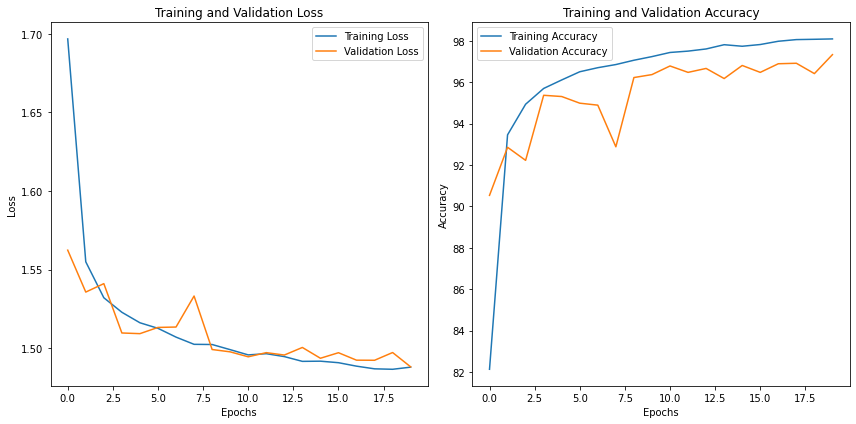

In [40]:
# Load the best model parameters into the model
model.load_state_dict(best_model)

# Print the best hyperparameters
print(f"Best Hyperparameters: {best_hyperparameters}")
print(f"Validation Accuracy: {val_accuracy:.4f}%")

# Plot training and validation loss for the best model
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training and validation accuracy for the best model
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(val_acc_history, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


## Load Images to test our best model and prepare it

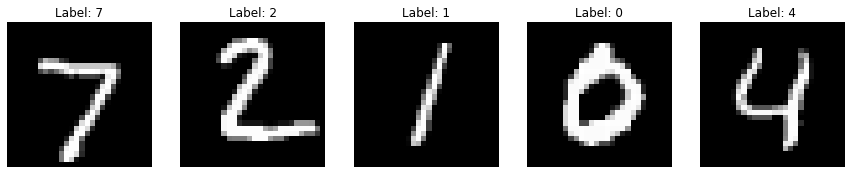

In [61]:
# Assuming you have a DataLoader for the test set named test_loader
# and a model that you want to evaluate named model

# Define the data transformation
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

# Load the MNIST test set
test_set = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# Evaluate the model on the test set
test_loss, test_accuracy = evaluate(model, test_loader)

# Visualize 5 samples from the test set
for images, labels in test_loader:
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))

    for i in range(5):
        img = images[i].numpy().squeeze()
        label = labels[i].item()

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    plt.show()
    break  # Break to only visualize one batch


##  Function For Testing 

In [62]:
# Evaluate the model on the test set
def evaluate(model, data_loader):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    correct_predictions = 0

    with torch.no_grad():
        for images, labels in data_loader:
            # Forward pass
            predictions = model.forward(images)
            # Compute loss
            loss = model.loss(predictions, labels)
            total_loss += loss.item()

            # Count correct predictions
            correct_predictions += (model.predict(images) == labels).sum().item()

    # Calculate average loss and accuracy
    average_loss = total_loss / len(data_loader)
    accuracy = 100 * correct_predictions / len(data_loader.dataset)

    return average_loss, accuracy

## Make Predictions with our model (test 20 From Internet (unseeeen data))

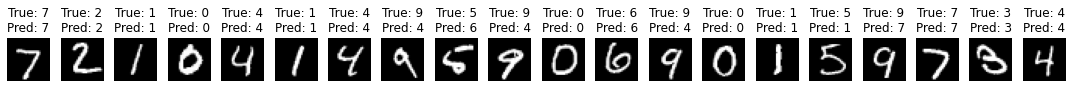

In [64]:
def visualize_samples_with_predictions(data_loader, num_samples=20, model=None):
    model.eval()  # Set the model to evaluation mode

    samples_visualized = 0

    for images, labels in data_loader:
        batch_size = images.size(0)
        num_samples_to_visualize = min(num_samples - samples_visualized, batch_size)
        fig, axes = plt.subplots(1, num_samples_to_visualize, figsize=(15, 3))

        for i in range(num_samples_to_visualize):
            img = images[i].numpy().squeeze()
            label = labels[i].item()

            # Make predictions using the model
            if model is not None:
                prediction = model.predict(images[i].unsqueeze(0)).item()
                title = f"True: {label}\nPred: {prediction}"
            else:
                title = f"Label: {label}"

            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(title)
            axes[i].axis('off')
        
        plt.tight_layout()  # Adjust layout for better spacing
        plt.show()

        samples_visualized += num_samples_to_visualize

        if samples_visualized >= num_samples:
            break  # Break if the desired number of samples has been visualized


# Visualize 10 samples with model predictions and correct labels
visualize_samples_with_predictions(test_loader, num_samples=20, model=model)


In [66]:
# Evaluate the model on the test set
test_loss, test_accuracy = evaluate(model, test_loader)

# Print the test results
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}%")

Test Loss: 1.7249, Test Accuracy: 73.7800%
